https://stats.stackexchange.com/questions/157012/area-under-precision-recall-curve-auc-of-pr-curve-and-average-precision-ap


https://stackoverflow.com/questions/38787612/how-to-extract-feature-importances-from-an-sklearn-pipeline
https://towardsdatascience.com/how-to-get-feature-importances-from-any-sklearn-pipeline-167a19f1214

https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html

https://link.springer.com/article/10.1007/s13748-016-0094-0

https://stackoverflow.com/questions/62663370/using-pipeline-with-gridsearchcv
https://medium.com/@cmukesh8688/sklearn-pipeline-gridsearchcv-54f5552bbf4e

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os
import datetime
import time
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from myTools import *

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score
from numpy import mean, std
from sklearn.model_selection import cross_val_predict

In [3]:
def ColMode(df, feature, key):
    
    feature = [feature]
    
    # dataframe de travail sans les nans et avec les colonnes feature et key
    cols = feature.copy()
    cols.extend(key)
    tmp = df[cols].dropna()
    
    # Count par feature-key
    tmp = pd.DataFrame(tmp.groupby(cols).size(), columns=['COUNT']).reset_index(drop=False)
    
    # Par key, valeurs les plus fréquentes de la feature
    tmpMaxCount = tmp.groupby(by=key).agg({'COUNT': 'max'}).reset_index(drop=False)
    colsMerge = key.copy()
    colsMerge.append('COUNT')
    tmp = tmp.merge(tmpMaxCount, left_on=colsMerge, right_on=colsMerge)

    # A chaque valeur de feature ont affecte un poids égal au nombre de fois que la valeur est prise dans la table
    colsPopularity = feature.copy()
    colsPopularity.append('COUNT')
    popularity = tmp.groupby(feature).agg({'COUNT': 'sum'}).reset_index(drop=False)
    colsPopularity = feature.copy()
    colsPopularity.append('POPULARITY')
    popularity.columns = colsPopularity
    
    tmp = tmp.merge(popularity)
    
    tmp2 = tmp.groupby(key).agg({'COUNT': 'max'}).reset_index(drop=False)
    tmp = tmp.merge(tmp2)
    tmp2 = tmp.groupby(key).agg({'POPULARITY': 'min'}).reset_index(drop=False)
    tmp = tmp.merge(tmp2)
    
    del tmp['COUNT']
    del tmp['POPULARITY']
    
    return tmp

def TransformUnique(df, key):
    categorical_ix = df.select_dtypes(include=['object']).columns
    dfCat = df[key].drop_duplicates()
    for col in categorical_ix:
        dfCat = dfCat.merge(ColMode(df, col, key), left_on=key, right_on=key, how='left')
    dfNum = df.groupby(key).mean().reset_index(drop=False)
    dfUnique = dfCat.merge(dfNum, left_on=key, right_on=key, how='left')
    return dfUnique

## Import et aperçu des données

### Fonction de mise à plat des fichiers

In [4]:

def flat_df(defaultData=False, splitRate=0):
    
    t1 = time.time()
    
    print(datetime.datetime.now())
    
    #########################################
    # CHARGEMENT DES FICHIERS
    #########################################
    
    dfApplicationTrain = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/application_train.csv',",")
    dfBureau = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/bureau.csv',",")
    dfBureauBalance = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/bureau_balance.csv',",")
    dfPreviousApplication = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/previous_application.csv',",")
    dfPosCashBalance = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/POS_CASH_balance.csv',",")
    dfCreditCardBalance = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/credit_card_balance.csv',",")
    dfInstallmentsPayments = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/installments_payments.csv',",")
    
    t2 = time.time()
    print("{} - {} - fichiers chargés".format(datetime.datetime.now(), t2-t1))
    t1 = t2

    
    #########################################
    # REDUCTION DU JEU DE DONNEES (ce n'est pas le train/test split classique)
    #########################################
    
    if splitRate == 0:
        dfApplication = dfApplicationTrain
    else:
        dfApplication, _ = train_test_split(dfApplicationTrain, test_size=splitRate, random_state=1)

    dfPreviousApplication = dfPreviousApplication.merge(dfApplication[['SK_ID_CURR']], left_on='SK_ID_CURR', right_on='SK_ID_CURR')
    dfPosCashBalance = dfPosCashBalance.merge(dfPreviousApplication[['SK_ID_CURR','SK_ID_PREV']], left_on=['SK_ID_CURR','SK_ID_PREV'], right_on=['SK_ID_CURR','SK_ID_PREV'])
    dfInstallmentsPayments = dfInstallmentsPayments.merge(dfPreviousApplication[['SK_ID_CURR','SK_ID_PREV']], left_on=['SK_ID_CURR','SK_ID_PREV'], right_on=['SK_ID_CURR','SK_ID_PREV'])
    dfCreditCardBalance = dfCreditCardBalance.merge(dfPreviousApplication[['SK_ID_CURR','SK_ID_PREV']], left_on=['SK_ID_CURR','SK_ID_PREV'], right_on=['SK_ID_CURR','SK_ID_PREV'])
    dfBureau = dfBureau.merge(dfApplication[['SK_ID_CURR']], left_on='SK_ID_CURR', right_on='SK_ID_CURR')
    dfBureauBalance = dfBureauBalance.merge(dfBureau[['SK_ID_BUREAU']], left_on='SK_ID_BUREAU', right_on='SK_ID_BUREAU')
    
    t2 = time.time()
    print("{} - {} - réduction du jeu de données".format(datetime.datetime.now(), t2-t1))
    t1 = t2

    
    #########################################
    # MARQUAGE DES VALEURS MANQUANTES
    #########################################

    dfApplication = dfApplication.replace('XNA', np.nan)
    dfPreviousApplication = dfPreviousApplication.replace('XNA', np.nan)
    dfBureau = dfBureau.replace('XNA', np.nan)
    dfApplication = dfApplication.replace('XAP', np.nan)
    dfPreviousApplication = dfPreviousApplication.replace('XAP', np.nan)
    dfBureau = dfBureau.replace('XAP', np.nan)
    dfBureauBalance = dfBureauBalance.replace('X', np.nan)
    
    t2 = time.time()
    print("{} - {} - marquage des valeurs manquantes".format(datetime.datetime.now(), t2-t1))
    t1 = t2



    #########################################
    # SUPPRESSION DE LIGNES
    #########################################

    if not defaultData:
        dfPreviousApplication = dfPreviousApplication[(dfPreviousApplication.FLAG_LAST_APPL_PER_CONTRACT == 'Y') & (dfPreviousApplication.NFLAG_LAST_APPL_IN_DAY == 1)]
        dfPreviousApplication = dfPreviousApplication[dfPreviousApplication.NAME_CONTRACT_STATUS.isin(['Approved','Refused'])]
        dfInstallmentsPayments = dfInstallmentsPayments[dfInstallmentsPayments.AMT_INSTALMENT != 0]
        
        
        t2 = time.time()
        print("{} - {} - suppression de lignes".format(datetime.datetime.now(), t2-t1))
        t1 = t2


    #########################################
    # SUPPRESSION DE VARIABLES
    #########################################

    if not defaultData:

        # COLONNES NON PERTINENTES

        # Suppression de champs non pertinents
        col_to_del = [
        'FLAG_MOBIL', # Did client provide mobile phone
        'FLAG_EMP_PHONE', # Did client provide work phone (1=YES, 0=NO)
        'FLAG_WORK_PHONE', # Did client provide home phone (1=YES, 0=NO)
        'FLAG_CONT_MOBILE', # Was mobile phone reachable (1=YES, 0=NO)
        'FLAG_PHONE', # Did client provide home phone (1=YES, 0=NO)
        'FLAG_EMAIL', # Did client provide email (1=YES, 0=NO)

        # ininéressant
        'NAME_TYPE_SUITE',  # Who was accompanying client when he was applying for the loan
        'DAYS_ID_PUBLISH', # How many days before the application did client change the identity document with which he applied for the loan,time only relative to the application
        'DAYS_REGISTRATION', # How many days before the application did client change his registration,time only relative to the application
        'WEEKDAY_APPR_PROCESS_START', # On which day of the week did the client apply for the loan
        'HOUR_APPR_PROCESS_START', # Approximately at what hour did the client apply for the loan,rounded
        'DAYS_LAST_PHONE_CHANGE', # How many days before application did client change phone

        # flags de comparaison de donnée
        'REG_REGION_NOT_LIVE_REGION', # Flag if client's permanent address does not match contact address
        'REG_REGION_NOT_WORK_REGION', # Flag if client's permanent address does not match contact address
        'LIVE_REGION_NOT_WORK_REGION', # Flag if client's contact address does not match work address
        'REG_CITY_NOT_LIVE_CITY', # Flag if client's permanent address does not match contact address (1=different, 0=same, at city level)
        'REG_CITY_NOT_WORK_CITY', # Flag if client's permanent address does not match work address (1=different, 0=same, at city level)
        'LIVE_CITY_NOT_WORK_CITY', # Flag if client's contact address does not match work address (1=different, 0=same, at city level)

        ]

        for col in col_to_del:
            del dfApplication[col]

        for col in dfApplication:
            if col[0:13] == 'FLAG_DOCUMENT':  # Did client provide document
                del dfApplication[col]



        del dfPreviousApplication['FLAG_LAST_APPL_PER_CONTRACT'] # Flag if it was last application for the previous contract. Sometimes by mistake of client or our clerk there could be more applications for one single contract
        del dfPreviousApplication['NFLAG_LAST_APPL_IN_DAY'] # Flag if the application was the last application per day of the client. Sometimes clients apply for more applications a day. Rarely it could also be error in our system that one application is in the database twice

        del dfPreviousApplication['NAME_TYPE_SUITE'] # Who accompanied client when applying for the previous application
        del dfPreviousApplication['WEEKDAY_APPR_PROCESS_START'] #On which day of the week did the client apply for the loan
        del dfPreviousApplication['HOUR_APPR_PROCESS_START'] #Approximately at what hour did the client apply for the loan
        del dfPreviousApplication['NAME_CLIENT_TYPE'] #Was the client old or new client when applying for the previous application
        del dfPreviousApplication['SELLERPLACE_AREA'] #Selling area of seller place of the previous application


        del dfInstallmentsPayments['NUM_INSTALMENT_VERSION'] #Version of installment calendar (0 is for credit card) of previous credit. Change of installment version from month to month signifies that some parameter of payment calendar has changed
        del dfInstallmentsPayments['NUM_INSTALMENT_NUMBER'] #On which installment we observe payment

        del dfPosCashBalance['CNT_INSTALMENT'] # Term of previous credit (can change over time)
        del dfPosCashBalance['CNT_INSTALMENT_FUTURE'] # Installments left to pay on the previous credit


        # COLONNES AVEC TROP DE VALEURS MANQUANTES

        del dfPreviousApplication['RATE_INTEREST_PRIMARY']
        del dfPreviousApplication['RATE_INTEREST_PRIVILEGED']
        del dfPreviousApplication['NAME_CASH_LOAN_PURPOSE']
        del dfBureau['AMT_ANNUITY']


        # COLONNES AVEC TROP DE VALEURS IDENTIQUES

        del dfPreviousApplication['NAME_PAYMENT_TYPE']
        del dfBureau['CREDIT_CURRENCY']
        del dfBureau['CNT_CREDIT_PROLONG']
        del dfBureau['CREDIT_DAY_OVERDUE']
        del dfBureau['AMT_CREDIT_SUM_OVERDUE']


        # COLONNES CORRELLEE AVEC UNE AUTRE

        del dfApplication['EXT_SOURCE_1']
        del dfApplication['OBS_60_CNT_SOCIAL_CIRCLE']
        del dfApplication['DEF_60_CNT_SOCIAL_CIRCLE']
        del dfApplication['OWN_CAR_AGE']
        del dfApplication['CNT_FAM_MEMBERS']
        del dfApplication['AMT_GOODS_PRICE']
        del dfApplication['REGION_RATING_CLIENT_W_CITY']
        del dfApplication['REGION_POPULATION_RELATIVE']
        del dfApplication['APARTMENTS_AVG']
        del dfApplication['APARTMENTS_MEDI']
        del dfApplication['BASEMENTAREA_AVG']
        del dfApplication['BASEMENTAREA_MEDI']
        del dfApplication['COMMONAREA_AVG']
        del dfApplication['COMMONAREA_MEDI']
        del dfApplication['ELEVATORS_AVG']
        del dfApplication['ELEVATORS_MEDI']
        del dfApplication['ENTRANCES_AVG']
        del dfApplication['ENTRANCES_MEDI']
        del dfApplication['FLOORSMAX_AVG']
        del dfApplication['FLOORSMAX_MEDI']
        del dfApplication['FLOORSMIN_AVG']
        del dfApplication['FLOORSMIN_MEDI']
        del dfApplication['LANDAREA_AVG']
        del dfApplication['LANDAREA_MEDI']
        del dfApplication['LIVINGAPARTMENTS_AVG']
        del dfApplication['LIVINGAPARTMENTS_MEDI']
        del dfApplication['LIVINGAREA_AVG']
        del dfApplication['LIVINGAREA_MEDI']
        del dfApplication['NONLIVINGAPARTMENTS_AVG']
        del dfApplication['NONLIVINGAPARTMENTS_MEDI']
        del dfApplication['NONLIVINGAREA_AVG']
        del dfApplication['NONLIVINGAREA_MEDI']
        del dfApplication['YEARS_BEGINEXPLUATATION_AVG']
        del dfApplication['YEARS_BEGINEXPLUATATION_MEDI']
        del dfApplication['YEARS_BUILD_AVG']
        del dfApplication['YEARS_BUILD_MEDI']
        del dfApplication['EMERGENCYSTATE_MODE']
        del dfApplication['HOUSETYPE_MODE']
        del dfApplication['NONLIVINGAREA_MODE']
        del dfApplication['NONLIVINGAPARTMENTS_MODE']
        del dfApplication['BASEMENTAREA_MODE']
        del dfApplication['COMMONAREA_MODE']
        del dfApplication['ELEVATORS_MODE']
        del dfApplication['ENTRANCES_MODE']
        del dfApplication['FLOORSMAX_MODE']
        del dfApplication['FLOORSMIN_MODE']
        del dfApplication['LANDAREA_MODE']
        del dfApplication['LIVINGAPARTMENTS_MODE']
        del dfApplication['LIVINGAREA_MODE']
        del dfApplication['TOTALAREA_MODE']
        del dfApplication['YEARS_BUILD_MODE']
        del dfApplication['FONDKAPREMONT_MODE']


        del dfPreviousApplication['DAYS_FIRST_DRAWING']
        del dfPreviousApplication['DAYS_FIRST_DUE']
        del dfPreviousApplication['DAYS_LAST_DUE_1ST_VERSION']
        del dfPreviousApplication['DAYS_LAST_DUE']
        del dfPreviousApplication['DAYS_TERMINATION']
        del dfPreviousApplication['AMT_APPLICATION']
        del dfPreviousApplication['AMT_GOODS_PRICE']
        del dfPreviousApplication['AMT_ANNUITY']
        del dfPreviousApplication['CNT_PAYMENT']
        del dfPreviousApplication['NAME_PORTFOLIO']
        del dfPreviousApplication['CODE_REJECT_REASON']
        del dfPreviousApplication['CHANNEL_TYPE']
        del dfPreviousApplication['NAME_CONTRACT_TYPE']
        del dfPreviousApplication['PRODUCT_COMBINATION']
        del dfPreviousApplication['NAME_GOODS_CATEGORY']
        del dfPreviousApplication['AMT_DOWN_PAYMENT']


        del dfCreditCardBalance['AMT_INST_MIN_REGULARITY']
        del dfCreditCardBalance['AMT_RECEIVABLE_PRINCIPAL']
        del dfCreditCardBalance['AMT_RECIVABLE']
        del dfCreditCardBalance['AMT_TOTAL_RECEIVABLE']
        del dfCreditCardBalance['AMT_DRAWINGS_POS_CURRENT']
        del dfCreditCardBalance['AMT_DRAWINGS_ATM_CURRENT']
        del dfCreditCardBalance['AMT_PAYMENT_CURRENT']
        del dfCreditCardBalance['AMT_CREDIT_LIMIT_ACTUAL']
        del dfCreditCardBalance['CNT_DRAWINGS_ATM_CURRENT']
        del dfCreditCardBalance['CNT_DRAWINGS_POS_CURRENT']
        del dfCreditCardBalance['AMT_DRAWINGS_OTHER_CURRENT']
        del dfCreditCardBalance['AMT_DRAWINGS_CURRENT']

        del dfPosCashBalance['SK_DPD_DEF']

        del dfBureau['DAYS_CREDIT_UPDATE']
        del dfBureau['DAYS_ENDDATE_FACT']
        del dfBureau['AMT_CREDIT_SUM_DEBT']


        # COLONNES DE TABLE DU TROISIEME NIVEAU

        del dfCreditCardBalance['AMT_BALANCE']
        del dfCreditCardBalance['AMT_PAYMENT_TOTAL_CURRENT']
        del dfCreditCardBalance['CNT_DRAWINGS_CURRENT']
        del dfCreditCardBalance['CNT_DRAWINGS_OTHER_CURRENT']
        del dfCreditCardBalance['CNT_INSTALMENT_MATURE_CUM']




        t2 = time.time()
        print("{} - {} - suppression de variables".format(datetime.datetime.now(), t2-t1))
        t1 = t2

    
    
    #########################################
    # TRANSFORMATION DE VARIABLES
    #########################################

    # On remonte le dernier statut des tables de niveau 3 dans PreviousApplication

    dfPreviousApplicationStatus = pd.concat([dfPosCashBalance[['SK_ID_CURR','SK_ID_PREV','MONTHS_BALANCE','NAME_CONTRACT_STATUS']],dfCreditCardBalance[['SK_ID_CURR','SK_ID_PREV','MONTHS_BALANCE','NAME_CONTRACT_STATUS']]])
    tmp = dfPreviousApplicationStatus.groupby(['SK_ID_CURR','SK_ID_PREV']).agg({'MONTHS_BALANCE':'max'}).reset_index(drop=False)
    dfPreviousApplicationStatus = dfPreviousApplicationStatus.merge(tmp, left_on=['SK_ID_CURR','SK_ID_PREV','MONTHS_BALANCE'], right_on=['SK_ID_CURR','SK_ID_PREV','MONTHS_BALANCE'])
    del dfPreviousApplicationStatus['MONTHS_BALANCE']
    dfPreviousApplicationStatus = dfPreviousApplicationStatus.rename(columns={'NAME_CONTRACT_STATUS': 'LAST_NAME_CONTRACT_STATUS'})
    dfPreviousApplication = dfPreviousApplication.merge(dfPreviousApplicationStatus, left_on=['SK_ID_CURR','SK_ID_PREV'], right_on=['SK_ID_CURR','SK_ID_PREV'], how='left')

    dfPreviousApplication.at[dfPreviousApplication[dfPreviousApplication.LAST_NAME_CONTRACT_STATUS == 'Completed'].index, "LAST_NAME_CONTRACT_STATUS_TMP"] = 0
    dfPreviousApplication.at[dfPreviousApplication[(dfPreviousApplication.LAST_NAME_CONTRACT_STATUS != 'Completed') & (~dfPreviousApplication.LAST_NAME_CONTRACT_STATUS.isnull())].index, "LAST_NAME_CONTRACT_STATUS_TMP"] = 1
    dfPreviousApplication['LAST_NAME_CONTRACT_STATUS'] = dfPreviousApplication['LAST_NAME_CONTRACT_STATUS_TMP']
    del dfPreviousApplication['LAST_NAME_CONTRACT_STATUS_TMP']
    dfPreviousApplication['LAST_NAME_CONTRACT_STATUS'] = dfPreviousApplication['LAST_NAME_CONTRACT_STATUS'].astype(float)

    del dfCreditCardBalance['NAME_CONTRACT_STATUS']
    del dfPosCashBalance['NAME_CONTRACT_STATUS']
    
    
    t2 = time.time()
    print("{} - {} - remontée de name_contract_status".format(datetime.datetime.now(), t2-t1))
    t1 = t2


    
    if defaultData:
        
        dfBureauBalance.at[dfBureauBalance[dfBureauBalance.STATUS.isin(['C','X'])].index, "STATUS"] = 0
        dfBureauBalance["STATUS"] = dfBureauBalance["STATUS"].astype(float)


        t2 = time.time()
        print("{} - {} - mise à zéro des status balance bureau C et X".format(datetime.datetime.now(), t2-t1))
        t1 = t2
    

    if not defaultData:

        dfApplication['AMT_REQ_CREDIT_BUREAU_YEAR'] = dfApplication.apply(lambda x: x.AMT_REQ_CREDIT_BUREAU_HOUR + \
                                                                                         x.AMT_REQ_CREDIT_BUREAU_DAY + \
                                                                                         x.AMT_REQ_CREDIT_BUREAU_WEEK + \
                                                                                         x.AMT_REQ_CREDIT_BUREAU_MON + \
                                                                                         x.AMT_REQ_CREDIT_BUREAU_QRT + \
                                                                                         x.AMT_REQ_CREDIT_BUREAU_YEAR, axis=1)
        dfApplication['AMT_REQ_CREDIT_BUREAU_WEEK'] = dfApplication.apply(lambda x: x.AMT_REQ_CREDIT_BUREAU_HOUR + \
                                                                                         x.AMT_REQ_CREDIT_BUREAU_DAY + \
                                                                                         x.AMT_REQ_CREDIT_BUREAU_WEEK, axis=1)
        
        dfApplication['RATIO_ANNUITY_INCOME'] = dfApplication.apply(lambda x: x.AMT_ANNUITY / (x.AMT_INCOME_TOTAL + 0.1), axis=1)

        dfApplication['AMT_INCOME_TOTAL_LOG'] = dfApplication.apply(lambda x: np.log(x.AMT_INCOME_TOTAL), axis=1)
        
        

        dfApplication['DAYS_EMPLOYED'] = dfApplication.apply(lambda x: np.where(x.DAYS_EMPLOYED>0,1,x.DAYS_EMPLOYED),axis=1).astype('int')


        dfApplication.at[dfApplication[dfApplication.NAME_EDUCATION_TYPE == 'Academic degree'].index, "NAME_EDUCATION_TYPE"] = 1
        dfApplication.at[dfApplication[dfApplication.NAME_EDUCATION_TYPE == 'Higher education'].index, "NAME_EDUCATION_TYPE"] = 2
        dfApplication.at[dfApplication[dfApplication.NAME_EDUCATION_TYPE == 'Incomplete higher'].index, "NAME_EDUCATION_TYPE"] = 3
        dfApplication.at[dfApplication[dfApplication.NAME_EDUCATION_TYPE == 'Secondary / secondary special'].index, "NAME_EDUCATION_TYPE"] = 4
        dfApplication.at[dfApplication[dfApplication.NAME_EDUCATION_TYPE == 'Lower secondary'].index, "NAME_EDUCATION_TYPE"] = 5

        dfApplication['NAME_EDUCATION_TYPE'] = dfApplication['NAME_EDUCATION_TYPE'].astype(float)

        dfApplication.at[dfApplication[dfApplication.NAME_FAMILY_STATUS == 'Married'].index, "SINGLE_FLAG"] = 0
        dfApplication.at[dfApplication[dfApplication.NAME_FAMILY_STATUS == 'Civil marriage'].index, "SINGLE_FLAG"] = 0
        dfApplication.at[dfApplication[dfApplication.NAME_FAMILY_STATUS == 'Single / not married'].index, "SINGLE_FLAG"] = 1
        dfApplication.at[dfApplication[dfApplication.NAME_FAMILY_STATUS == 'Separated'].index, "SINGLE_FLAG"] = 1
        dfApplication.at[dfApplication[dfApplication.NAME_FAMILY_STATUS == 'Widow'].index, "SINGLE_FLAG"] = 1
        dfApplication.at[dfApplication[dfApplication.NAME_FAMILY_STATUS == 'Unknown'].index, "SINGLE_FLAG"] = 1

        dfApplication['SINGLE_FLAG'] = dfApplication['SINGLE_FLAG'].astype(float)
        
        
        t2 = time.time()
        print("{} - {} - feature engeeniring sur REQ, EDUC et FAMILY_STATUS".format(datetime.datetime.now(), t2-t1))
        t1 = t2


        df1 = dfBureau[['SK_ID_CURR','SK_ID_BUREAU','DAYS_CREDIT']]
        df1.columns = ['SK_ID_CURR','SK_ID_PREV','DAYS_DECISION']
        df2 = dfPreviousApplication[['SK_ID_CURR','SK_ID_PREV','DAYS_DECISION']]
        dfDays = pd.concat([df1,df2])

        #https://www.kaggle.com/shanth84/home-credit-bureau-data-feature-engineering
        grp = dfDays[['SK_ID_CURR', 'SK_ID_PREV', 'DAYS_DECISION']].groupby(by = ['SK_ID_CURR'])
        grp1 = grp.apply(lambda x: x.sort_values(['DAYS_DECISION'], ascending = False)).reset_index(drop = True)#rename(index = str, columns = {'DAYS_CREDIT': 'DAYS_CREDIT_DIFF'})
        grp1['DAYS_DECISION1'] = grp1['DAYS_DECISION']*-1
        grp1['DAYS_DIFF'] = grp1.groupby(by = ['SK_ID_CURR'])['DAYS_DECISION1'].diff()
        grp1['DAYS_DIFF'] = grp1['DAYS_DIFF'].fillna(0).astype('uint32')
        del grp1['DAYS_DECISION1'], grp1['DAYS_DECISION'], grp1['SK_ID_CURR']
        dfDays = dfDays.merge(grp1, left_on='SK_ID_PREV', right_on='SK_ID_PREV')
        del dfDays['DAYS_DECISION']
        del dfDays['SK_ID_PREV']
        dfDays = dfDays.groupby('SK_ID_CURR').mean().reset_index(drop=False)
        dfDays['DAYS_DIFF'] = dfDays['DAYS_DIFF'].astype(float)
        
        t2 = time.time()
        print("{} - {} - PREV DAYS_DIFF".format(datetime.datetime.now(), t2-t1))
        t1 = t2

        # Création d'une variable montant moyen logarithmique
        dfPreviousApplication['AMT_CREDIT_LOG'] = dfPreviousApplication.apply(lambda x: np.log(x.AMT_CREDIT+1), axis=1)
        dfBureau['AMT_CREDIT_SUM_LOG'] = dfBureau.apply(lambda x: np.log(x.AMT_CREDIT_SUM+1), axis=1)
        df1 = dfBureau[['SK_ID_CURR','SK_ID_BUREAU','AMT_CREDIT_SUM_LOG']]
        df1.columns = ['SK_ID_CURR','SK_ID_PREV','AMT_CREDIT_LOG']
        df2 = dfPreviousApplication[['SK_ID_CURR','SK_ID_PREV','AMT_CREDIT_LOG']]
        dfAmtLog = pd.concat([df1,df2])
        del dfAmtLog['SK_ID_PREV']
        dfAmtLogMean = dfAmtLog.groupby('SK_ID_CURR').mean().reset_index(drop=False)

        del dfBureau['AMT_CREDIT_SUM_LOG']
        del dfPreviousApplication['AMT_CREDIT_LOG']

        # Création d'une variable écart type logarithmique des montants 
        df1 = dfBureau[['SK_ID_CURR','SK_ID_BUREAU','AMT_CREDIT_SUM']]
        df1.columns = ['SK_ID_CURR','SK_ID_PREV','AMT_CREDIT']
        df2 = dfPreviousApplication[['SK_ID_CURR','SK_ID_PREV','AMT_CREDIT']]
        dfAmt = pd.concat([df1,df2])
        del dfAmt['SK_ID_PREV']
        dfAmtStdLog = dfAmt.groupby('SK_ID_CURR').std().reset_index(drop=False).rename(columns = {'AMT_CREDIT': 'AMT_CREDIT_STD'})
        dfAmtStdLog['AMT_CREDIT_STD_LOG'] = dfAmtStdLog.apply(lambda x: np.log(1+x.AMT_CREDIT_STD), axis=1)
        del dfAmtStdLog['AMT_CREDIT_STD']
        
        t2 = time.time()
        print("{} - {} - PREV montant logarithmique dur PREV".format(datetime.datetime.now(), t2-t1))
        t1 = t2


        # NameSellerIndustry avec le plus gros montant cumulé par client
        tmp0 = dfPreviousApplication[~dfPreviousApplication.NAME_SELLER_INDUSTRY.isnull()].reset_index(drop=False)
        tmp1 = tmp0[['SK_ID_CURR','NAME_SELLER_INDUSTRY','AMT_CREDIT']].groupby(['SK_ID_CURR','NAME_SELLER_INDUSTRY']).sum().reset_index(drop=False)
        tmp2 = tmp1[['SK_ID_CURR','AMT_CREDIT']].groupby(['SK_ID_CURR']).max().reset_index(drop=False)
        tmp3 = tmp1.merge(tmp2, left_on=['SK_ID_CURR','AMT_CREDIT'], right_on=['SK_ID_CURR','AMT_CREDIT'])
        # Pour les rares clients avec plusieurs seller_industry préférés, on en sélectionne un au hasard en se basant sur l'index
        tmp4 = tmp3.reset_index(drop=False)[['SK_ID_CURR','index']].groupby('SK_ID_CURR').max().reset_index(drop=False)
        tmp3 = tmp3.reset_index(drop=False)
        tmp3 = tmp3.merge(tmp4, left_on=['SK_ID_CURR','index'], right_on=['SK_ID_CURR','index'])
        dfPreviousApplicationMainSellerIndustry = tmp3[['SK_ID_CURR','NAME_SELLER_INDUSTRY']]
        dfPreviousApplicationMainSellerIndustry.columns = ['SK_ID_CURR','MAIN_SELLER_INDUSTRY']
        
        t2 = time.time()
        print("{} - {} - PREV NAME_SELLER_INDUSTRY".format(datetime.datetime.now(), t2-t1))
        t1 = t2


        dfPreviousApplication.at[dfPreviousApplication[dfPreviousApplication.NAME_YIELD_GROUP == 'high'].index, "NAME_YIELD_GROUP"] = 3
        dfPreviousApplication.at[dfPreviousApplication[dfPreviousApplication.NAME_YIELD_GROUP == 'middle'].index, "NAME_YIELD_GROUP"] = 2
        dfPreviousApplication.at[dfPreviousApplication[dfPreviousApplication.NAME_YIELD_GROUP == 'low_normal'].index, "NAME_YIELD_GROUP"] = 1
        dfPreviousApplication.at[dfPreviousApplication[dfPreviousApplication.NAME_YIELD_GROUP == 'low_action'].index, "NAME_YIELD_GROUP"] = 1
        dfPreviousApplication['NAME_YIELD_GROUP'] = dfPreviousApplication['NAME_YIELD_GROUP'].astype(float)   
        
        t2 = time.time()
        print("{} - {} - PREV NAME_YIELD_GROUP".format(datetime.datetime.now(), t2-t1))
        t1 = t2

        # Nombre de type de seller industry par client
        dfPreviousApplicationNbSellerIndustry = dfPreviousApplication[['SK_ID_CURR','NAME_SELLER_INDUSTRY']].drop_duplicates().groupby('SK_ID_CURR').count().reset_index(drop=False)
        dfPreviousApplicationNbSellerIndustry.columns = ['SK_ID_CURR','NB_SELLER_INDUSTRY']

        dfPreviousApplication = dfPreviousApplication.merge(dfPreviousApplicationMainSellerIndustry, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')
        dfPreviousApplication = dfPreviousApplication.merge(dfPreviousApplicationNbSellerIndustry, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')
        del dfPreviousApplication['NAME_SELLER_INDUSTRY']
        
        t2 = time.time()
        print("{} - {} - PREV NB_SELLER_INDUS".format(datetime.datetime.now(), t2-t1))
        t1 = t2

        # Création d'une variable nombre de previous application
        dfNbPreviousApplication = pd.DataFrame(dfPreviousApplication.groupby('SK_ID_CURR').size(), columns=['NB_PREVIOUS']).reset_index(drop=False)
        dfPreviousApplication = dfPreviousApplication.merge(dfNbPreviousApplication, left_on='SK_ID_CURR', right_on='SK_ID_CURR')
        
        t2 = time.time()
        print("{} - {} - PREV NB_PREVIOUS".format(datetime.datetime.now(), t2-t1))
        t1 = t2



        dfBureau['CREDIT_ACTIVE'] = dfBureau.apply(lambda x: np.where(x.CREDIT_ACTIVE == 'Active', 1, 0), axis=1)
        dfBureau.CREDIT_ACTIVE = dfBureau.CREDIT_ACTIVE.astype(float)
        
        
        t2 = time.time()
        print("{} - {} - BURO NB_PRCREDIT_ACTIVE".format(datetime.datetime.now(), t2-t1))
        t1 = t2


        dfPreviousApplication.at[dfPreviousApplication[dfPreviousApplication.NAME_CONTRACT_STATUS == 'Approved'].index, "NAME_CONTRACT_STATUS"] = 1
        dfPreviousApplication.at[dfPreviousApplication[dfPreviousApplication.NAME_CONTRACT_STATUS == 'Refused'].index, "NAME_CONTRACT_STATUS"] = 0
        dfPreviousApplication['NAME_CONTRACT_STATUS'] = dfPreviousApplication['NAME_CONTRACT_STATUS'].astype(float)
        
        
        t2 = time.time()
        print("{} - {} - PREV NAME_CONTRACT_STATUS".format(datetime.datetime.now(), t2-t1))
        t1 = t2



        dfXSell = dfPreviousApplication[dfPreviousApplication.NAME_PRODUCT_TYPE == 'x-sell'][['SK_ID_CURR']].drop_duplicates()
        dfXSell['X_SELL'] = 1
        dfXSell
        dfPreviousApplication = dfPreviousApplication.merge(dfXSell, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')
        dfPreviousApplication['X_SELL'] = dfPreviousApplication.apply(lambda x: np.where(x.X_SELL==1,1,0), axis=1)
        dfPreviousApplication.X_SELL = dfPreviousApplication.X_SELL.astype(float)
        del dfPreviousApplication['NAME_PRODUCT_TYPE']
        
        
        t2 = time.time()
        print("{} - {} - PREV XSELL".format(datetime.datetime.now(), t2-t1))
        t1 = t2


        # Type de crédit avec le plus gros montant cumulé par client
        tmp0 = dfBureau[~dfBureau.CREDIT_TYPE.isnull()].reset_index(drop=False)
        tmp1 = tmp0[['SK_ID_CURR','CREDIT_TYPE','AMT_CREDIT_SUM']].groupby(['SK_ID_CURR','CREDIT_TYPE']).sum().reset_index(drop=False)
        tmp2 = tmp1[['SK_ID_CURR','AMT_CREDIT_SUM']].groupby(['SK_ID_CURR']).max().reset_index(drop=False)
        tmp3 = tmp1.merge(tmp2, left_on=['SK_ID_CURR','AMT_CREDIT_SUM'], right_on=['SK_ID_CURR','AMT_CREDIT_SUM'])
        tmp4 = tmp3.reset_index(drop=False)[['SK_ID_CURR','index']].groupby('SK_ID_CURR').max().reset_index(drop=False)
        tmp3 = tmp3.reset_index(drop=False)
        tmp3 = tmp3.merge(tmp4, left_on=['SK_ID_CURR','index'], right_on=['SK_ID_CURR','index'])
        dfBureauMainCreditType = tmp3[['SK_ID_CURR','CREDIT_TYPE']]
        dfBureauMainCreditType.columns = ['SK_ID_CURR','MAIN_CREDIT_TYPE']
        
        
        t2 = time.time()
        print("{} - {} - BURO MAIN_CREDIT_TYPE".format(datetime.datetime.now(), t2-t1))
        t1 = t2
        
        
        

        # Nombre de type de crédits par client
        dfBureauNbCreditType = dfBureau[['SK_ID_CURR','CREDIT_TYPE']].drop_duplicates().groupby('SK_ID_CURR').count().reset_index(drop=False)
        dfBureauNbCreditType.columns = ['SK_ID_CURR','NB_CREDIT_TYPE']

        dfBureau = dfBureau.merge(dfBureauMainCreditType, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')
        dfBureau = dfBureau.merge(dfBureauNbCreditType, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')
        
    

        # Création d'une variable nombre de bureau
        dfNbBureau = pd.DataFrame(dfBureau.groupby('SK_ID_CURR').size(), columns=['NB_BUREAU']).reset_index(drop=False)
        dfBureau = dfBureau.merge(dfNbBureau, left_on='SK_ID_CURR', right_on='SK_ID_CURR')
        
        
        t2 = time.time()
        print("{} - {} - BURO NB".format(datetime.datetime.now(), t2-t1))
        t1 = t2


        # Nombre d'installment par client
        dfInstallmentsPaymentsCount = pd.DataFrame(dfInstallmentsPayments.groupby('SK_ID_CURR').size(), columns=['NB_INSTALLMENT']).reset_index(drop=False)
        
        # nouveau
        dfInstallmentsPayments = dfInstallmentsPayments.merge(dfInstallmentsPaymentsCount, right_on='SK_ID_CURR', left_on='SK_ID_CURR')

        dfInstallmentsPayments['DIFF_DAYS_INSTALLMENT_PAYMENT'] = dfInstallmentsPayments.apply(lambda x: x.DAYS_INSTALMENT - x.DAYS_ENTRY_PAYMENT, axis=1)
        dfInstallmentsPayments['DIFF_AMT_INSTALLMENT_PAYMENT'] = dfInstallmentsPayments.apply(lambda x: (x.AMT_INSTALMENT - x.AMT_PAYMENT)/x.AMT_INSTALMENT, axis=1)
        dfInstallmentsPayments['DIFF_DAYS_INSTALLMENT_PAYMENT_POS'] = dfInstallmentsPayments.apply(lambda x: np.where(x.DIFF_DAYS_INSTALLMENT_PAYMENT>0,x.DIFF_DAYS_INSTALLMENT_PAYMENT,0) / (np.sqrt(1-x.DAYS_ENTRY_PAYMENT) * x.NB_INSTALLMENT), axis=1)
        dfInstallmentsPayments['DIFF_DAYS_INSTALLMENT_PAYMENT_NEG'] = dfInstallmentsPayments.apply(lambda x: np.where(x.DIFF_DAYS_INSTALLMENT_PAYMENT<0,x.DIFF_DAYS_INSTALLMENT_PAYMENT,0) / (np.sqrt(1-x.DAYS_ENTRY_PAYMENT) * x.NB_INSTALLMENT), axis=1)
        dfInstallmentsPayments['DIFF_AMT_INSTALLMENT_PAYMENT_POS'] = dfInstallmentsPayments.apply(lambda x: np.where(x.DIFF_AMT_INSTALLMENT_PAYMENT>0,x.DIFF_AMT_INSTALLMENT_PAYMENT,0) / (np.sqrt(1-x.DAYS_ENTRY_PAYMENT) * x.NB_INSTALLMENT), axis=1)
        dfInstallmentsPayments['DIFF_AMT_INSTALLMENT_PAYMENT_NEG'] = dfInstallmentsPayments.apply(lambda x: np.where(x.DIFF_AMT_INSTALLMENT_PAYMENT<0,x.DIFF_AMT_INSTALLMENT_PAYMENT,0) / (np.sqrt(1-x.DAYS_ENTRY_PAYMENT) * x.NB_INSTALLMENT), axis=1)
        dfInstallmentsPayments['DIFF_DAYS_INSTALLMENT_PAYMENT']
        dfInstallmentsPayments['DIFF_AMT_INSTALLMENT_PAYMENT']
        dfInstallmentsPayments = dfInstallmentsPayments.groupby('SK_ID_CURR').sum().reset_index(drop=False)

            
        t2 = time.time()
        print("{} - {} - INSTALLMENT".format(datetime.datetime.now(), t2-t1))
        t1 = t2

        

        dfPosCashBalanceCount = pd.DataFrame(dfPosCashBalance.groupby('SK_ID_CURR').size(), columns=['NB_POS_CASH_BALANCE']).reset_index(drop=False)
        dfPosCashBalance['SK_DPD'] = dfPosCashBalance.apply(lambda x: x.SK_DPD / np.sqrt(1-x.MONTHS_BALANCE), axis=1)
        dfPosCashBalance = dfPosCashBalance.groupby('SK_ID_CURR').sum().reset_index(drop=False)
        dfPosCashBalance = dfPosCashBalance.merge(dfPosCashBalanceCount, left_on='SK_ID_CURR', right_on='SK_ID_CURR')
        dfPosCashBalance['SK_DPD'] = dfPosCashBalance.apply(lambda x: x.SK_DPD / x.NB_POS_CASH_BALANCE, axis=1)
        dfPosCashBalance['SK_DPD'] = dfPosCashBalance.apply(lambda x: np.log(1+x.SK_DPD), axis=1)
        dfPosCashBalance = dfPosCashBalance.rename(columns={'SK_DPD':'SK_DPD_POS_CASH'})
        
        
        t2 = time.time()
        print("{} - {} - POSCASH".format(datetime.datetime.now(), t2-t1))
        t1 = t2



        dfCreditCardBalanceCount = pd.DataFrame(dfCreditCardBalance.groupby('SK_ID_CURR').size(), columns=['NB_CREDIT_CARD_BALANCE']).reset_index(drop=False)
        dfCreditCardBalance['SK_DPD'] = dfCreditCardBalance.apply(lambda x: x.SK_DPD / np.sqrt(1-x.MONTHS_BALANCE), axis=1)
        dfCreditCardBalance['SK_DPD_DEF'] = dfCreditCardBalance.apply(lambda x: x.SK_DPD_DEF / np.sqrt(1-x.MONTHS_BALANCE), axis=1)
        dfCreditCardBalance = dfCreditCardBalance.groupby('SK_ID_CURR').sum().reset_index(drop=False)
        dfCreditCardBalance = dfCreditCardBalance.merge(dfCreditCardBalanceCount, left_on='SK_ID_CURR', right_on='SK_ID_CURR')
        dfCreditCardBalance['SK_DPD'] = dfCreditCardBalance.apply(lambda x: x.SK_DPD / x.NB_CREDIT_CARD_BALANCE, axis=1)
        dfCreditCardBalance['SK_DPD_DEF'] = dfCreditCardBalance.apply(lambda x: x.SK_DPD_DEF / x.NB_CREDIT_CARD_BALANCE, axis=1)
        dfCreditCardBalance['SK_DPD'] = dfCreditCardBalance.apply(lambda x: np.log(1+x.SK_DPD), axis=1)
        dfCreditCardBalance['SK_DPD_DEF'] = dfCreditCardBalance.apply(lambda x: np.log(1+x.SK_DPD_DEF), axis=1)
        dfCreditCardBalance = dfCreditCardBalance.rename(columns={'SK_DPD':'SK_DPD_CRED_CARD'})
        dfCreditCardBalance = dfCreditCardBalance.rename(columns={'SK_DPD_DEF':'SK_DPD_DEF_CRED_CARD'})
        
        t2 = time.time()
        print("{} - {} - CREDITCARD".format(datetime.datetime.now(), t2-t1))
        t1 = t2




        # Création d'une variable indiquant le niveau de DPD (day past due) du client sur Bureau
        dfBureauBalance = dfBureauBalance.merge(dfBureau[['SK_ID_CURR','SK_ID_BUREAU']], left_on=['SK_ID_BUREAU'], right_on=['SK_ID_BUREAU'])
        dfBureauBalanceCount = pd.DataFrame(dfBureauBalance.groupby('SK_ID_CURR').size(), columns=['NB_BUREAU_BALANCE']).reset_index(drop=False)
        dfBureauBalance = dfBureauBalance[dfBureauBalance.STATUS.isin(['1','2','3','4','5'])]
        dfBureauBalance['STATUS'] = dfBureauBalance['STATUS'].astype('int')
        dfBureauBalance['STATUS_BUREAU_DPD'] = dfBureauBalance.apply(lambda x: x.STATUS / np.sqrt(1-x.MONTHS_BALANCE), axis=1)
        dfBureauDPD = dfBureauBalance.groupby('SK_ID_CURR').sum().reset_index(drop=False)[['SK_ID_CURR','STATUS_BUREAU_DPD']]
        dfBureauDPD = dfBureauDPD.merge(dfBureauBalanceCount, left_on='SK_ID_CURR', right_on='SK_ID_CURR')
        dfBureauNoDPD = myDf(dfBureau).WhereNotExists(dfBureauDPD, left_on=['SK_ID_CURR'], right_on=['SK_ID_CURR'])[['SK_ID_CURR']].drop_duplicates()
        dfBureauNoDPD['STATUS_BUREAU_DPD'] = 0
        dfBureauDPD = pd.concat([dfBureauDPD,dfBureauNoDPD])
        dfBureauDPD['STATUS_BUREAU_DPD'] = dfBureauDPD.apply(lambda x: np.log(1+x.STATUS_BUREAU_DPD), axis=1)

        dfBureauBalance = dfBureauDPD
        
        
        t2 = time.time()
        print("{} - {} - BUROBAL".format(datetime.datetime.now(), t2-t1))
        t1 = t2




    #########################################
    # SUPPRESSION DE VARIABLES AYANT SERVI A LA TRANSFORMATION
    #########################################

    if not defaultData:
        
        del dfApplication['AMT_ANNUITY']  # également corrélée à une autre variable conservée

        del dfApplication['AMT_REQ_CREDIT_BUREAU_HOUR']
        del dfApplication['AMT_REQ_CREDIT_BUREAU_DAY']
        del dfApplication['AMT_REQ_CREDIT_BUREAU_MON']
        del dfApplication['AMT_REQ_CREDIT_BUREAU_QRT']
        del dfApplication['AMT_INCOME_TOTAL'] 
        del dfApplication['NAME_FAMILY_STATUS']
        del dfBureau['AMT_CREDIT_SUM']
        del dfPreviousApplication['AMT_CREDIT']
        del dfBureau['CREDIT_TYPE']

        del dfInstallmentsPayments['SK_ID_PREV']
        del dfInstallmentsPayments['DAYS_INSTALMENT']
        del dfInstallmentsPayments['DAYS_ENTRY_PAYMENT']
        del dfInstallmentsPayments['AMT_INSTALMENT']
        del dfInstallmentsPayments['AMT_PAYMENT']

        del dfPosCashBalance['MONTHS_BALANCE']
        del dfPosCashBalance['SK_ID_PREV']

        del dfCreditCardBalance['MONTHS_BALANCE']
        del dfCreditCardBalance['SK_ID_PREV']


        #del dfPosCashBalance['NAME_CONTRACT_STATUS']
        #del dfCreditCardBalance['NAME_CONTRACT_STATUS']

        #del dfBureauBalance['SK_ID_BUREAU']
        #del dfBureauBalance['STATUS']
        #del dfBureauBalance['MONTHS_BALANCE']

        del dfPreviousApplication['SK_ID_PREV']
        del dfBureau['SK_ID_BUREAU']






    #########################################
    # RENOMMAGE DE COLONNES
    #########################################

    def newColNames(df, suffix):
        cols = []
        keys = ['SK_ID_CURR','SK_ID_PREV','SK_ID_BUREAU']
        for col in df:
            if col not in keys:
                col = suffix + '_' + col
            cols.append(col)
        return cols
    newColNames(dfPreviousApplication, 'PREV')

    if defaultData:
        dfPreviousApplication.columns = newColNames(dfPreviousApplication, 'PREV')
        dfPosCashBalance.columns = newColNames(dfPosCashBalance, 'POSCASH')
        dfInstallmentsPayments.columns = newColNames(dfInstallmentsPayments, 'INSTALPAYMT')
        dfCreditCardBalance.columns = newColNames(dfCreditCardBalance, 'CREDCARD')
        dfBureau.columns = newColNames(dfBureau, 'BURO')
        dfBureauBalance.columns = newColNames(dfBureauBalance, 'BUROBAL')



    t2 = time.time()
    print("{} - {} - suppression de variables et renommage de colonnes".format(datetime.datetime.now(), t2-t1))
    t1 = t2



    #########################################
    # MISE A PLAT DES DONNEES
    #########################################

    if not defaultData:
        categorical_col = list(dfPreviousApplication.select_dtypes(include=['object']).columns)
        categorical_col.append('SK_ID_CURR')
        dfPreviousApplicationCat = dfPreviousApplication[categorical_col].drop_duplicates()
        dfPreviousApplicationNum = dfPreviousApplication.groupby('SK_ID_CURR').mean().reset_index(drop=False)
        dfPreviousApplication = dfPreviousApplicationNum.merge(dfPreviousApplicationCat, left_on='SK_ID_CURR', right_on = 'SK_ID_CURR', how='left')

        dfPreviousApplication = dfPreviousApplication.merge(dfCreditCardBalance, left_on='SK_ID_CURR', right_on = 'SK_ID_CURR', how='left')
        dfPreviousApplication = dfPreviousApplication.merge(dfPosCashBalance, left_on='SK_ID_CURR', right_on = 'SK_ID_CURR', how='left')
        dfPreviousApplication = dfPreviousApplication.merge(dfInstallmentsPayments, left_on='SK_ID_CURR', right_on = 'SK_ID_CURR', how='left')


        categorical_ix = list(dfBureau.select_dtypes(include=['object', 'bool']).columns)
        categorical_ix.append('SK_ID_CURR')
        dfBureauCat = dfBureau[categorical_ix].drop_duplicates()
        dfBureauNum = dfBureau.groupby('SK_ID_CURR').mean().reset_index(drop=False)
        dfBureau = dfBureauNum.merge(dfBureauCat, left_on='SK_ID_CURR', right_on = 'SK_ID_CURR', how='left')
        dfBureau = dfBureau.merge(dfBureauDPD, left_on='SK_ID_CURR', right_on = 'SK_ID_CURR', how='left')
        dfApplication = dfApplication.merge(dfAmtLogMean, left_on='SK_ID_CURR', right_on = 'SK_ID_CURR', how='left')
        dfApplication = dfApplication.merge(dfAmtStdLog, left_on='SK_ID_CURR', right_on = 'SK_ID_CURR', how='left')
        dfApplication = dfApplication.merge(dfDays, left_on='SK_ID_CURR', right_on = 'SK_ID_CURR', how='left')
        dfApplication = dfApplication.merge(dfPreviousApplication, left_on='SK_ID_CURR', right_on = 'SK_ID_CURR', how='left')
        dfApplication = dfApplication.merge(dfBureau, left_on='SK_ID_CURR', right_on = 'SK_ID_CURR', how='left')

    else:


        dfBureauBalance = TransformUnique(dfBureauBalance, ['SK_ID_BUREAU'])
        dfPosCashBalance = TransformUnique(dfPosCashBalance, ['SK_ID_CURR','SK_ID_PREV'])
        dfCreditCardBalance = TransformUnique(dfCreditCardBalance, ['SK_ID_CURR','SK_ID_PREV'])
        dfInstallmentsPayments = TransformUnique(dfInstallmentsPayments, ['SK_ID_CURR','SK_ID_PREV'])

        dfPreviousApplication = dfPreviousApplication.merge(dfCreditCardBalance, left_on=['SK_ID_CURR','SK_ID_PREV'], right_on = ['SK_ID_CURR','SK_ID_PREV'], how='left')
        dfPreviousApplication = dfPreviousApplication.merge(dfPosCashBalance, left_on=['SK_ID_CURR','SK_ID_PREV'], right_on = ['SK_ID_CURR','SK_ID_PREV'], how='left')
        dfPreviousApplication = dfPreviousApplication.merge(dfInstallmentsPayments, left_on=['SK_ID_CURR','SK_ID_PREV'], right_on = ['SK_ID_CURR','SK_ID_PREV'], how='left')

        dfBureau = dfBureau.merge(dfBureauBalance, left_on='SK_ID_BUREAU', right_on = 'SK_ID_BUREAU', how='left')

        dfPreviousApplication = TransformUnique(dfPreviousApplication, ['SK_ID_CURR'])
        dfBureau = TransformUnique(dfBureau, ['SK_ID_CURR'])


        dfApplication = dfApplication.merge(dfPreviousApplication, left_on='SK_ID_CURR', right_on = 'SK_ID_CURR', how='left')
        dfApplication = dfApplication.merge(dfBureau, left_on='SK_ID_CURR', right_on = 'SK_ID_CURR', how='left')


    t2 = time.time()
    print("{} - {} - mise à plat".format(datetime.datetime.now(), t2-t1))
    t1 = t2
    
        
    #########################################
    # Mise à zéro des colonnes NB
    #########################################

    if not defaultData:

        cols = [
                'NB_PREVIOUS',
                'NB_INSTALLMENT',
                'NB_BUREAU',
                'NB_BUREAU_BALANCE',
                'NB_CREDIT_CARD_BALANCE',
                'NB_POS_CASH_BALANCE']

        dfApplication[cols] = dfApplication[cols].replace(np.nan, 0)

        t2 = time.time()
        print("{} - {} - mise à zéro colonnes NB".format(datetime.datetime.now(), t2-t1))
        t1 = t2
        
    #########################################
    # Suppression des colonnes ID
    #########################################
    
    if defaultData:
        
        del dfApplication['SK_ID_PREV']
        del dfApplication['SK_ID_BUREAU']
        del dfApplication['INSTALPAYMT_NUM_INSTALMENT_VERSION']
        

    #########################################
    # SUPPRESSION DES COLONNES SANS INFORMATION
    #########################################

    counts = dfApplication.nunique()
    counts = counts[counts==1]
    to_del = list(counts.index)
    dfApplication.drop(to_del, axis=1, inplace=True)
    

    t2 = time.time()
    print("{} - {} - suppression de colonnes".format(datetime.datetime.now(), t2-t1))
    t1 = t2

    #########################################
    # GESTION DES QUELQUES VALEURS NUMERIQUES MANQUANTES
    #########################################

    if not defaultData:
        
        dfApplication.at[dfApplication[dfApplication.NB_PREVIOUS >= 1].index, "NB_SELLER_INDUSTRY"] = 1
        dfApplication.at[dfApplication[dfApplication.NB_BUREAU >= 1].index, "NB_CREDIT_TYPE"] = 1

        cols = ['AMT_REQ_CREDIT_BUREAU_WEEK',
                'AMT_REQ_CREDIT_BUREAU_YEAR',
                'DAYS_DIFF',
                'RATE_DOWN_PAYMENT',
                'DAYS_DECISION',
                'NAME_YIELD_GROUP',
                'NB_SELLER_INDUSTRY',
                'DIFF_DAYS_INSTALLMENT_PAYMENT_POS',
                'DIFF_DAYS_INSTALLMENT_PAYMENT_NEG',
                'DIFF_AMT_INSTALLMENT_PAYMENT_POS',
                'DIFF_AMT_INSTALLMENT_PAYMENT_NEG',
                'DAYS_CREDIT',
                'DAYS_CREDIT_ENDDATE',
                'AMT_CREDIT_MAX_OVERDUE',
                'AMT_CREDIT_SUM_LIMIT',
                'NB_CREDIT_TYPE',
                'STATUS_BUREAU_DPD',
                'AMT_CREDIT_LOG',
                'AMT_CREDIT_STD_LOG',
                'SK_DPD_CRED_CARD',
                'SK_DPD_DEF_CRED_CARD',
                'SK_DPD_POS_CASH']
        dfApplication[cols] = dfApplication[cols].replace(np.nan, 0)

        cols = ['NFLAG_INSURED_ON_APPROVAL',
                'X_SELL',
                'CREDIT_ACTIVE',
                'NAME_CONTRACT_STATUS',
                'LAST_NAME_CONTRACT_STATUS',]
        dfApplication[cols] = dfApplication[cols].replace(np.nan, -1)
        

        t2 = time.time()
        print("{} - {} - missing work".format(datetime.datetime.now(), t2-t1))
        t1 = t2

    if defaultData:
        dfApplication['OWN_CAR_AGE'] = dfApplication['OWN_CAR_AGE'].replace(np.nan, 100)
        dfApplication['PREV_LAST_NAME_CONTRACT_STATUS'] = dfApplication['PREV_LAST_NAME_CONTRACT_STATUS'].replace(np.nan, -1)

        for col in dfApplication.columns:
            if (col[0:4] in ['PREV','POSC','CRED','INST','BURO']) & (dfApplication[col].dtypes in ['int64','float64']):
                dfApplication[col] = dfApplication[col].replace(np.nan, 0)
                

        t2 = time.time()
        print("{} - {} - missing default".format(datetime.datetime.now(), t2-t1))
        t1 = t2
                
                

    #########################################
    # RENOMMAGE DE COLONNES
    #########################################
                
    if not defaultData:
        
        dfApplication = dfApplication.rename(columns = {'AMT_CREDIT_LOG':'PREV_AMT_CREDIT_LOG'})
        dfApplication = dfApplication.rename(columns = {'AMT_CREDIT_STD_LOG':'PREV_AMT_CREDIT_STD_LOG'})
        dfApplication = dfApplication.rename(columns = {'DAYS_DIFF':'PREV_DAYS_DIFF'})
        dfApplication = dfApplication.rename(columns = {'RATE_DOWN_PAYMENT':'PREV_RATE_DOWN_PAYMENT'})
        dfApplication = dfApplication.rename(columns = {'NAME_CONTRACT_STATUS':'PREV_NAME_CONTRACT_STATUS'})
        dfApplication = dfApplication.rename(columns = {'DAYS_DECISION':'PREV_DAYS_DECISION'})
        dfApplication = dfApplication.rename(columns = {'NAME_YIELD_GROUP':'PREV_NAME_YIELD_GROUP'})
        dfApplication = dfApplication.rename(columns = {'NFLAG_INSURED_ON_APPROVAL':'PREV_NFLAG_INSURED_ON_APPROVAL'})
        dfApplication = dfApplication.rename(columns = {'LAST_NAME_CONTRACT_STATUS':'PREV_LAST_NAME_CONTRACT_STATUS'})
        dfApplication = dfApplication.rename(columns = {'NB_SELLER_INDUSTRY':'PREV_NB_SELLER_INDUSTRY'})
        dfApplication = dfApplication.rename(columns = {'NB_PREVIOUS':'PREV_NB_PREVIOUS'})
        dfApplication = dfApplication.rename(columns = {'X_SELL':'PREV_X_SELL'})
        dfApplication = dfApplication.rename(columns = {'MAIN_SELLER_INDUSTRY':'PREV_MAIN_SELLER_INDUSTRY'})
        dfApplication = dfApplication.rename(columns = {'SK_DPD_CRED_CARD':'CREDCARD_SK_DPD_CRED_CARD'})
        dfApplication = dfApplication.rename(columns = {'SK_DPD_DEF_CRED_CARD':'CREDCARD_SK_DPD_DEF_CRED_CARD'})
        dfApplication = dfApplication.rename(columns = {'NB_CREDIT_CARD_BALANCE':'CREDCARD_NB_CREDIT_CARD_BALANCE'})
        dfApplication = dfApplication.rename(columns = {'SK_DPD_POS_CASH':'POSCASH_SK_DPD_POS_CASH'})
        dfApplication = dfApplication.rename(columns = {'NB_POS_CASH_BALANCE':'POSCASH_NB_POS_CASH_BALANCE'})
        dfApplication = dfApplication.rename(columns = {'DIFF_DAYS_INSTALLMENT_PAYMENT_POS':'INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_POS'})
        dfApplication = dfApplication.rename(columns = {'DIFF_DAYS_INSTALLMENT_PAYMENT_NEG':'INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG'})
        dfApplication = dfApplication.rename(columns = {'DIFF_AMT_INSTALLMENT_PAYMENT_POS':'INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS'})
        dfApplication = dfApplication.rename(columns = {'DIFF_AMT_INSTALLMENT_PAYMENT_NEG':'INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_NEG'})
        dfApplication = dfApplication.rename(columns = {'NB_INSTALLMENT':'INSTALPAYMT_NB_INSTALLMENT'})
        dfApplication = dfApplication.rename(columns = {'CREDIT_ACTIVE':'BURO_CREDIT_ACTIVE'})
        dfApplication = dfApplication.rename(columns = {'DAYS_CREDIT':'BURO_DAYS_CREDIT'})
        dfApplication = dfApplication.rename(columns = {'DAYS_CREDIT_ENDDATE':'BURO_DAYS_CREDIT_ENDDATE'})
        dfApplication = dfApplication.rename(columns = {'AMT_CREDIT_MAX_OVERDUE':'BURO_AMT_CREDIT_MAX_OVERDUE'})
        dfApplication = dfApplication.rename(columns = {'AMT_CREDIT_SUM_LIMIT':'BURO_AMT_CREDIT_SUM_LIMIT'})
        dfApplication = dfApplication.rename(columns = {'NB_CREDIT_TYPE':'BURO_NB_CREDIT_TYPE'})
        dfApplication = dfApplication.rename(columns = {'NB_BUREAU':'BURO_NB_BUREAU'})
        dfApplication = dfApplication.rename(columns = {'MAIN_CREDIT_TYPE':'BURO_MAIN_CREDIT_TYPE'})
        dfApplication = dfApplication.rename(columns = {'NB_BUREAU_BALANCE':'BUROBAL_NB_BUREAU_BALANCE'})
        dfApplication = dfApplication.rename(columns = {'STATUS_BUREAU_DPD':'BUROBAL_STATUS_BUREAU_DPD'})
        

        
    return dfApplication



In [5]:
if False:
    
    dfApplicationDefault = flat_df(defaultData=True, splitRate=0)
    dfApplicationWorked = flat_df(defaultData=False, splitRate=0)

    from pickle import dump
    dump(dfApplicationWorked, open('ApplicationWorked.pkl','wb'))
    dump(dfApplicationDefault, open('ApplicationDefault.pkl','wb'))
    
else:
    
    from pickle import load
    dfApplicationWorked = load(open('ApplicationWorked.pkl','rb'))
    dfApplicationDefault = load(open('ApplicationDefault.pkl','rb'))

In [6]:
del dfApplicationWorked['DIFF_AMT_INSTALLMENT_PAYMENT']
dfApplicationWorked['NAME_CONTRACT_TYPE'] = dfApplicationWorked.apply(lambda x: np.where(x.NAME_CONTRACT_TYPE == 'Cash loans', 1, 0), axis=1)
dfApplicationWorked['NAME_CONTRACT_TYPE'] = dfApplicationWorked['NAME_CONTRACT_TYPE'].astype('int')
dfApplicationWorked['CODE_GENDER'] = dfApplicationWorked.apply(lambda x: np.where(x.CODE_GENDER == 'M', 1, 0), axis=1)
dfApplicationWorked['CODE_GENDER'] = dfApplicationWorked['CODE_GENDER'].astype('int')
dfApplicationWorked['FLAG_OWN_CAR'] = dfApplicationWorked.apply(lambda x: np.where(x.FLAG_OWN_CAR == 'Y', 1, 0), axis=1)
dfApplicationWorked['FLAG_OWN_CAR'] = dfApplicationWorked['FLAG_OWN_CAR'].astype('int')
dfApplicationWorked['FLAG_OWN_REALTY'] = dfApplicationWorked.apply(lambda x: np.where(x.FLAG_OWN_REALTY == 'Y', 1, 0), axis=1)
dfApplicationWorked['FLAG_OWN_REALTY'] = dfApplicationWorked['FLAG_OWN_REALTY'].astype('int')

## Création d'un jeu de données de validation

In [7]:
dfApplicationWorked, dfApplicationWorkedVal = train_test_split(dfApplicationWorked, test_size=0.3, random_state=1)
dfApplicationDefault = dfApplicationDefault.merge(dfApplicationWorked[['SK_ID_CURR']])
dfApplicationDefaultVal= dfApplicationDefault.merge(dfApplicationWorkedVal[['SK_ID_CURR']])

## Sélection de variables

### Suppression de colonnes peu importantes et peu renseignées sur le jeu de données par défaut

In [8]:
dfApplicationDefaultMiss = dfApplicationDefault.copy()
del dfApplicationDefaultMiss['SK_ID_CURR']

#### Aperçu des valeurs manquantes

In [9]:
pd.options.display.max_rows = 1000
missingDefault = (dfApplicationDefaultMiss.isnull()).sum() / dfApplicationDefaultMiss.shape[0] * 100
print(missingDefault[missingDefault > 0].sort_values(ascending=False))

PREV_NAME_CASH_LOAN_PURPOSE         88.408739
COMMONAREA_MEDI                     69.772412
COMMONAREA_MODE                     69.772412
COMMONAREA_AVG                      69.772412
NONLIVINGAPARTMENTS_MODE            69.332008
NONLIVINGAPARTMENTS_MEDI            69.332008
NONLIVINGAPARTMENTS_AVG             69.332008
FONDKAPREMONT_MODE                  68.308580
LIVINGAPARTMENTS_MODE               68.247258
LIVINGAPARTMENTS_MEDI               68.247258
LIVINGAPARTMENTS_AVG                68.247258
FLOORSMIN_MODE                      67.765973
FLOORSMIN_MEDI                      67.765973
FLOORSMIN_AVG                       67.765973
YEARS_BUILD_MEDI                    66.418746
YEARS_BUILD_MODE                    66.418746
YEARS_BUILD_AVG                     66.418746
PREV_CODE_REJECT_REASON             64.499180
LANDAREA_MODE                       59.255216
LANDAREA_AVG                        59.255216
LANDAREA_MEDI                       59.255216
BASEMENTAREA_MEDI                 

In [10]:
del dfApplicationDefaultMiss['PREV_NAME_CASH_LOAN_PURPOSE']
missingDefault = (dfApplicationDefaultMiss.isnull()).sum() / dfApplicationDefaultMiss.shape[0] * 100

In [11]:
missingDefault = missingDefault[missingDefault.index != 'TARGET']
missingDefault = missingDefault.reset_index(drop=False)
missingDefault.columns = ['feature','missRate']

#### Jeu d'entrainement sans missing values

In [12]:
dfApplicationDefaultMiss = dfApplicationDefaultMiss.dropna().copy()

In [13]:
from collections import Counter
target = dfApplicationDefaultMiss['TARGET']
counter = Counter(target)
for k,v in counter.items():
    per = v / len(target) * 100
    print('Class=%d, Count=%d, Percentage=%.3f%%' % (k, v, per))

Class=0, Count=3862, Percentage=91.778%
Class=1, Count=346, Percentage=8.222%


#### Encodage du jeu sans missing values

In [14]:
from sklearn.preprocessing import OrdinalEncoder

for col in dfApplicationDefaultMiss.columns:
    if dfApplicationDefaultMiss[col].dtypes == 'object':
        ordinal_encoder = OrdinalEncoder()
        dfApplicationDefaultMiss[col] = ordinal_encoder.fit_transform(dfApplicationDefaultMiss[[col]])

In [15]:
X = dfApplicationDefaultMiss.drop('TARGET', axis=1).values
y = dfApplicationDefaultMiss['TARGET'].values

#### Over et undersampling

In [16]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

print(Counter(y))
over = RandomOverSampler(sampling_strategy=0.3)
X, y = over.fit_resample(X, y)
print(Counter(y))
under = RandomUnderSampler(sampling_strategy=0.5)
X, y = under.fit_resample(X, y)
print(Counter(y))

Counter({0: 3862, 1: 346})
Counter({0: 3862, 1: 1158})
Counter({0: 2316, 1: 1158})


#### Calcul des feature importance

In [17]:
# Simple feature importance
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()

i = 0
for _ in np.arange(100):
    model.fit(X, y)
    impDefault = model.feature_importances_
    if i == 0:
        importanceDefault = pd.DataFrame(impDefault)
    else:
        importanceDefault = pd.concat([importanceDefault,pd.DataFrame(impDefault)], axis=1)
    i += 1

In [18]:
missingDefault['impMean'] = np.mean(importanceDefault, axis=1)
missingDefault['impMedian'] = np.median(importanceDefault, axis=1)
missingDefault['impQ75'] = np.quantile(importanceDefault, 0.75, axis=1)
missingDefault['impMax'] = np.max(importanceDefault, axis=1)

missingDefault['impQ75Pond'] = missingDefault.apply(lambda x: x.impQ75 * (1-x.missRate/200), axis=1)

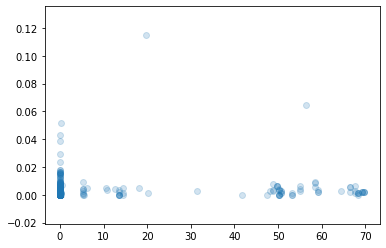

In [19]:
plt.scatter(missingDefault.missRate, missingDefault.impQ75Pond, alpha=0.2)

<BarContainer object of 202 artists>

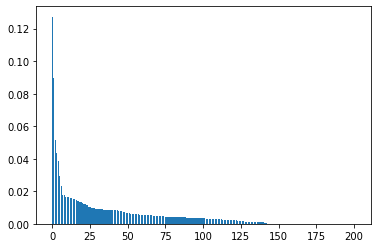

In [20]:
plt.bar([x for x in range(len(missingDefault))], missingDefault.impQ75.sort_values(ascending=False))

In [21]:
missingDefault = missingDefault.sort_values('impQ75Pond', ascending=False).reset_index(drop=True)
missingDefault

feature   missRate   impMean  impMedian  \
0                           EXT_SOURCE_3  19.828856  0.126054   0.125214   
1                           EXT_SOURCE_1  56.464598  0.088796   0.088785   
2                           EXT_SOURCE_2   0.213233  0.050563   0.050020   
3               BURO_AMT_CREDIT_SUM_DEBT   0.000000  0.040717   0.041236   
4          POSCASH_CNT_INSTALMENT_FUTURE   0.000000  0.037464   0.037543   
5                       BURO_DAYS_CREDIT   0.000000  0.027336   0.026679   
6                     PREV_DAYS_LAST_DUE   0.000000  0.020367   0.020134   
7                            AMT_ANNUITY   0.004646  0.015406   0.015431   
8           PREV_HOUR_APPR_PROCESS_START   0.000000  0.015628   0.015097   
9               BURO_DAYS_CREDIT_ENDDATE   0.000000  0.014191   0.015463   
10                 PREV_SELLERPLACE_AREA   0.000000  0.015239   0.015247   
11                  PREV_AMT_APPLICATION   0.000000  0.012812   0.012279   
12                       DAYS_ID_PUBLISH   0.000000  0.013348   0.012735   
13                         DAYS_EMPLOYED   0.000000  0.012640   0.012192   
14                       AMT_GOODS_PRICE   0.091519  0.012824   0.012716   
15                     DAYS_REGISTRATION   0.000000  0.012612   0.011310   
16                 PREV_AMT_DOWN_PAYMENT   0.000000  0.012557   0.012354   
17                   BURO_AMT_CREDIT_SUM   0.000000  0.010538   0.009997   
18     CREDCARD_CNT_DRAWINGS_ATM_CURRENT   0.000000  0.010779   0.008770   
19                POSCASH_MONTHS_BALANCE   0.000000  0.010608   0.011085   
20            REGION_POPULATION_RELATIVE   0.000000  0.011405   0.011217   
21                BURO_DAYS_ENDDATE_FACT   0.000000  0.011133   0.010874   
22                            DAYS_BIRTH   0.000000  0.008909   0.008437   
23               INSTALPAYMT_AMT_PAYMENT   0.000000  0.008854   0.008729   
24      CREDCARD_AMT_CREDIT_LIMIT_ACTUAL   0.000000  0.008888   0.008869   
25            INSTALPAYMT_AMT_INSTALMENT   0.000000  0.006988   0.007410   
26                 PREV_DAYS_TERMINATION   0.000000  0.006734   0.006328   
27                      BASEMENTAREA_AVG  58.466391  0.008740   0.009303   
28              PREV_PRODUCT_COMBINATION   5.333624  0.006991   0.006933   
29     INSTALPAYMT_NUM_INSTALMENT_NUMBER   0.000000  0.006491   0.006810   
30                            AMT_CREDIT   0.000000  0.006794   0.006474   
31               HOUR_APPR_PROCESS_START   0.000000  0.004318   0.002261   
32           BURO_AMT_CREDIT_MAX_OVERDUE   0.000000  0.007909   0.007259   
33                       FLAG_OWN_REALTY   0.000000  0.008485   0.008283   
34                     BASEMENTAREA_MEDI  58.466391  0.008512   0.009452   
35                       CNT_FAM_MEMBERS   0.000929  0.006929   0.006871   
36           PREV_NFLAG_LAST_APPL_IN_DAY   0.000000  0.007265   0.007719   
37          YEARS_BEGINEXPLUATATION_MODE  48.738020  0.008287   0.008113   
38        PREV_LAST_NAME_CONTRACT_STATUS   0.000000  0.007243   0.006918   
39                            FLAG_EMAIL   0.000000  0.007470   0.007183   
40                       NAME_TYPE_SUITE   0.419963  0.006898   0.007094   
41           REGION_RATING_CLIENT_W_CITY   0.000000  0.006967   0.006885   
42                POSCASH_CNT_INSTALMENT   0.000000  0.004146   0.002943   
43                      PREV_CNT_PAYMENT   0.000000  0.006089   0.005497   
44                         FLOORSMAX_AVG  49.705236  0.003236   0.000864   
45                        FLOORSMAX_MEDI  49.705236  0.003898   0.001295   
46                        FLOORSMAX_MODE  49.705236  0.004387   0.004387   
47                      BURO_AMT_ANNUITY   0.000000  0.004831   0.004480   
48                REG_CITY_NOT_WORK_CITY   0.000000  0.002405   0.000000   
49               LIVE_CITY_NOT_WORK_CITY   0.000000  0.001886   0.000000   
50                     NONLIVINGAREA_AVG  55.090427  0.008732   0.008459   
51     CREDCARD_AMT_DRAWINGS_ATM_CURRENT   0.000000  0.005799   0.005025   
52   

#### Suppression de colonnes peu importantes avec un fort taux de valeurs manquantes

In [22]:
def_miss_col_to_del = []
for index, row in missingDefault.iterrows():
    if (index >= 50) & (row.missRate >= 40):
        def_miss_col_to_del.append(row.feature)

In [23]:
for col in def_miss_col_to_del:
    del dfApplicationDefault[col]
    missingDefault = missingDefault[~missingDefault['feature'].isin([col])]
del dfApplicationDefault['PREV_NAME_CASH_LOAN_PURPOSE']
missingDefault = missingDefault.reset_index(drop=True)

### Suppression de la moitié des variables restantes les moins importantes

In [24]:
dfApplicationDefaultSvg = dfApplicationDefault.copy()
dfApplicationWorkedSvg = dfApplicationWorked.copy()

In [25]:
#XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

In [26]:
dfApplicationDefault = dfApplicationDefaultSvg.copy()
dfApplicationWorked = dfApplicationWorkedSvg.copy()

In [27]:
dfApplicationDefault = dfApplicationDefault.dropna()
dfApplicationWorked = dfApplicationWorked.dropna()
print(dfApplicationWorked.shape)
print(dfApplicationDefault.shape)

(49582, 62)
(18117, 161)


In [28]:
y_d = dfApplicationDefault['TARGET'].values
y_w = dfApplicationWorked['TARGET'].values
del dfApplicationDefault['TARGET']
del dfApplicationWorked['TARGET']
del dfApplicationDefault['SK_ID_CURR']
del dfApplicationWorked['SK_ID_CURR']

In [90]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder

# https://medium.com/@literallywords/sklearn-identity-transformer-fcc18bac0e98
from sklearn.base import BaseEstimator, TransformerMixin

class IdentityTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, input_array, y=None):
        return self
    
    def transform(self, input_array, y=None):
        return input_array*1

def transformDf(df1):
    
    df = df1.copy()
    
    for col in list(df.select_dtypes(include=['int64','float64']).columns):
            df[col] = SimpleImputer(strategy='mean').fit_transform(df[[col]])
            
    for col in list(df.select_dtypes(include=['int64','float64']).columns):
        if df.nunique()[col] > 100:
            df[col] = df[col].astype('float64')
        else:
            df[col] = df[col].astype('int64')            
        
    numerical_ix = df.select_dtypes(include=['float64']).columns
    integer_ix = df.select_dtypes(include=['int64']).columns
    categorical_ix = df.select_dtypes(include=['object', 'bool']).columns
    
    df[categorical_ix] = df[categorical_ix].replace(np.nan, 'missing')
    
    for col in df.columns:
        if df[col].dtypes == 'object':
            df[col] = OrdinalEncoder().fit_transform(df[[col]])
        elif df[col].dtype in ['int64','float64']:
            df[col] = MinMaxScaler().fit_transform(df[[col]])
            
    for col in list(df.select_dtypes(include=['int64','float64']).columns):
        if df.nunique()[col] > 100:
            df[col] = df[col].astype('float64')
        else:
            df[col] = df[col].astype('int64')    
            
    # ne marche pas???
    if False:  
        for col in list(categorical_ix):
            ordinal_encoder = OrdinalEncoder()
            df[col] = ordinal_encoder.fit_transform(df[col])

        for col in list(numerical_ix):
            df[col] = MinMaxScaler().fit_transform(df[col])

        for col in df.columns:
            if dfApplicationDefaultMiss[col].dtypes == 'object':
                ordinal_encoder = OrdinalEncoder()
                df[col] = ordinal_encoder.fit_transform(df[[col]])
             
    # change l'ordre des colonnes
    if False:
        #t = [('cat', OneHotEncoder(handle_unknown='ignore'), categorical_ix), ('num', MinMaxScaler(), numerical_ix)]
        t = [('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-10), categorical_ix), ('num', MinMaxScaler(), numerical_ix), ('int', MinMaxScaler(), integer_ix)]
        col_transform = ColumnTransformer(transformers=t)
        pipeline = Pipeline(steps=[('prep',col_transform), ('i', SimpleImputer(strategy='mean'))])

        t = [('cat', OrdinalEncoder(), categorical_ix), ('num', MinMaxScaler(), numerical_ix), ('int', IdentityTransformer(), integer_ix)]
        col_transform = ColumnTransformer(transformers=t)
        pipeline = Pipeline(steps=[('prep',col_transform)])
    
        return pd.DataFrame(pipeline.fit_transform(df), columns=df.columns)
        
    return df

In [30]:
dfApplicationWorked = transformDf(dfApplicationWorked)
dfApplicationDefault = transformDf(dfApplicationDefault)

#### Over et undersampling

In [50]:
def OverUnder(X, y):
    
    from imblearn.over_sampling import RandomOverSampler
    from imblearn.under_sampling import RandomUnderSampler
    from collections import Counter

    print(Counter(y))
    over = RandomOverSampler(sampling_strategy=0.3)
    X, y = over.fit_resample(X, y)
    print(Counter(y))
    under = RandomUnderSampler(sampling_strategy=0.5)
    X, y = under.fit_resample(X, y)
    print(Counter(y))
    
    return X, y

In [32]:
X_d = dfApplicationDefault.values
X_w = dfApplicationWorked.values

X_dcol = dfApplicationDefault.columns
X_wcol = dfApplicationWorked.columns

In [33]:
X_d, y_d = OverUnder(X_d, y_d)
X_w, y_w = OverUnder(X_w, y_w)

Counter({0: 16912, 1: 1205})
Counter({0: 16912, 1: 5073})
Counter({0: 10146, 1: 5073})
Counter({0: 45876, 1: 3706})
Counter({0: 45876, 1: 13762})
Counter({0: 27524, 1: 13762})


#### Calcul des feature importance

In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

def feat_imp(X, y, col, model=DecisionTreeClassifier()):

    i = 0
    for _ in np.arange(10):
        model.fit(X, y)
        imp = model.feature_importances_
        if i == 0:
            importance = pd.DataFrame(imp)
        else:
            importance = pd.concat([importance,pd.DataFrame(imp)], axis=1)
        i += 1
        
    statImp = pd.DataFrame(col, columns=['feature'])
    
    statImp['impMean'] = np.mean(importance, axis=1)
    statImp['impMedian'] = np.median(importance, axis=1)
    statImp['impQ75'] = np.quantile(importance, 0.75, axis=1)
    statImp['impMax'] = np.max(importance, axis=1)
    
    statImp = statImp.sort_values('impMedian', ascending=False).reset_index(drop=True).reset_index(drop=False)
    statImp = statImp.rename(columns={'index':'classement'})
    statImp['classement'] = statImp.apply(lambda x: x.classement+1, axis=1)
    
    return statImp


def feat_perm_imp(X, y, col, model=DecisionTreeClassifier()):
    
    from sklearn.inspection import permutation_importance
    model.fit(X, y)
    results = permutation_importance(model, X, y, scoring='roc_auc')
    importance = pd.DataFrame(results.importances_mean, columns=['perm_imp'])
    importance['feature'] = col
    importance = importance[['feature','perm_imp']]
    
    importance = importance.sort_values('perm_imp', ascending=False).reset_index(drop=True).reset_index(drop=False)
    importance = importance.rename(columns={'index':'perm_classement'})
    importance['perm_classement'] = importance.apply(lambda x: x.perm_classement+1, axis=1)
    
    return importance

In [35]:
perm_imp_d = feat_perm_imp(X_d, y_d, X_dcol, RandomForestClassifier(n_estimators=200, max_depth=5, n_jobs=-1))
perm_imp_w = feat_perm_imp(X_w, y_w, X_wcol, RandomForestClassifier(n_estimators=200, max_depth=5, n_jobs=-1))

imp_d = feat_imp(X_d, y_d, X_dcol, RandomForestClassifier(n_estimators=200, max_depth=5, n_jobs=-1))
imp_w = feat_imp(X_w, y_w, X_wcol, RandomForestClassifier(n_estimators=200, max_depth=5, n_jobs=-1))

In [36]:
imp_d = imp_d.merge(perm_imp_d, left_on='feature', right_on='feature')
imp_w = imp_w.merge(perm_imp_w, left_on='feature', right_on='feature')
imp_d['diff_classement'] = imp_d.apply(lambda x: np.abs(x.classement - x.perm_classement), axis=1)
imp_w['diff_classement'] = imp_w.apply(lambda x: np.abs(x.classement - x.perm_classement), axis=1)
imp_d['best_classement'] = imp_d.apply(lambda x: np.min([x.classement, x.perm_classement]), axis=1)
imp_w['best_classement'] = imp_w.apply(lambda x: np.min([x.classement, x.perm_classement]), axis=1)

Sur le jeu Worked

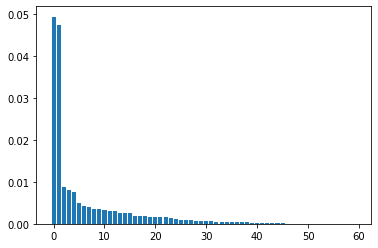

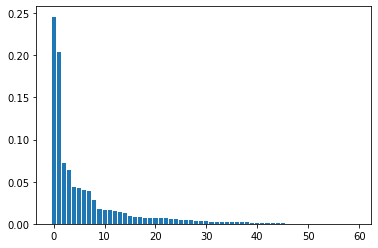

In [37]:
plt.bar([x for x in range(len(imp_w))], imp_w['perm_imp'].sort_values(ascending=False))
plt.show()
plt.bar([x for x in range(len(imp_w))], imp_w['impMedian'].sort_values(ascending=False))
plt.show()

In [38]:
for index, row in imp_w.iterrows():
    if row.best_classement > 30:
        del dfApplicationWorkedSvg[row.feature]

Sur le jeu par défaut

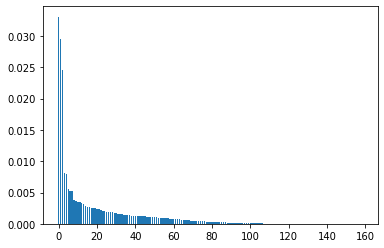

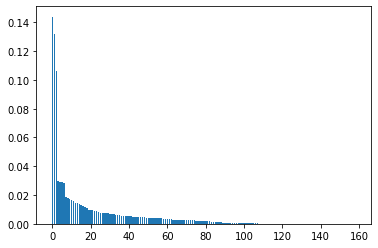

In [39]:
plt.bar([x for x in range(len(imp_d))], imp_d['perm_imp'].sort_values(ascending=False))
plt.show()
plt.bar([x for x in range(len(imp_d))], imp_d['impMedian'].sort_values(ascending=False))
plt.show()

In [40]:
for index, row in imp_d.iterrows():
    if row.best_classement > 80:
        del dfApplicationDefaultSvg[row.feature]

In [41]:
dfApplicationDefault = dfApplicationDefaultSvg.copy()
dfApplicationWorked = dfApplicationWorkedSvg.copy()

### Evaluation sur les deux jeux de données après purge des variables

In [48]:
# https://stackoverflow.com/questions/38787612/how-to-extract-feature-importances-from-an-sklearn-pipeline

def metrics_model(model, X_train, y_train, X_test, y_test, display_plot=False, calc_feat_imp = False, features = [], label_model = 'Modèle', dummy_strategy='constant', dummy_constant=1, cv=None):
    
    if cv == None:
        cv = cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        cv = 3
        
    # training
    date1 = time.time()
    model.fit(X_train,y_train)
    date2 = time.time()
    duration_training = date2 - date1

    # predicting on train set
    date1 = time.time()
    #y_prob = model.predict_proba(X_train)[:,1] 
    y_prob = cross_val_predict(model, X_train, y_train, cv=cv, method='predict_proba')[:,1] 
    date2 = time.time()
    duration_pred_train = date2 - date1

    # evaluating on train set
    date1 = time.time()
    fpr, tpr, thr = roc_curve(y_train, y_prob)
    roc_auc_train = auc(fpr, tpr)
    precision, recall, _ = precision_recall_curve(y_train, y_prob)
    pr_auc_train = auc(recall, precision)
    date2 = time.time()
    duration_metric_train = date2 - date1

    # predicting on test set
    date1 = time.time()
    #y_prob = model.predict_proba(X_test)[:,1] 
    y_prob = cross_val_predict(model, X_test, y_test, cv=cv, method='predict_proba')[:,1] 
    date2 = time.time()
    duration_pred_test = date2 - date1

    # evaluating on test set
    date1 = time.time()
    fpr, tpr, thr = roc_curve(y_test, y_prob)
    roc_auc_test = auc(fpr, tpr)
    precision, recall, threshold = precision_recall_curve(y_test, y_prob)
    pr_auc_test = auc(recall, precision)
    
    date2 = time.time()
    duration_metric_test = date2 - date1

    if calc_feat_imp:
        feature_imp = pd.DataFrame(features,model.feature_importances_).reset_index(drop=False)
        feature_imp.columns = ["importance",'feature']
        feature_imp = feature_imp.sort_values("importance", ascending=False)
    else:
        feature_imp = ''
        
    # no skill model
    model = DummyClassifier(strategy= dummy_strategy, constant=dummy_constant)
    model.fit(X_train, y_train)
    yhat = model.predict_proba(X_test)
    y_prob = yhat[:, 1]
    fpr_dummy, tpr_dummy, thr_dummy = roc_curve(y_test, y_prob)
    precision_dummy, recall_dummy, _ = precision_recall_curve(y_test, y_prob)
    roc_auc_dummy = auc(fpr_dummy, tpr_dummy)
    pr_auc_dummy = auc(recall_dummy, precision_dummy)
    
    print( ' Model ROC AUC: %.3f' % roc_auc_test) 
    print( ' No Skill ROC AUC: %.3f' % roc_auc_dummy)   
    print( ' Model PR AUC: %.3f' % pr_auc_test) 
    print( ' No Skill PR AUC: %.3f' % pr_auc_dummy)     
    
    if display_plot:
        
        import matplotlib.pyplot as plt
        import numpy as np
        
        size = 1
        if calc_feat_imp:
            nbPlot = 3
        else:
            nbPlot = 2
        fig = plt.figure(figsize=(size * (18 * nbPlot/2), size * 8))
        
        sub = fig.add_subplot(1,nbPlot,1)
        sub.set_title('ROC curve')
        plt.plot(fpr,tpr, color='red',label = 'AUC = %0.2f' % roc_auc_test)
        plt.plot(fpr_dummy,tpr_dummy, color='black', label = 'AUC dummy = %0.2f' % roc_auc_dummy)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],linestyle='--')
        plt.axis('tight')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        
        sub = fig.add_subplot(1,nbPlot,2)
        sub.set_title('Precision-Recall curve')
        plt.plot(recall, precision, color='red',label = 'AUC = %0.2f' % pr_auc_test)
        plt.plot(recall_dummy, precision_dummy, color='black', label = 'AUC dummy = %0.2f' % pr_auc_dummy)
        plt.legend(loc = 'lower right')
        plt.axis('tight')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        
           
        
        if calc_feat_imp:
            sub = fig.add_subplot(1,nbPlot,3)
            x = np.arange(len(features))
            #fig, ax = plt.subplots()
            #ax.yaxis.set_major_formatter(formatter)
            tmp = feature_imp.sort_values("importance", ascending=True)
            plt.barh(x, tmp.importance)
            plt.yticks(x, tmp.feature, rotation=0)
            sub.yaxis.tick_right()            
            plt.rcParams.update({'font.size':10, 'font.style':'normal'})
            sub.set_title('Feature importance')
        
        plt.rcParams.update({'font.size':12, 'font.style':'normal'})
        plt.suptitle(label_model)
        
        plt.show()
    
    return [duration_training, duration_pred_train, roc_auc_train, pr_auc_train, duration_pred_test, roc_auc_test, pr_auc_test, feature_imp]


In [43]:
from sklearn.datasets import make_classification
from sklearn.dummy import DummyClassifier
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)

X_train = X[0:7000]
y_train = y[0:7000]
X_test = X[7001:9999]
y_test = y[7001:9999]    
model = DummyClassifier(strategy= 'stratified', constant=1)
#model = DecisionTreeClassifier()
#model = RandomForestClassifier()

model.fit(X_train, y_train)
yhat = model.predict_proba(X_test)
y_prob = yhat[:, 1]
fpr_dummy, tpr_dummy, thr_dummy = roc_curve(y_test, y_prob)
precision_dummy, recall_dummy, _ = precision_recall_curve(y_test, y_prob)

Counter({0: 9900, 1: 100})


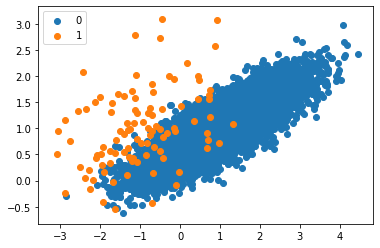

 Model ROC AUC: 0.945
 No Skill ROC AUC: 0.500
 Model PR AUC: 0.644
 No Skill PR AUC: 0.505


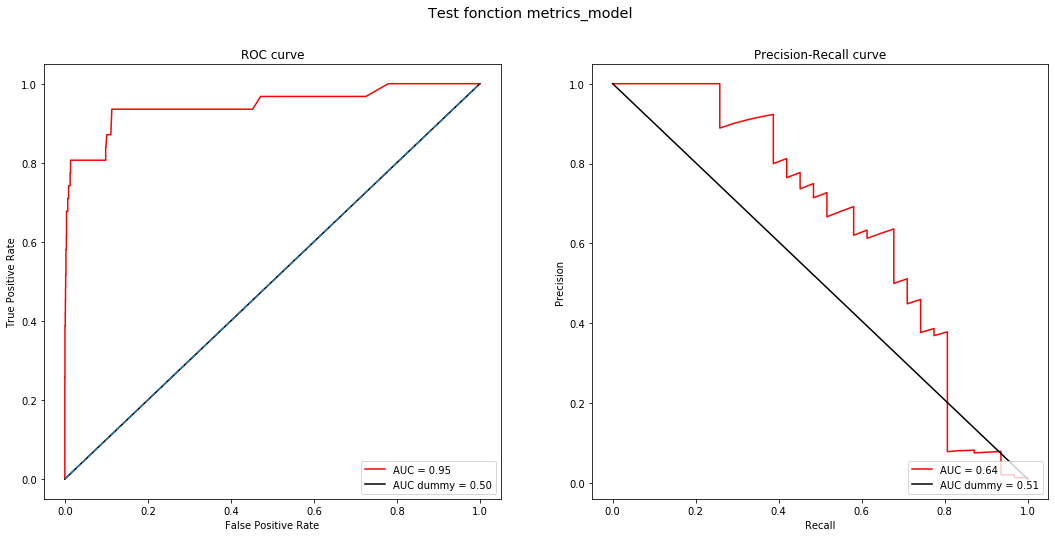

[0.36176156997680664,
 2.1530096530914307,
 0.4854486982450197,
 0.00928837833910004,
 1.053309440612793,
 0.9450134272698609,
 0.6444522697727633,
 '']

In [44]:
from sklearn.datasets import make_classification
from matplotlib import pyplot
from numpy import where

X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)
# summarize class distribution
counter = Counter(y)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = where(y == label)[0]
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

X_train = X[0:7000]
y_train = y[0:7000]
X_test = X[7001:9999]
y_test = y[7001:9999]

X_train, dfApplicationWorkedVal = train_test_split(X, test_size=0.3, random_state=1)
model = RandomForestClassifier(n_estimators=200, max_depth=5, n_jobs=-1)
#model = DecisionTreeClassifier(max_depth=5)
metrics_model(model, X_train, y_train, X_test, y_test, display_plot=True, calc_feat_imp = False, features = [], label_model = "Test fonction metrics_model")

 Model ROC AUC: 0.722
 No Skill ROC AUC: 0.500
 Model PR AUC: 0.210
 No Skill PR AUC: 0.540


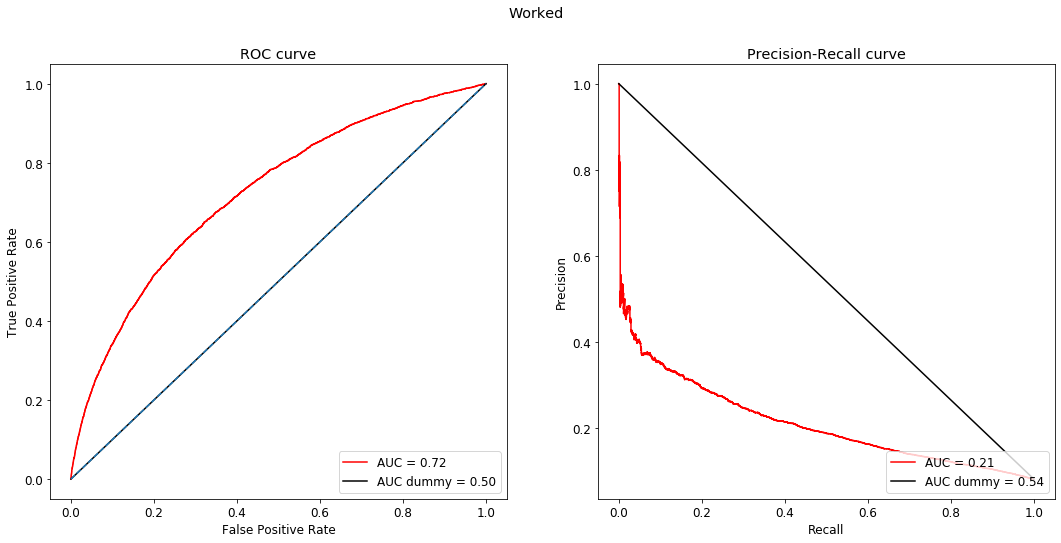

 Model ROC AUC: 0.732
 No Skill ROC AUC: 0.500
 Model PR AUC: 0.205
 No Skill PR AUC: 0.539


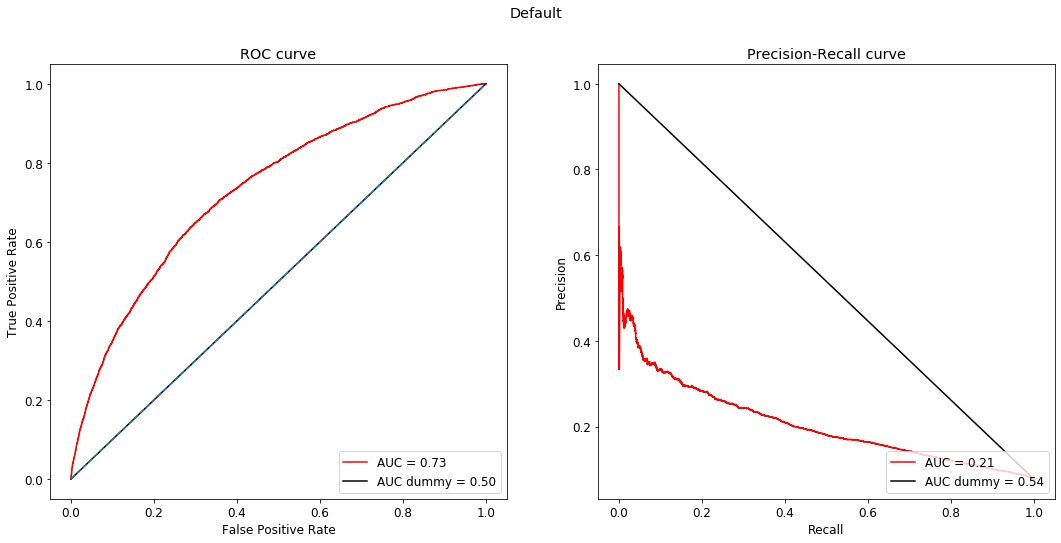

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from pickle import load

dicoDf = {'Worked':transformDf(dfApplicationWorked), 'Default': transformDf(dfApplicationDefault)}
for lbl, df in dicoDf.items():
    dfTrain, dfTest = train_test_split(df, test_size=0.2, random_state=1)
    y_train = dfTrain['TARGET'].values
    y_test = dfTest['TARGET'].values
    del dfTrain['TARGET']
    del dfTest['TARGET']
    del dfTrain['SK_ID_CURR']
    del dfTest['SK_ID_CURR']
    X_train = dfTrain.values
    X_test = dfTest.values
    
    #X_train, y_train = OverUnder(X_train, y_train)

    model = RandomForestClassifier(n_estimators=200, max_depth=5, n_jobs=-1)
    duration_training, duration_pred_train, roc_auc_train, pr_auc_train, duration_pred_test, roc_auc_test, pr_auc_test, feature_imp = metrics_model(model, X_train, y_train, X_test, y_test, display_plot=True, calc_feat_imp = False, features = [], label_model = lbl)

### Merge des deux jeux de données

In [46]:
dfApplicationDefault = dfApplicationDefaultSvg.copy()
dfApplicationWorked = dfApplicationWorkedSvg.copy()

In [47]:
dfApplicationDefaultBeforeMerge = dfApplicationDefaultSvg.copy()
dfApplicationWorkedBeforeMerge = dfApplicationWorkedSvg.copy()

In [48]:
for index, row in imp_d.sort_values('best_classement').iterrows():
    if row.best_classement < 15:
        if row.feature not in dfApplicationWorked.columns:
            dfApplicationWorked = dfApplicationWorked.merge(dfApplicationDefault[['SK_ID_CURR',row.feature]], left_on='SK_ID_CURR', right_on='SK_ID_CURR')
            dfApplicationWorked = dfApplicationWorked.rename(columns={row.feature:'DEFAULT_'+row.feature})
dfApplicationWorkedSvg = dfApplicationWorked.copy()

### Métriques avec et sans Over-Under sampling

 Model ROC AUC: 0.727
 No Skill ROC AUC: 0.500
 Model PR AUC: 0.212
 No Skill PR AUC: 0.540


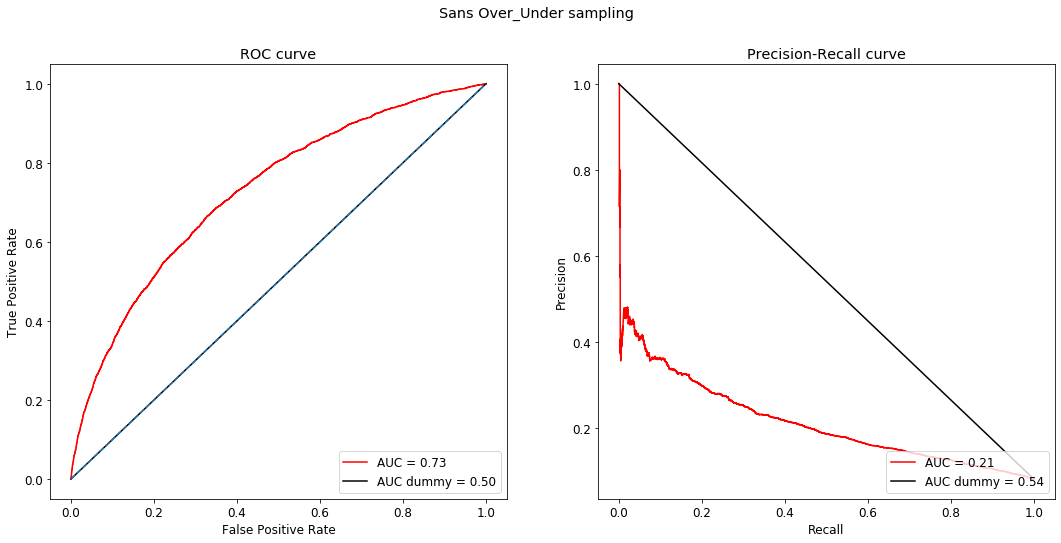

Counter({0: 158327, 1: 13878})
Counter({0: 158327, 1: 47498})
Counter({0: 94996, 1: 47498})
 Model ROC AUC: 0.727
 No Skill ROC AUC: 0.500
 Model PR AUC: 0.212
 No Skill PR AUC: 0.540


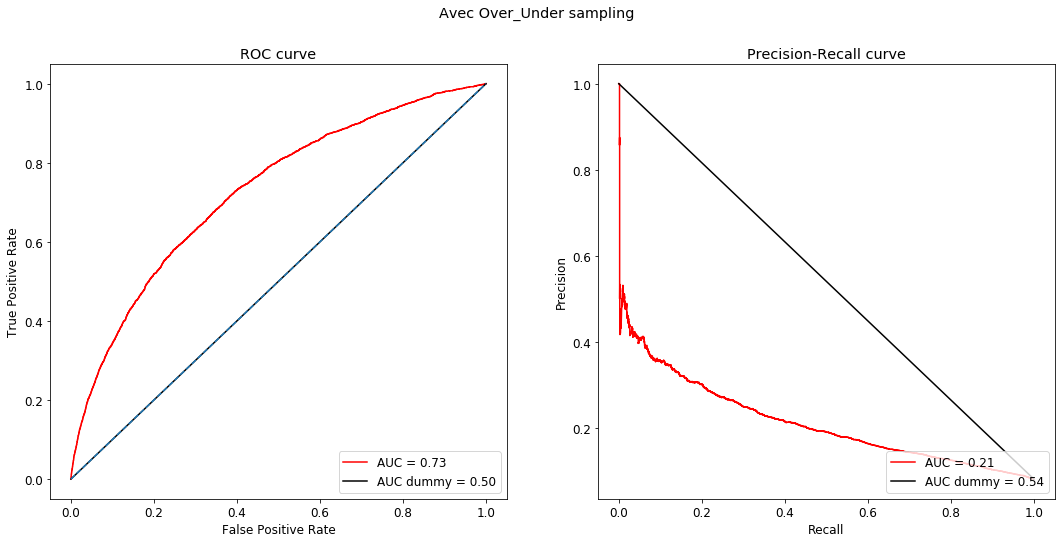

[8.889298915863037,
 18.335331439971924,
 0.7466567802998914,
 0.5939898770155858,
 4.757993936538696,
 0.7265749845182533,
 0.21221288127339488,
 '']

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from pickle import load

df = transformDf(dfApplicationWorked)

dfTrain, dfTest = train_test_split(df, test_size=0.2, random_state=1)
y_train = dfTrain['TARGET'].values
y_test = dfTest['TARGET'].values
del dfTrain['TARGET']
del dfTest['TARGET']
del dfTrain['SK_ID_CURR']
del dfTest['SK_ID_CURR']
X_train = dfTrain.values
X_test = dfTest.values
    
model = RandomForestClassifier(n_estimators=200, max_depth=5, n_jobs=-1)
metrics_model(model, X_train, y_train, X_test, y_test, display_plot=True, calc_feat_imp = False, features = [], label_model = 'Sans Over_Under sampling')

    
X_train, y_train = OverUnder(X_train, y_train)

model = RandomForestClassifier(n_estimators=200, max_depth=5, n_jobs=-1)
metrics_model(model, X_train, y_train, X_test, y_test, display_plot=True, calc_feat_imp = False, features = [], label_model = 'Avec Over_Under sampling')

## Feature importance sur le jeu de données mergé et nouvelle sélection de variables

Counter({0: 197899, 1: 17358})
Counter({0: 197899, 1: 59369})
Counter({0: 118738, 1: 59369})


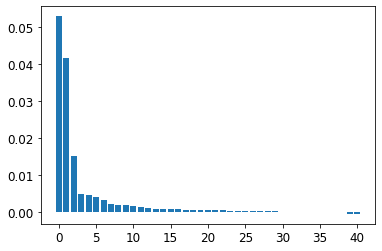

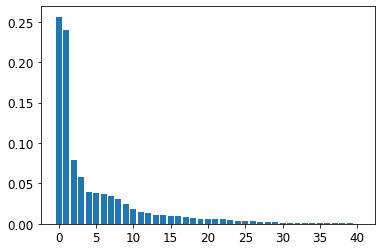

In [50]:
dfApplicationWorked = dfApplicationWorkedSvg.copy()
y = dfApplicationWorked['TARGET'].values
del dfApplicationWorked['TARGET']
del dfApplicationWorked['SK_ID_CURR']

dfApplicationWorked = transformDf(dfApplicationWorked)

X = dfApplicationWorked.values
X_col = dfApplicationWorked.columns
X, y = OverUnder(X, y)
model = RandomForestClassifier(n_estimators=200, max_depth=5, n_jobs=-1)
perm_imp = feat_perm_imp(X, y, X_col, model)
imp = feat_imp(X, y, X_col, model)
imp = imp.merge(perm_imp, left_on='feature', right_on='feature')
imp['diff_classement'] = imp.apply(lambda x: np.abs(x.classement - x.perm_classement), axis=1)
imp['best_classement'] = imp.apply(lambda x: np.min([x.classement, x.perm_classement]), axis=1)
plt.bar([x for x in range(len(imp))], imp['perm_imp'].sort_values(ascending=False))
plt.show()
plt.bar([x for x in range(len(imp))], imp['impMedian'].sort_values(ascending=False))
plt.show()

In [51]:
imp.sort_values('best_classement', ascending=True)

classement                                        feature   impMean  \
0            1                                   EXT_SOURCE_2  0.253026   
1            2                                   EXT_SOURCE_3  0.245895   
2            3                           DEFAULT_EXT_SOURCE_1  0.078843   
3            4                               BURO_DAYS_CREDIT  0.057904   
4            5   INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS  0.039078   
6            7                                     DAYS_BIRTH  0.037176   
5            6  INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG  0.037925   
9           10                      PREV_NAME_CONTRACT_STATUS  0.024048   
7            8                                 PREV_DAYS_DIFF  0.034937   
14          15                                    CODE_GENDER  0.010917   
8            9                DEFAULT_BURO_DAYS_CREDIT_UPDATE  0.032121   
13          14                          PREV_NAME_YIELD_GROUP  0.010912   
10          11                       BURO_DAYS_CREDIT_ENDDATE  0.018359   
11          12                                  DAYS_EMPLOYED  0.015142   
21          22          DEFAULT_POSCASH_CNT_INSTALMENT_FUTURE  0.005568   
17          18                        DEFAULT_AMT_GOODS_PRICE  0.008217   
12          13                 DEFAULT_BURO_DAYS_ENDDATE_FACT  0.013899   
22          23                  DEFAULT_PREV_AMT_DOWN_PAYMENT  0.005466   
23          24                       DEFAULT_PREV_CNT_PAYMENT  0.005257   
19          20                    BURO_AMT_CREDIT_MAX_OVERDUE  0.005741   
15          16                             BURO_CREDIT_ACTIVE  0.009962   
20          21               DEFAULT_PREV_PRODUCT_COMBINATION  0.005645   
16          17                              ORGANIZATION_TYPE  0.009616   
18          19                             PREV_DAYS_DECISION  0.007216   
26          27                                     AMT_CREDIT  0.003330   
24          25                    POSCASH_NB_POS_CASH_BALANCE  0.003670   
25          26                  DIFF_DAYS_INSTALLMENT_PAYMENT  0.003503   
28          29                    DEFAULT_PREV_NAME_PORTFOLIO  0.002299   
32          33                           RATIO_ANNUITY_INCOME  0.001199   
29          30           DEFAULT_PREV_HOUR_APPR_PROCESS_START  0.001754   
27          28                        POSCASH_SK_DPD_POS_CASH  0.002499   
31          32                             NAME_CONTRACT_TYPE  0.001277   
34          35                   YEARS_BEGINEXPLUATATION_MODE  0.001178   
30          31                            PREV_AMT_CREDIT_LOG  0.001326   
35          36                         PREV_RATE_DOWN_PAYMENT  0.001031   
33          34                        PREV_AMT_CREDIT_STD_LOG  0.001251   
37          38                      BURO_AMT_CREDIT_SUM_LIMIT  0.000766   
39          40                           AMT_INCOME_TOTAL_LOG  0.000524   
36          37  INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_POS  0.000805   
38          39                                APARTMENTS_MODE  0.000523   
40          41                      PREV_MAIN_SELLER_INDUSTRY  0.000194   

    impMedian    impQ75    impMax  perm_classement  perm_imp  diff_classement  \
0    0.256309  0.259993  0.272893                1  0.052884                0   
1    0.240077  0.248051  0.273554                2  0.041625                0   
2    0.078664  0.085450  0.088882                3  0.015030                0   
3    0.057362  0.061286  0.069407               24  0.000367               20   
4    0.038990  0.040971  0.042454                4  0.004927                1   
6    0.037461  0.038758  0.039647                5  0.004658                2   
5    0.037668  0.038966  0.042356                6  0.004201                0   
9    0.023981  0.024431  0.028433                7  0.003329                3   
7    0.034861  0.036618  0.041840                9  0.001895                1   
14   0.010565  0.011585  0.014084          

In [52]:
for index, row in imp.iterrows():
    if (row.perm_classement > 15) & (row.classement > 20):
        del dfApplicationWorkedSvg[row.feature]

In [59]:
if False:
    from pickle import dump
    dump(dfApplicationWorkedSvg, open('ApplicationWorked.pkl','wb'))

## Détection des outliers

In [7]:
from pickle import load
dfApplicationWorked = load(open('ApplicationWorked_with_outliers.pkl','rb'))
dfApplicationWorkedSvg = dfApplicationWorked.copy()

In [2]:
def removeOutliers(df):
    from numpy import percentile
    numerical_ix = list(df.select_dtypes(include=[ 'float64','int64']).columns)
    print(df.shape)
    for col in numerical_ix:
        dataCol = df[~df[col].isnull()][col]
        q25, q75 = percentile(dataCol, 25), percentile(dataCol, 75)
        iqr = q75 - q25
        cut_off = iqr * 1.5
        lower, upper = q25 - cut_off, q75 + cut_off
        df = df[((df[col] >= lower) & (df[col] <= upper)) | df[col].isnull()]
        print('{}: {}'.format(col, df.shape[0]))
    return df

In [3]:
def statsOutliers(df):
    from numpy import percentile
    numerical_ix = list(df.select_dtypes(include=['float64','int64']).columns)
    dico = {}
    for col in numerical_ix:
        dataCol = df[~df[col].isnull()][col]
        q25, q75 = percentile(dataCol, 25), percentile(dataCol, 75)
        iqr = q75 - q25
        cut_off = iqr * 1.5
        lower, upper = q25 - cut_off, q75 + cut_off
        if df[((df[col] < lower) | (df[col] > upper))].shape[0] > 0:
            dico[col] = df[((df[col] < lower) | (df[col] > upper))].shape[0]
        
    return dico

In [93]:
statOutlier = statsOutliers(dfApplicationWorked)
statOutlier = pd.DataFrame({'feature': pd.Series(list(statOutlier.keys())), 'nb_outliers': pd.Series(list(statOutlier.values()))}).sort_values('nb_outliers', ascending=False)


---------------------------------------------------------------------
BURO_AMT_CREDIT_MAX_OVERDUE:49316


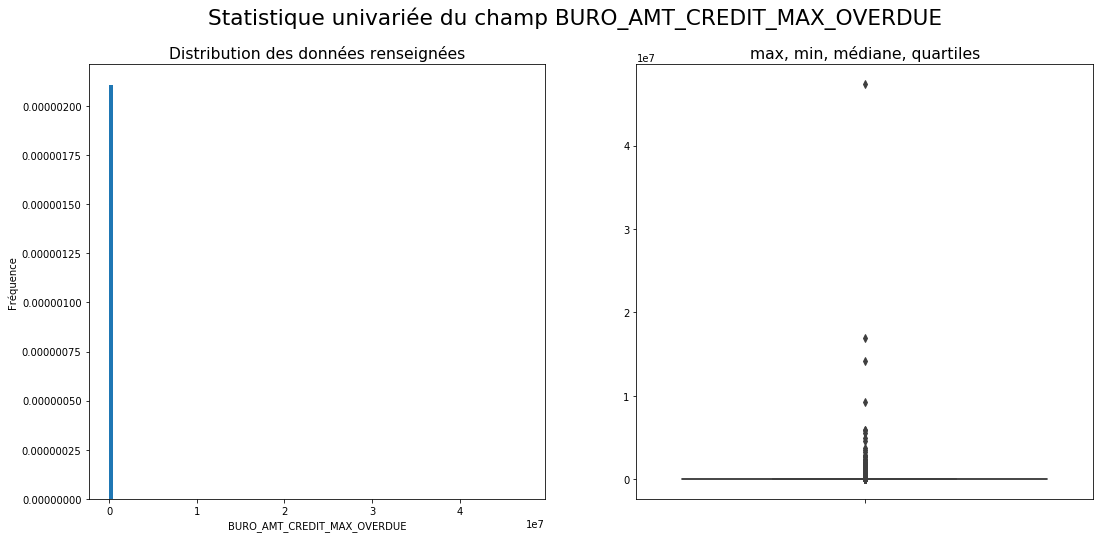

Mesures de position
 - Moyenne: 2759.67
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 120831.82
 - Min: 0.0
 - Q25: 0.0
 - Q75: 0.0
 - Max: 47406123.0
Mesures de forme
 - Skewness (asymétrie): 305.75
 - Kurtosis (applatissement): 112969.99


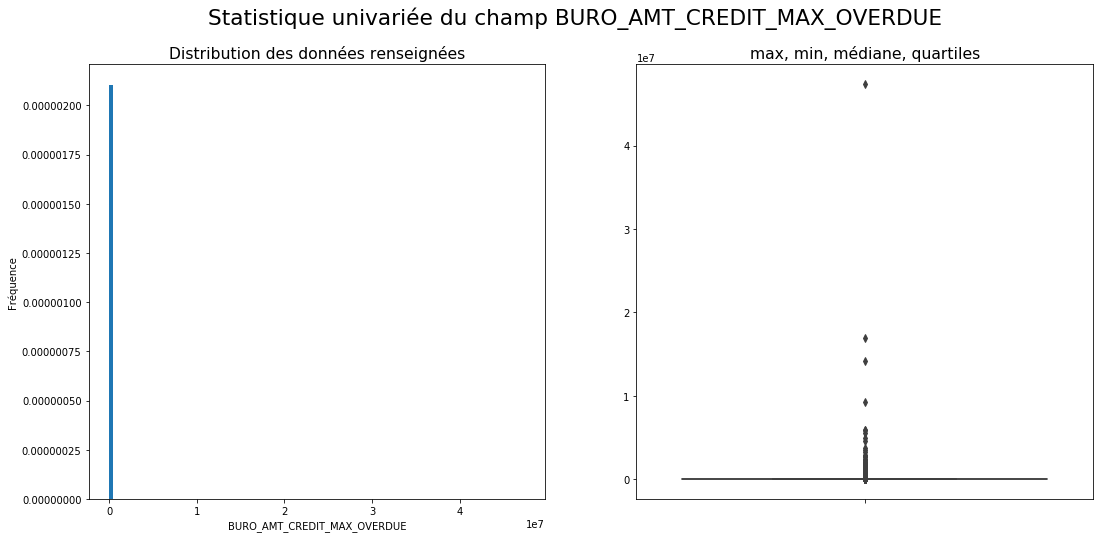

Mesures de position
 - Moyenne: 12045.57
 - Médiane: 3501.0
Mesures de dispertion
 - Ecart type: 252222.93
 - Min: 0.01
 - Q25: 1424.9
 - Q75: 7607.82
 - Max: 47406123.0
Mesures de forme
 - Skewness (asymétrie): 146.62
 - Kurtosis (applatissement): 25948.93

---------------------------------------------------------------------
BURO_CREDIT_ACTIVE:30923


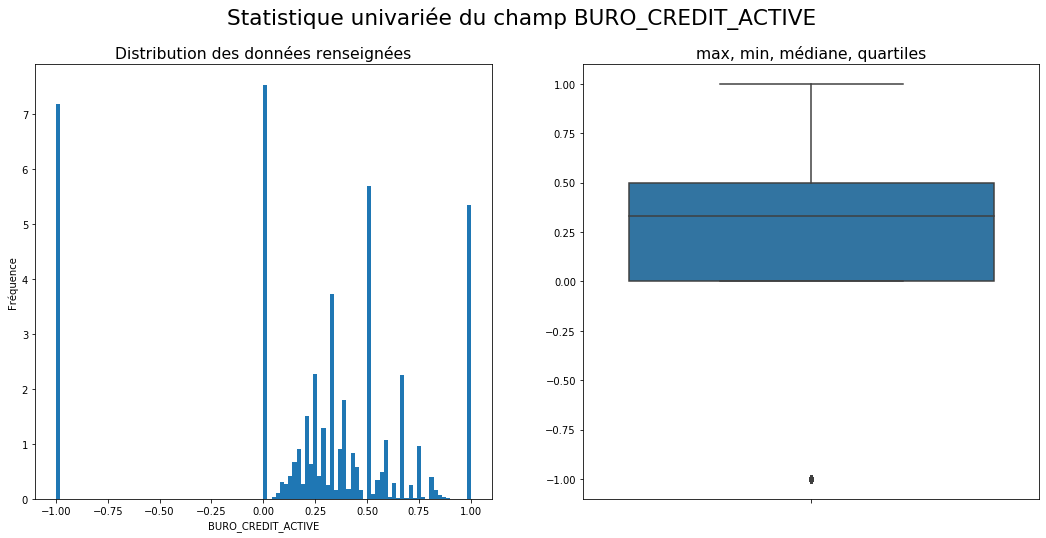

Mesures de position
 - Moyenne: 0.21
 - Médiane: 0.33
Mesures de dispertion
 - Ecart type: 0.57
 - Min: -1.0
 - Q25: 0.0
 - Q75: 0.5
 - Max: 1.0
Mesures de forme
 - Skewness (asymétrie): -0.99
 - Kurtosis (applatissement): 0.34


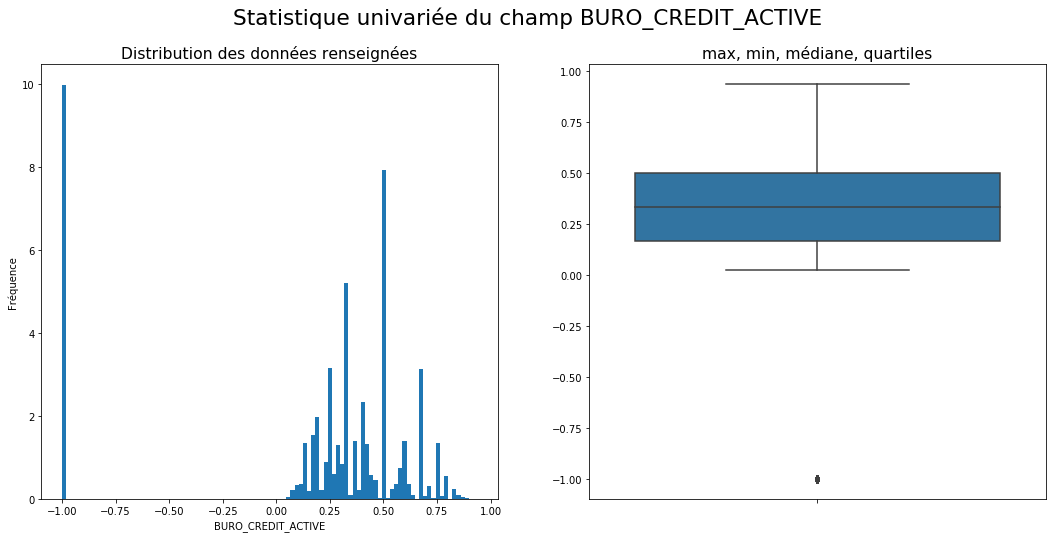

Mesures de position
 - Moyenne: 0.14
 - Médiane: 0.33
Mesures de dispertion
 - Ecart type: 0.58
 - Min: -1.0
 - Q25: 0.17
 - Q75: 0.5
 - Max: 0.94
Mesures de forme
 - Skewness (asymétrie): -1.27
 - Kurtosis (applatissement): 0.04

---------------------------------------------------------------------
INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG:28672


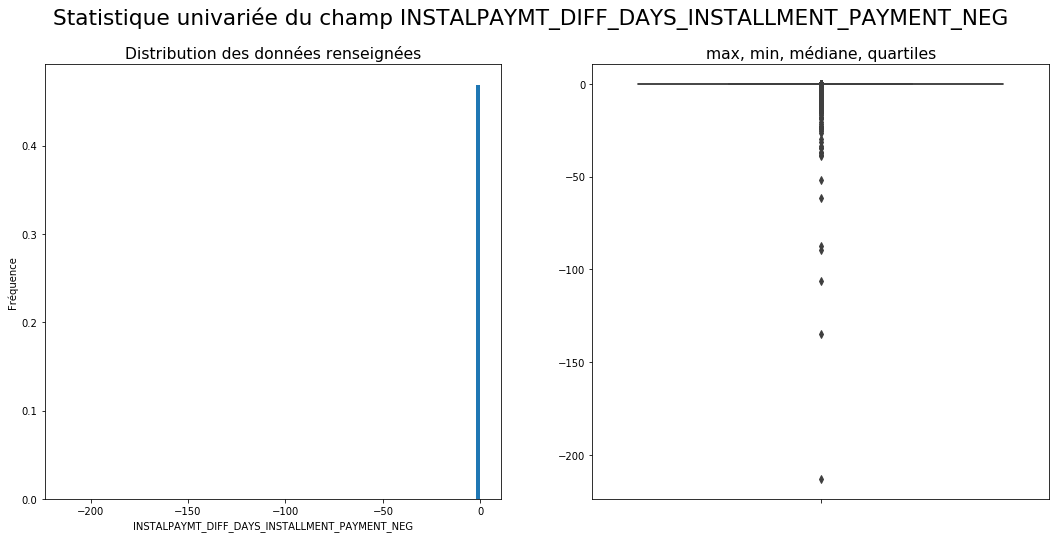

Mesures de position
 - Moyenne: -0.04
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 0.77
 - Min: -212.98
 - Q25: -0.02
 - Q75: 0.0
 - Max: 0.0
Mesures de forme
 - Skewness (asymétrie): -162.18
 - Kurtosis (applatissement): 36127.87


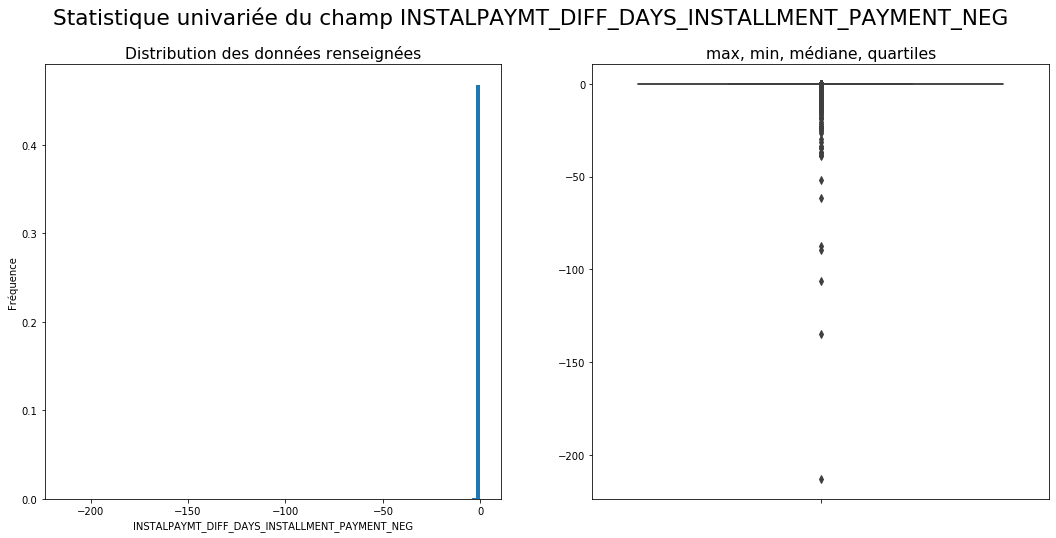

Mesures de position
 - Moyenne: -0.08
 - Médiane: -0.02
Mesures de dispertion
 - Ecart type: 1.09
 - Min: -212.98
 - Q25: -0.05
 - Q75: -0.01
 - Max: -0.0
Mesures de forme
 - Skewness (asymétrie): -113.68
 - Kurtosis (applatissement): 17718.95

---------------------------------------------------------------------
BURO_DAYS_CREDIT_ENDDATE:27161


Mesures de position
 - Moyenne: 559.01
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 3051.48
 - Min: -41875.0
 - Q25: -593.17
 - Q75: 404.33
 - Max: 31198.0
Mesures de forme
 - Skewness (asymétrie): 5.35
 - Kurtosis (applatissement): 40.64


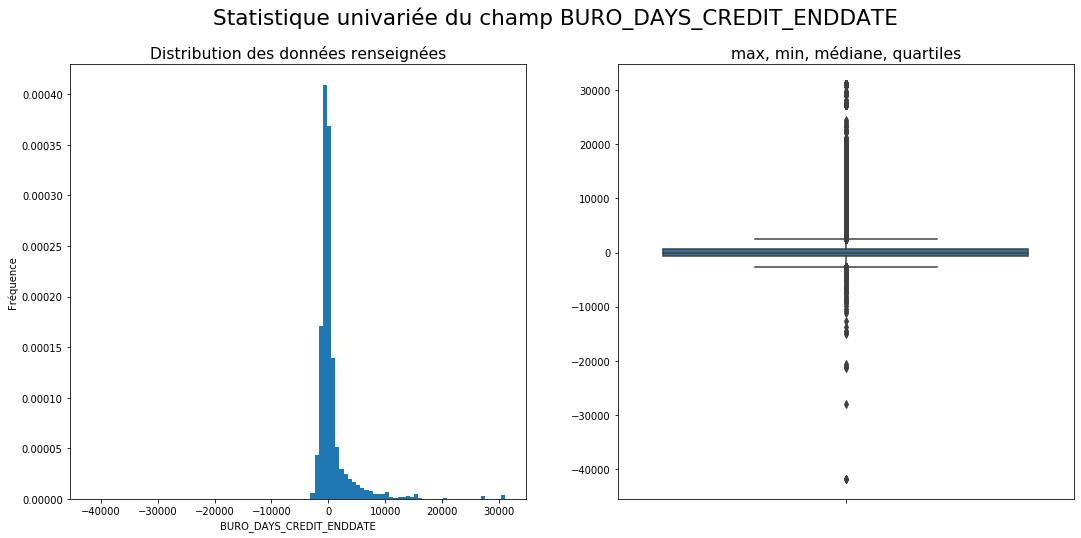

Mesures de position
 - Moyenne: 658.86
 - Médiane: -135.5
Mesures de dispertion
 - Ecart type: 3302.86
 - Min: -41875.0
 - Q25: -703.0
 - Q75: 602.5
 - Max: 31198.0
Mesures de forme
 - Skewness (asymétrie): 4.88
 - Kurtosis (applatissement): 33.87

---------------------------------------------------------------------
INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS:26101


Mesures de position
 - Moyenne: 0.0
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 0.0
 - Min: 0.0
 - Q25: 0.0
 - Q75: 0.0
 - Max: 0.1
Mesures de forme
 - Skewness (asymétrie): 3.8
 - Kurtosis (applatissement): 25.25


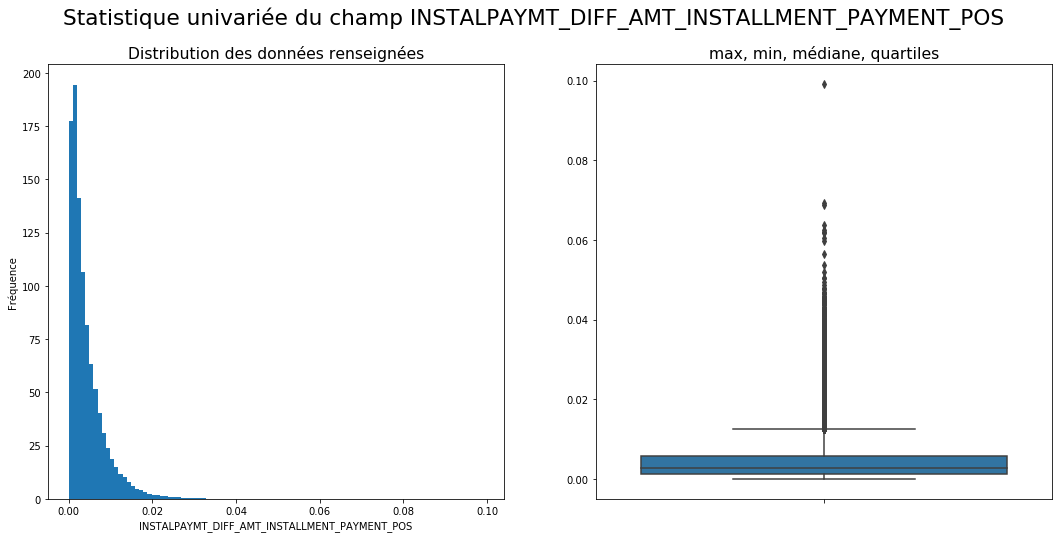

Mesures de position
 - Moyenne: 0.0
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 0.0
 - Min: 0.0
 - Q25: 0.0
 - Q75: 0.01
 - Max: 0.1
Mesures de forme
 - Skewness (asymétrie): 2.79
 - Kurtosis (applatissement): 15.46

---------------------------------------------------------------------
TARGET:17358



---------------------------------------------------------------------
DEFAULT_PREV_AMT_DOWN_PAYMENT:16070


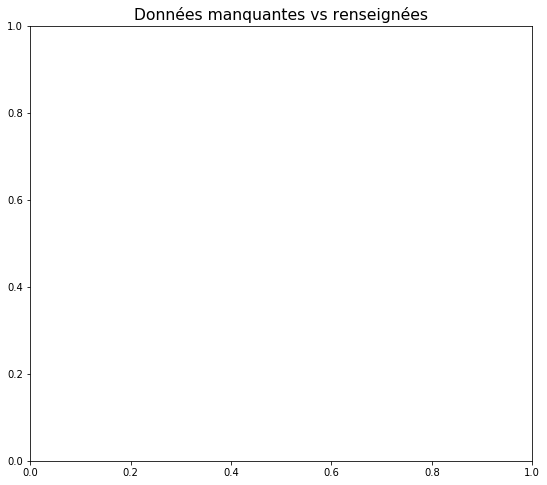

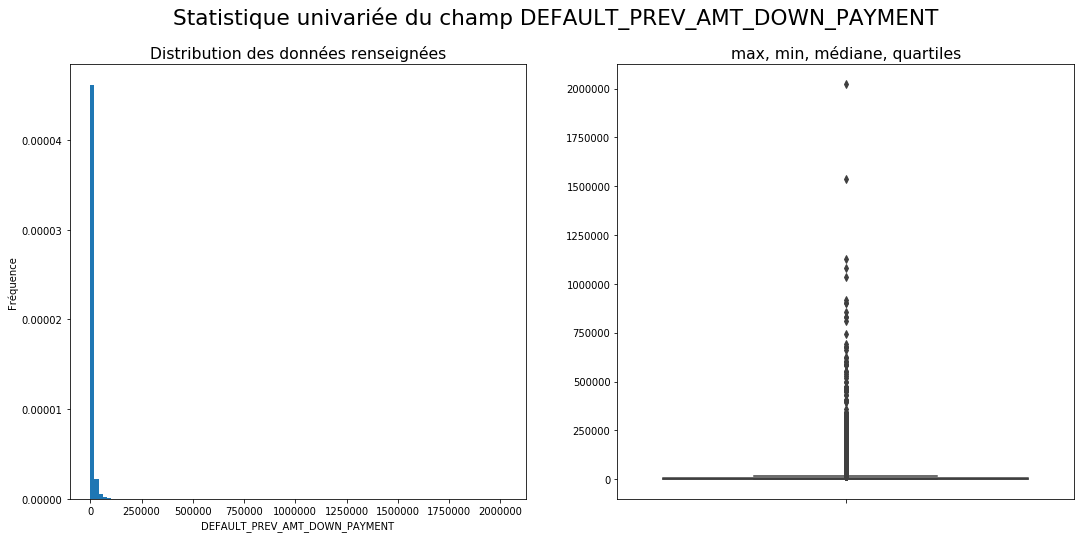

Mesures de position
 - Moyenne: 6306.11
 - Médiane: 2511.0
Mesures de dispertion
 - Ecart type: 17108.15
 - Min: -0.22
 - Q25: 0.0
 - Q75: 7318.12
 - Max: 2025000.0
Mesures de forme
 - Skewness (asymétrie): 28.18
 - Kurtosis (applatissement): 1858.39


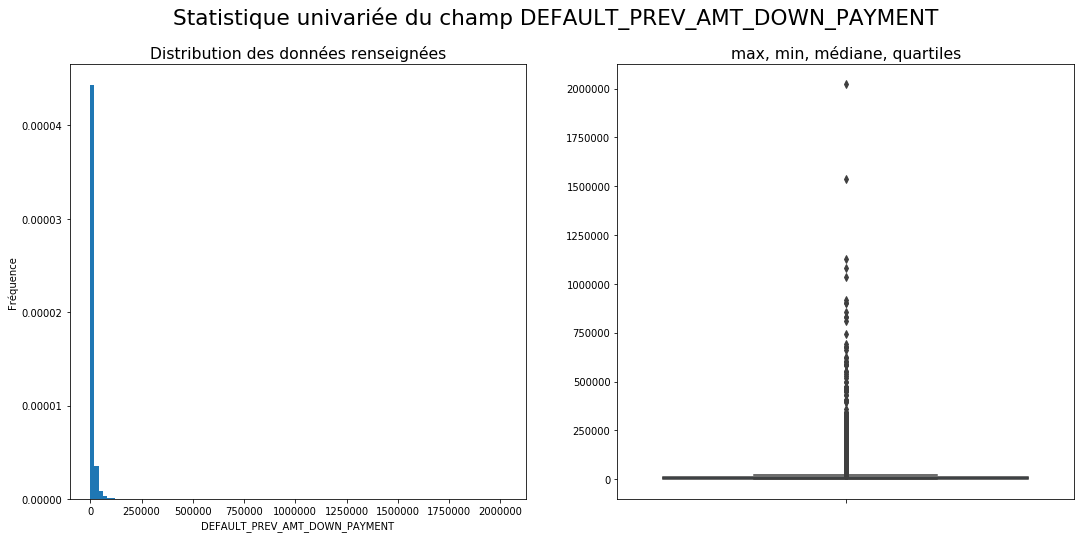

Mesures de position
 - Moyenne: 9856.98
 - Médiane: 5578.2
Mesures de dispertion
 - Ecart type: 20554.72
 - Min: -0.22
 - Q25: 2814.0
 - Q75: 10968.75
 - Max: 2025000.0
Mesures de forme
 - Skewness (asymétrie): 24.89
 - Kurtosis (applatissement): 1375.94

---------------------------------------------------------------------
DEFAULT_POSCASH_CNT_INSTALMENT_FUTURE:12766


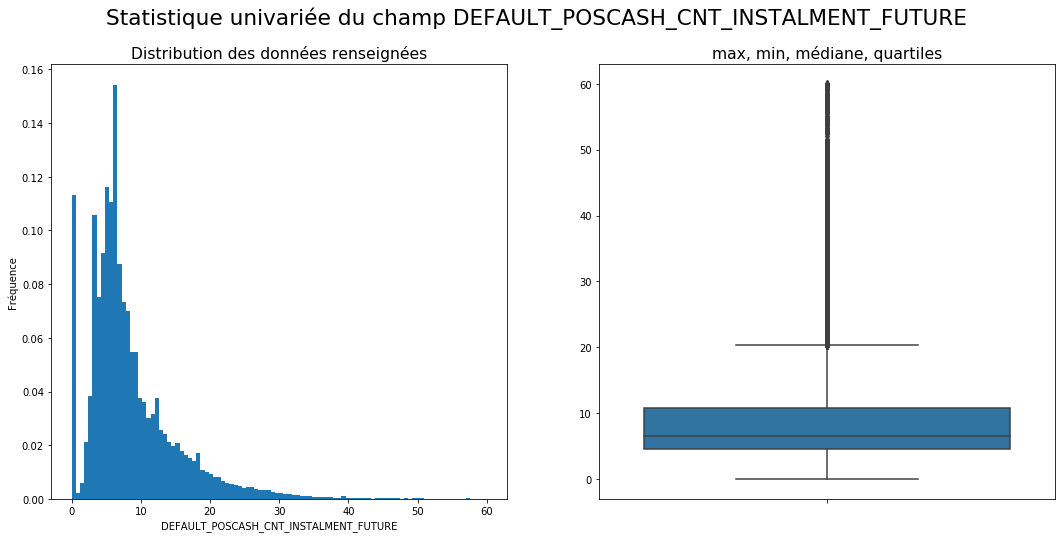

Mesures de position
 - Moyenne: 8.48
 - Médiane: 6.59
Mesures de dispertion
 - Ecart type: 6.56
 - Min: 0.0
 - Q25: 4.55
 - Q75: 10.85
 - Max: 60.0
Mesures de forme
 - Skewness (asymétrie): 1.88
 - Kurtosis (applatissement): 5.61


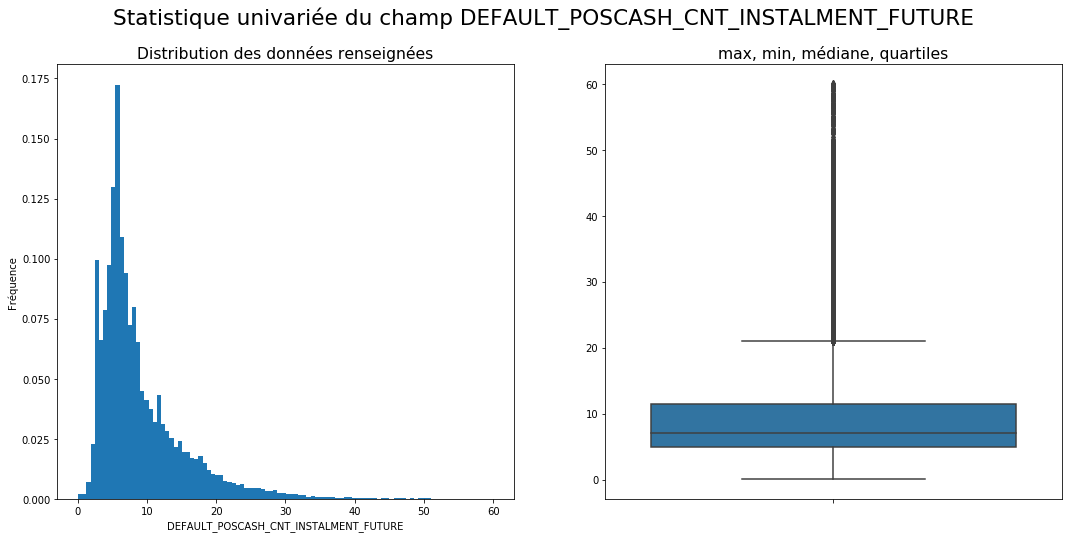

Mesures de position
 - Moyenne: 9.09
 - Médiane: 7.0
Mesures de dispertion
 - Ecart type: 6.37
 - Min: 0.08
 - Q25: 5.0
 - Q75: 11.4
 - Max: 60.0
Mesures de forme
 - Skewness (asymétrie): 2.08
 - Kurtosis (applatissement): 6.3

---------------------------------------------------------------------
PREV_NAME_CONTRACT_STATUS:12731


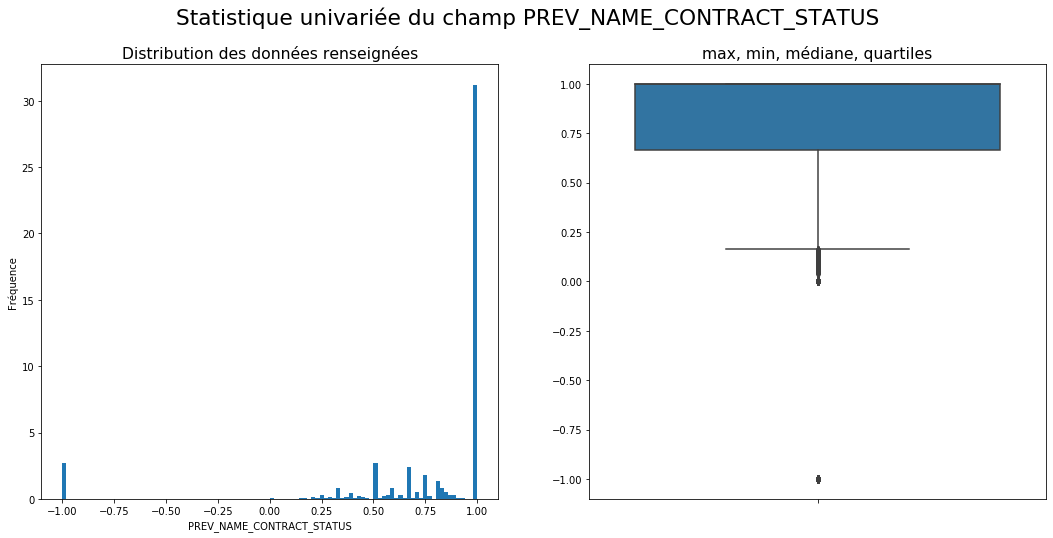

Mesures de position
 - Moyenne: 0.77
 - Médiane: 1.0
Mesures de dispertion
 - Ecart type: 0.47
 - Min: -1.0
 - Q25: 0.67
 - Q75: 1.0
 - Max: 1.0
Mesures de forme
 - Skewness (asymétrie): -2.85
 - Kurtosis (applatissement): 7.78


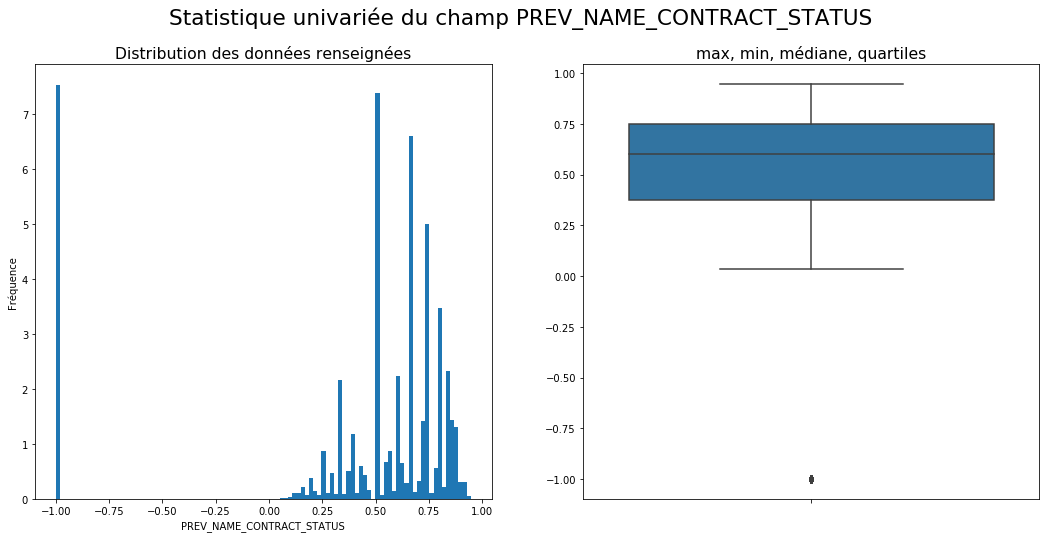

Mesures de position
 - Moyenne: 0.38
 - Médiane: 0.6
Mesures de dispertion
 - Ecart type: 0.6
 - Min: -1.0
 - Q25: 0.38
 - Q75: 0.75
 - Max: 0.95
Mesures de forme
 - Skewness (asymétrie): -1.69
 - Kurtosis (applatissement): 1.31

---------------------------------------------------------------------
DAYS_EMPLOYED:11790


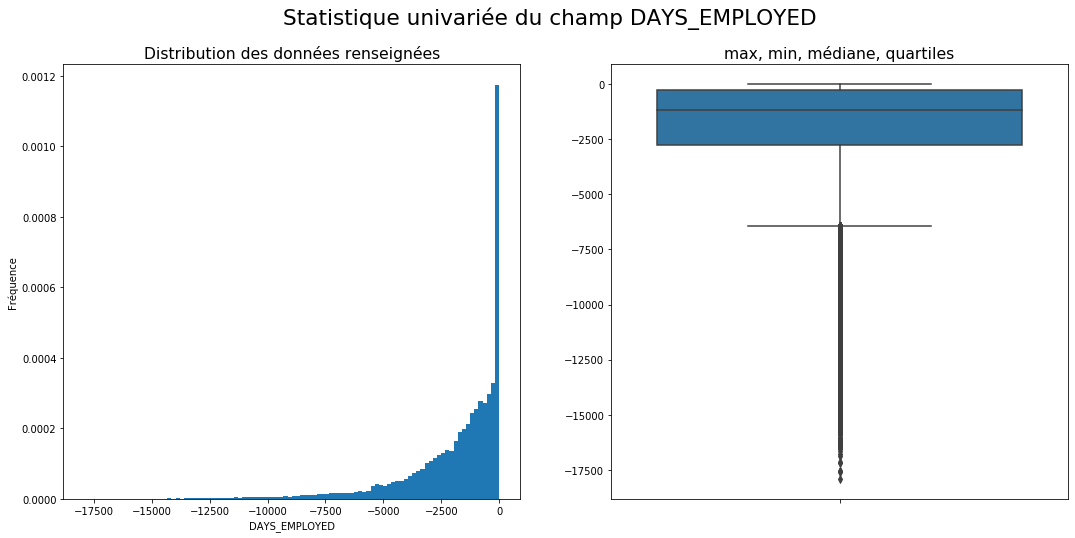

Mesures de position
 - Moyenne: -1950.48
 - Médiane: -1209.0
Mesures de dispertion
 - Ecart type: 2304.46
 - Min: -17912
 - Q25: -2754.0
 - Q75: -289.0
 - Max: 1
Mesures de forme
 - Skewness (asymétrie): -2.05
 - Kurtosis (applatissement): 5.24


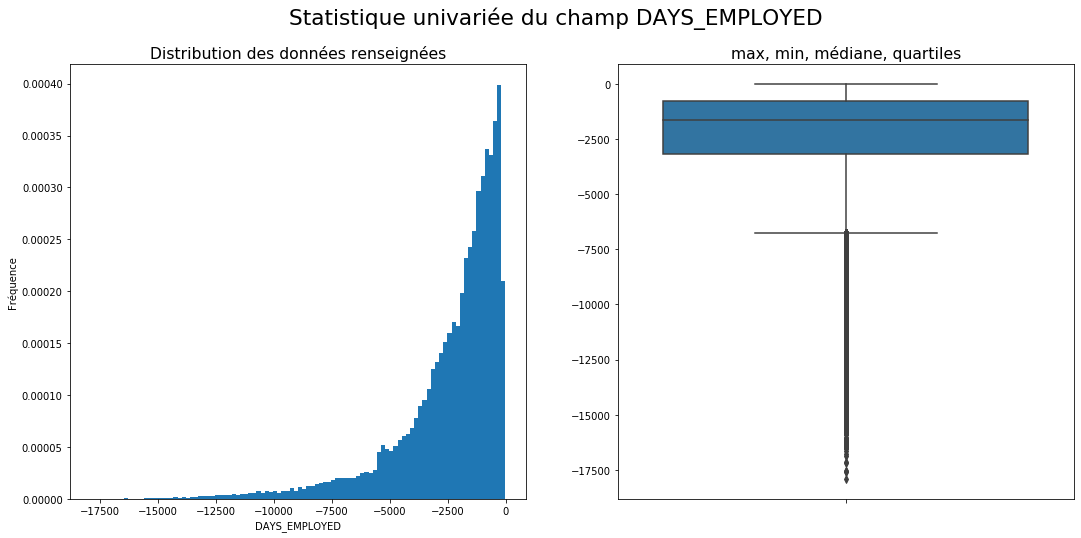

Mesures de position
 - Moyenne: -2379.72
 - Médiane: -1645.0
Mesures de dispertion
 - Ecart type: 2335.96
 - Min: -17912
 - Q25: -3167.0
 - Q75: -765.25
 - Max: -1
Mesures de forme
 - Skewness (asymétrie): -1.97
 - Kurtosis (applatissement): 4.77

---------------------------------------------------------------------
PREV_DAYS_DIFF:10551


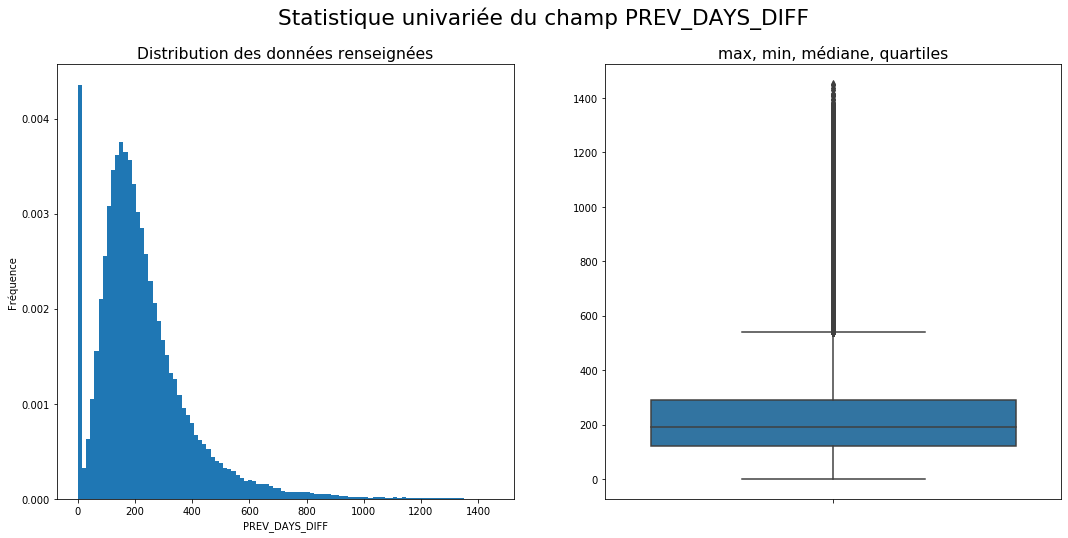

Mesures de position
 - Moyenne: 226.15
 - Médiane: 191.75
Mesures de dispertion
 - Ecart type: 166.34
 - Min: 0.0
 - Q25: 122.83
 - Q75: 290.33
 - Max: 1451.5
Mesures de forme
 - Skewness (asymétrie): 1.83
 - Kurtosis (applatissement): 5.78


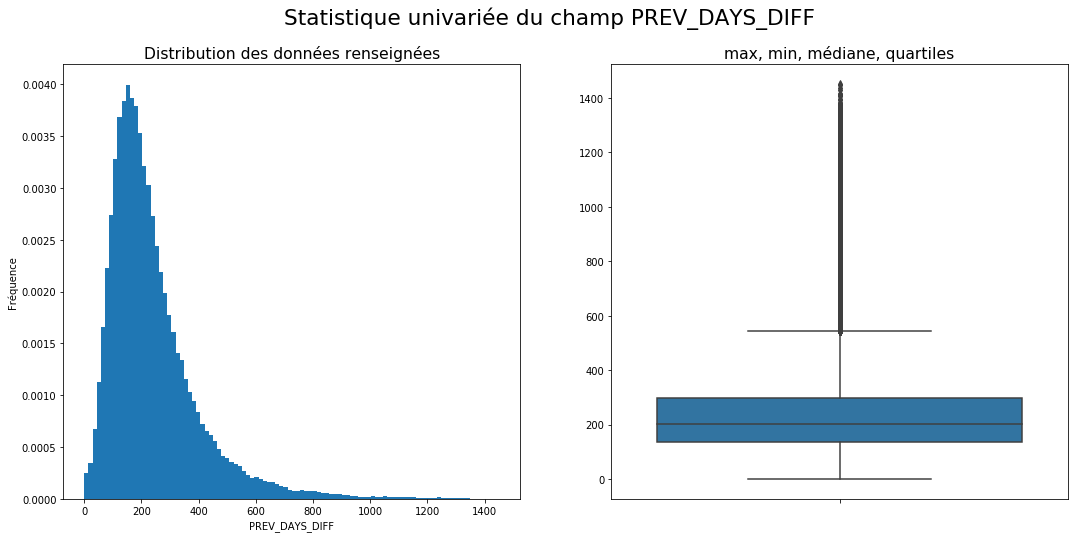

Mesures de position
 - Moyenne: 240.55
 - Médiane: 200.82
Mesures de dispertion
 - Ecart type: 161.15
 - Min: 0.17
 - Q25: 135.41
 - Q75: 299.17
 - Max: 1451.5
Mesures de forme
 - Skewness (asymétrie): 2.05
 - Kurtosis (applatissement): 6.57

---------------------------------------------------------------------
DEFAULT_AMT_GOODS_PRICE:10307


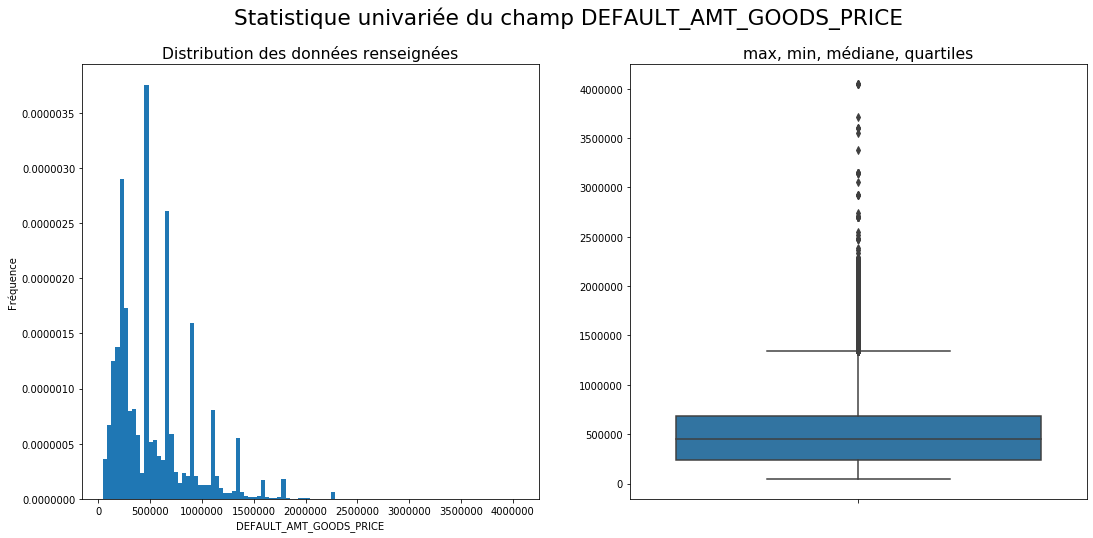

Mesures de position
 - Moyenne: 538187.97
 - Médiane: 450000.0
Mesures de dispertion
 - Ecart type: 369446.25
 - Min: 45000.0
 - Q25: 238500.0
 - Q75: 679500.0
 - Max: 4050000.0
Mesures de forme
 - Skewness (asymétrie): 1.35
 - Kurtosis (applatissement): 2.42


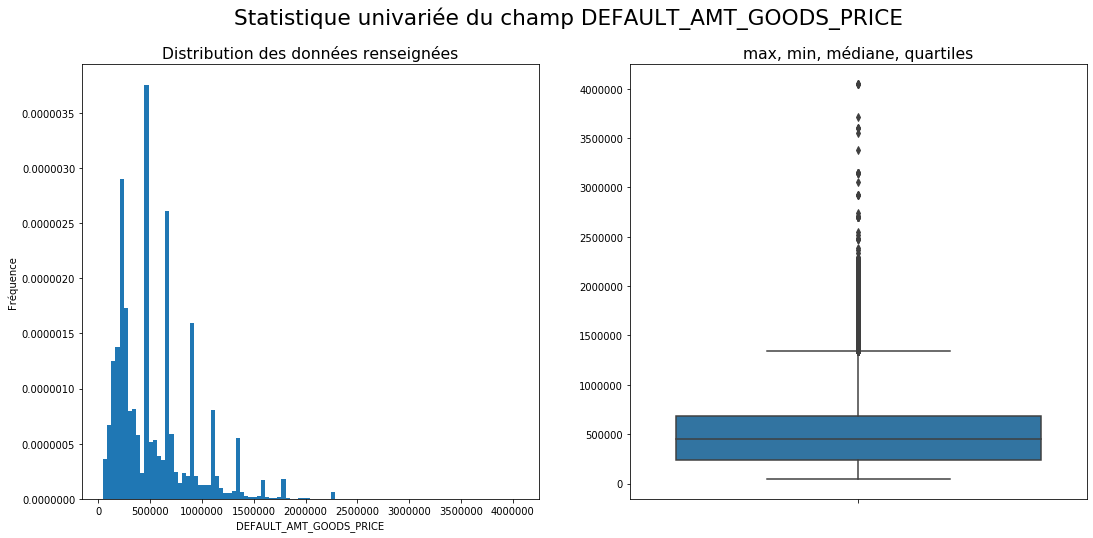

Mesures de position
 - Moyenne: 538187.97
 - Médiane: 450000.0
Mesures de dispertion
 - Ecart type: 369446.25
 - Min: 45000.0
 - Q25: 238500.0
 - Q75: 679500.0
 - Max: 4050000.0
Mesures de forme
 - Skewness (asymétrie): 1.35
 - Kurtosis (applatissement): 2.42

---------------------------------------------------------------------
DEFAULT_PREV_CNT_PAYMENT:8339


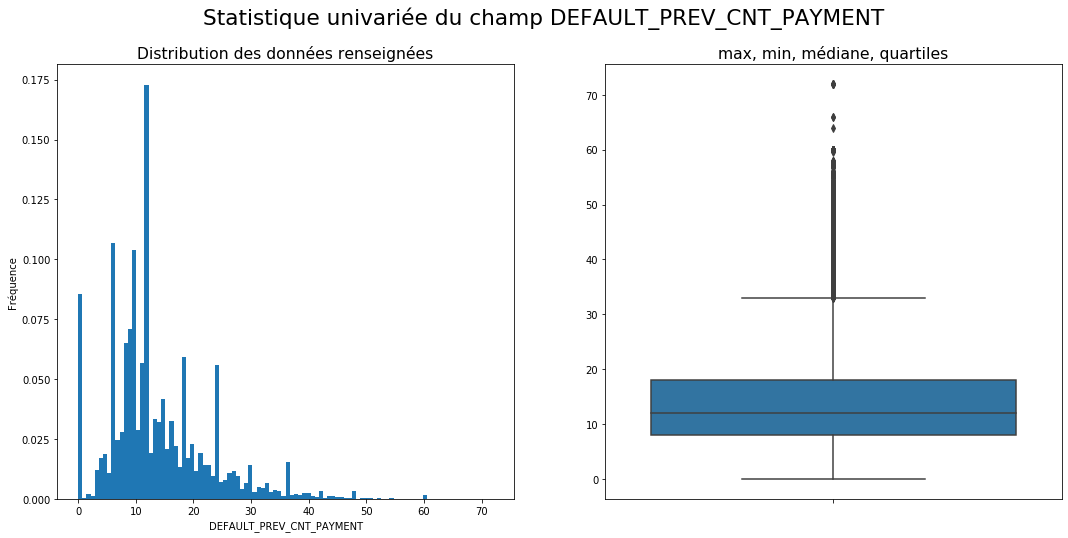

Mesures de position
 - Moyenne: 13.74
 - Médiane: 12.0
Mesures de dispertion
 - Ecart type: 8.84
 - Min: 0.0
 - Q25: 8.0
 - Q75: 18.0
 - Max: 72.0
Mesures de forme
 - Skewness (asymétrie): 1.2
 - Kurtosis (applatissement): 2.24


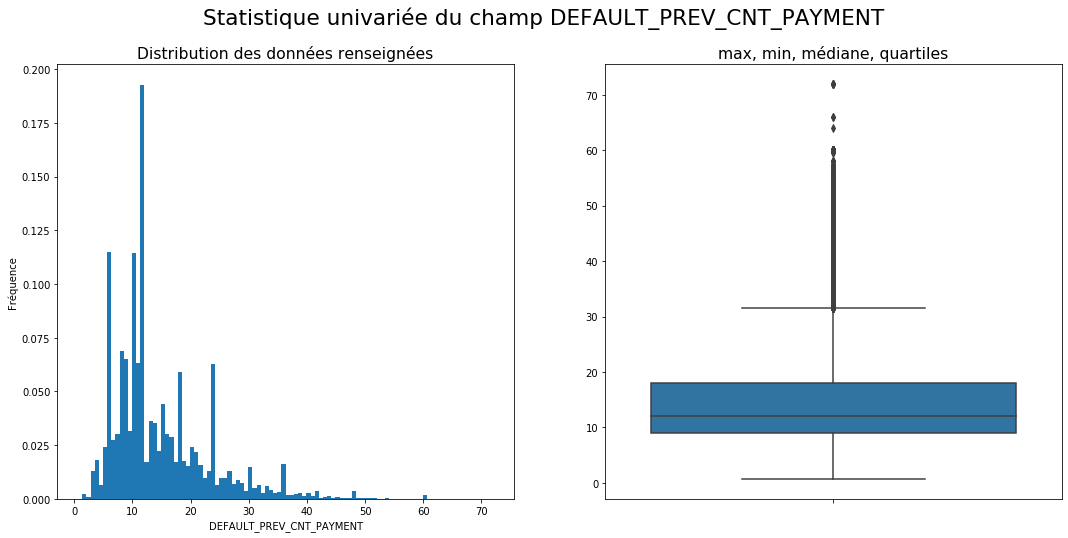

Mesures de position
 - Moyenne: 14.65
 - Médiane: 12.0
Mesures de dispertion
 - Ecart type: 8.37
 - Min: 0.67
 - Q25: 9.0
 - Q75: 18.0
 - Max: 72.0
Mesures de forme
 - Skewness (asymétrie): 1.47
 - Kurtosis (applatissement): 2.77

---------------------------------------------------------------------
DEFAULT_BURO_DAYS_CREDIT_UPDATE:3457


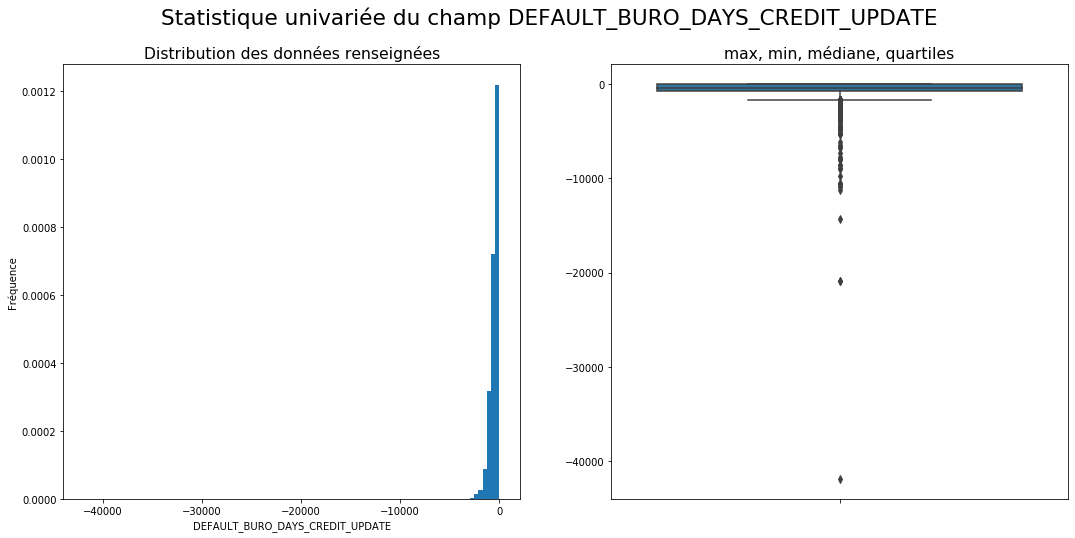

Mesures de position
 - Moyenne: -467.76
 - Médiane: -392.0
Mesures de dispertion
 - Ecart type: 465.53
 - Min: -41890.0
 - Q25: -720.12
 - Q75: -57.17
 - Max: 14.0
Mesures de forme
 - Skewness (asymétrie): -5.81
 - Kurtosis (applatissement): 341.35


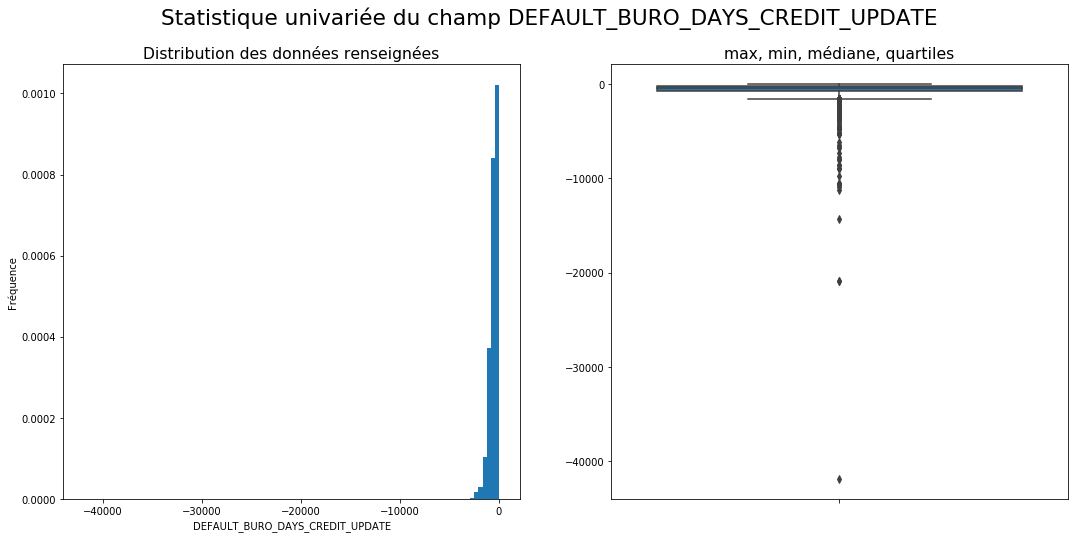

Mesures de position
 - Moyenne: -546.26
 - Médiane: -481.5
Mesures de dispertion
 - Ecart type: 458.48
 - Min: -41890.0
 - Q25: -778.15
 - Q75: -208.33
 - Max: 14.0
Mesures de forme
 - Skewness (asymétrie): -6.76
 - Kurtosis (applatissement): 419.45

---------------------------------------------------------------------
PREV_DAYS_DECISION:2668


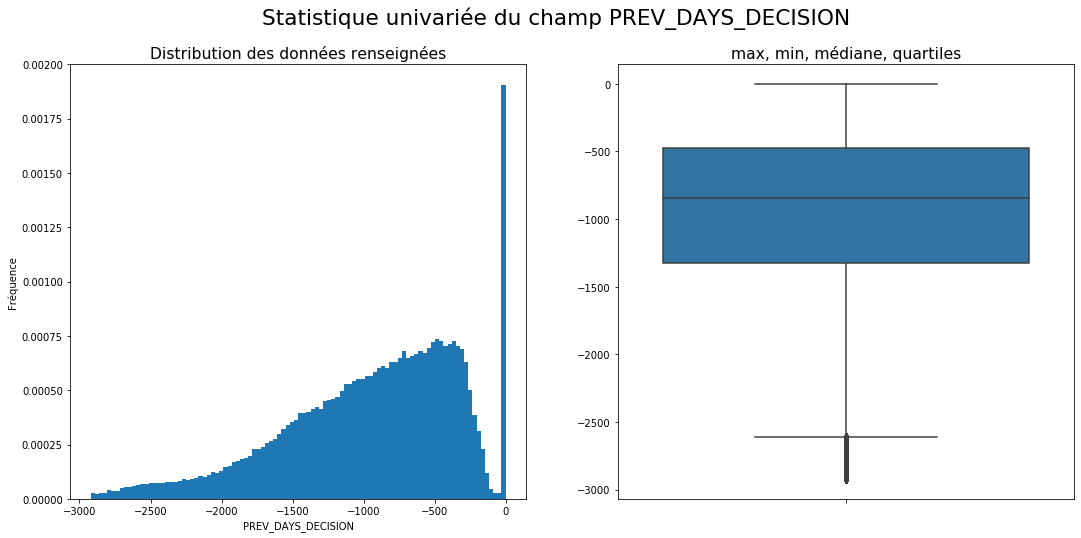

Mesures de position
 - Moyenne: -944.7
 - Médiane: -847.17
Mesures de dispertion
 - Ecart type: 615.29
 - Min: -2922.0
 - Q25: -1326.33
 - Q75: -472.0
 - Max: 0.0
Mesures de forme
 - Skewness (asymétrie): -0.71
 - Kurtosis (applatissement): 0.1


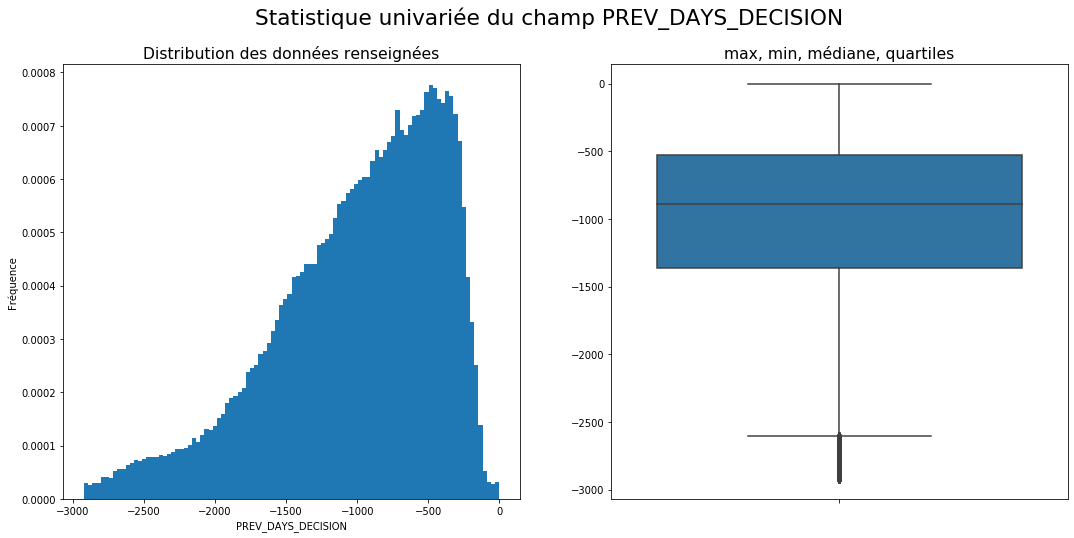

Mesures de position
 - Moyenne: -999.52
 - Médiane: -892.0
Mesures de dispertion
 - Ecart type: 588.01
 - Min: -2922.0
 - Q25: -1359.21
 - Q75: -528.33
 - Max: -2.0
Mesures de forme
 - Skewness (asymétrie): -0.82
 - Kurtosis (applatissement): 0.19

---------------------------------------------------------------------
BURO_DAYS_CREDIT:865


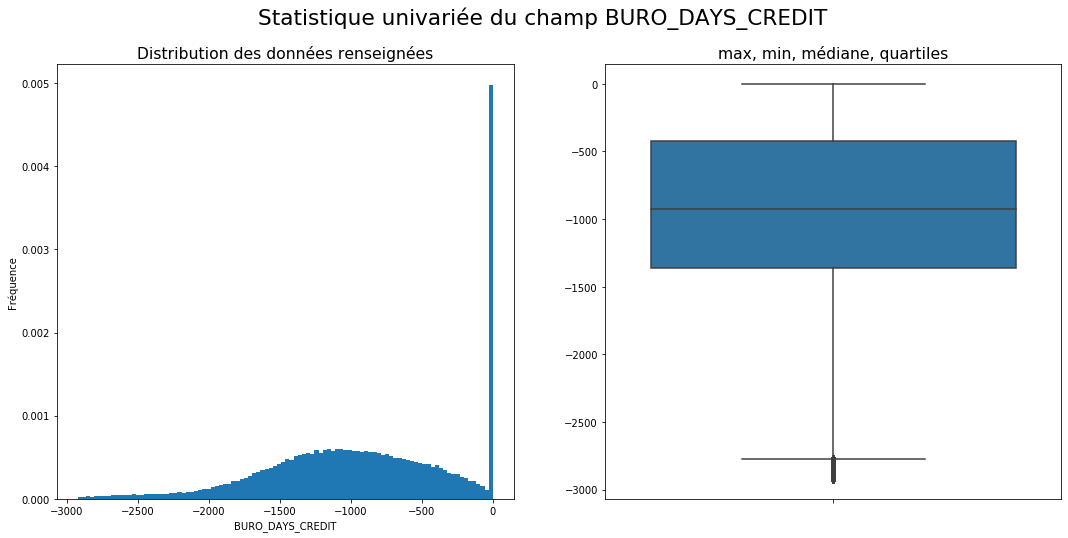

Mesures de position
 - Moyenne: -926.73
 - Médiane: -926.08
Mesures de dispertion
 - Ecart type: 644.67
 - Min: -2922.0
 - Q25: -1361.5
 - Q75: -422.0
 - Max: 0.0
Mesures de forme
 - Skewness (asymétrie): -0.35
 - Kurtosis (applatissement): -0.34


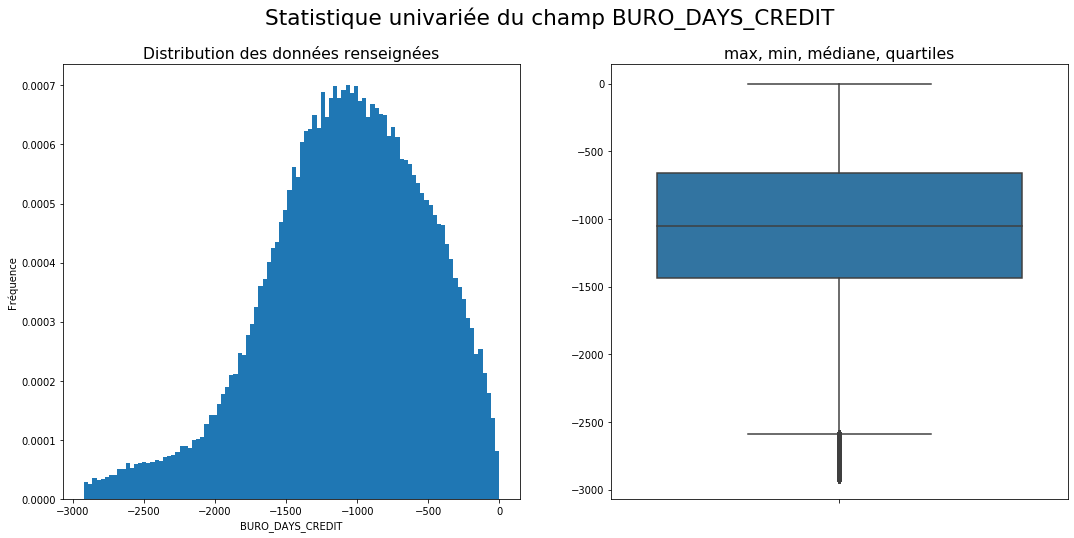

Mesures de position
 - Moyenne: -1082.2
 - Médiane: -1049.5
Mesures de dispertion
 - Ecart type: 563.1
 - Min: -2922.0
 - Q25: -1433.17
 - Q75: -663.0
 - Max: -2.0
Mesures de forme
 - Skewness (asymétrie): -0.5
 - Kurtosis (applatissement): 0.09


In [94]:
for index, row in statOutlier.iterrows():
    print('')
    print('---------------------------------------------------------------------')
    print('{}:{}'.format(row.feature,row.nb_outliers))
    myDf(dfApplicationWorked).Stat(row.feature)
    try:
        myDf(dfApplicationWorked[~dfApplicationWorked[row.feature].isin([0,1])]).Stat(row.feature)
    except:
        pass

<BarContainer object of 16 artists>

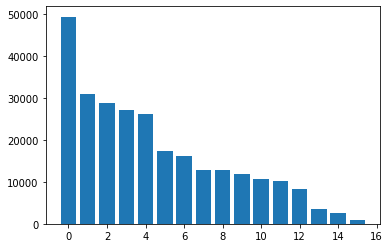

In [95]:
plt.bar([x for x in range(len(statOutlier))], statOutlier.nb_outliers.sort_values(ascending=False))

### Fonction d'analyse de la ditribution de la classe positive parmis les outliers

In [33]:
def statImbalancedOutlier(df1, feature, limit_outlier, nb_points=100, to_add_to_threshold=0):

    df = df1.copy()
    
    if limit_outlier < 0:
        df[feature] = -df[feature]
        min_outlier = -limit_outlier
    else:
        min_outlier = limit_outlier
    max_outlier = np.max(df[feature])
    results = []
    results_total = []
    
    thresholds = np.arange(nb_points) * (max_outlier - min_outlier) / nb_points + min_outlier
    for threshold in thresholds:
        nb_total = df[df[feature] >= threshold].shape[0]
        nb_positif = df[(df[feature] >= threshold) & (df['TARGET'] == 1)].shape[0]
        prct_positif = nb_positif / nb_total * 100
        results.append(prct_positif)
        results_total.append(nb_total)
    if limit_outlier < 0:
        thresholds = thresholds * -1
    
    thresholds = np.array(thresholds) + to_add_to_threshold
    
    size=1
    nbPlot=2
    plt.rcParams.update({'font.size':10, 'font.style':'normal'})
    fig = plt.figure(figsize=(size * (18 * nbPlot/2), size * 8))
    sub = fig.add_subplot(1,nbPlot,1)
    sub.set_title('Positive class vs outliers')
    #plt.legend(loc = 'lower right')
    plt.plot(thresholds, results)
    plt.axis('tight')
    plt.xlabel('threshold outlier')
    plt.ylabel('classe positive (%)')
    sub = fig.add_subplot(1,nbPlot,2)
    sub.set_title('Nb total record vs outlier')
    #plt.legend(loc = 'lower right')
    plt.plot(thresholds, results_total)
    plt.axis('tight')
    plt.xlabel('threshold outlier')
    plt.ylabel('Nb records')
    plt.rcParams.update({'font.size':12, 'font.style':'normal'})
    plt.suptitle(feature)
    plt.show()

## Analyse et transformation champ par champ

In [91]:
from pickle import load
dfApplicationWorked = load(open('ApplicationWorked_with_outliers.pkl','rb'))
dfApplicationWorkedSvg = dfApplicationWorked.copy()

#### BURO_AMT_CREDIT_MAX_OVERDUE ** VU **

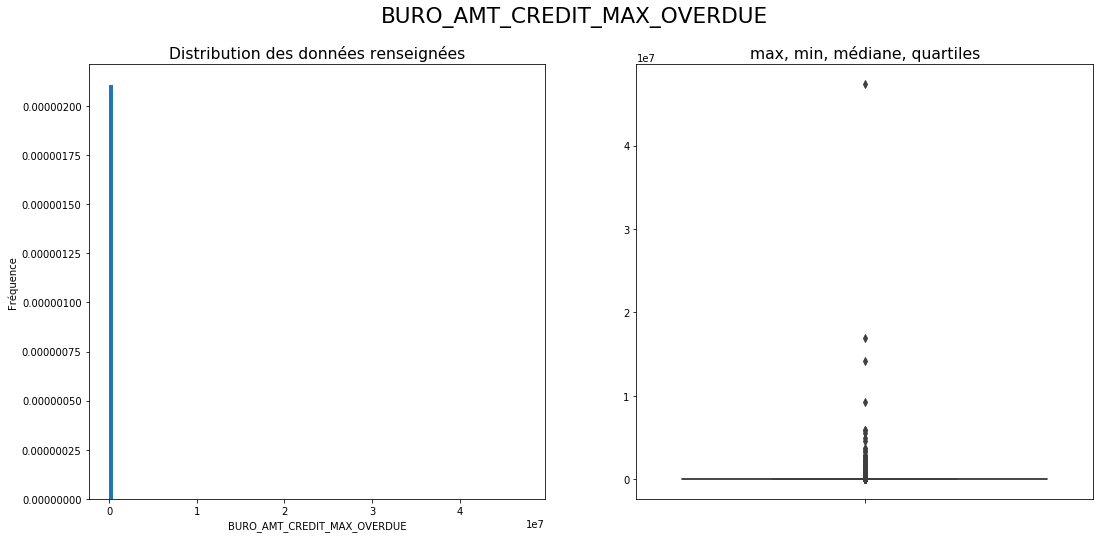

Mesures de position
 - Moyenne: 2759.67
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 120831.82
 - Min: 0.0
 - Q25: 0.0
 - Q75: 0.0
 - Max: 47406123.0
Mesures de forme
 - Skewness (asymétrie): 305.75
 - Kurtosis (applatissement): 112969.99


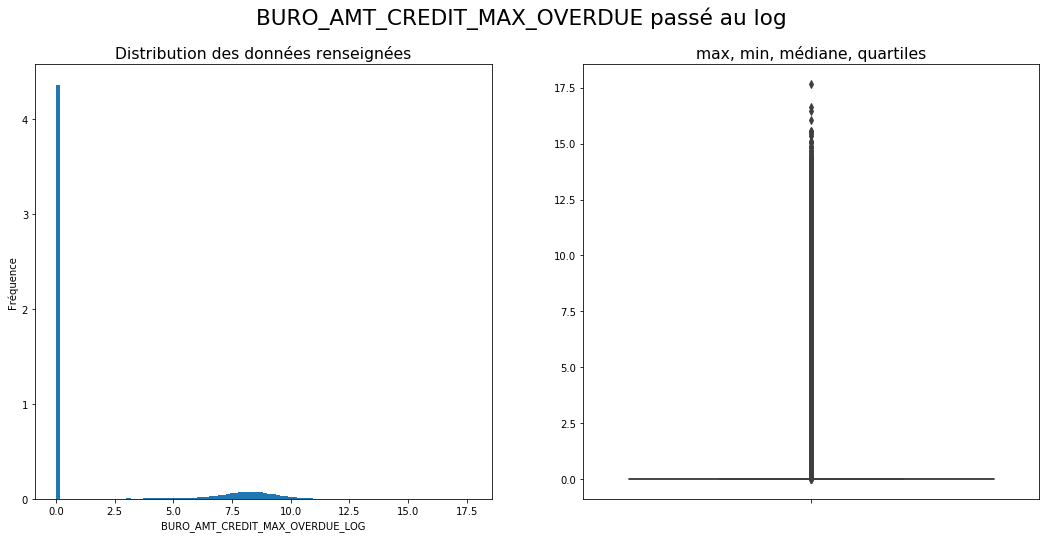

Mesures de position
 - Moyenne: 1.82
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 3.43
 - Min: 0.0
 - Q25: 0.0
 - Q75: 0.0
 - Max: 17.67
Mesures de forme
 - Skewness (asymétrie): 1.46
 - Kurtosis (applatissement): 0.32


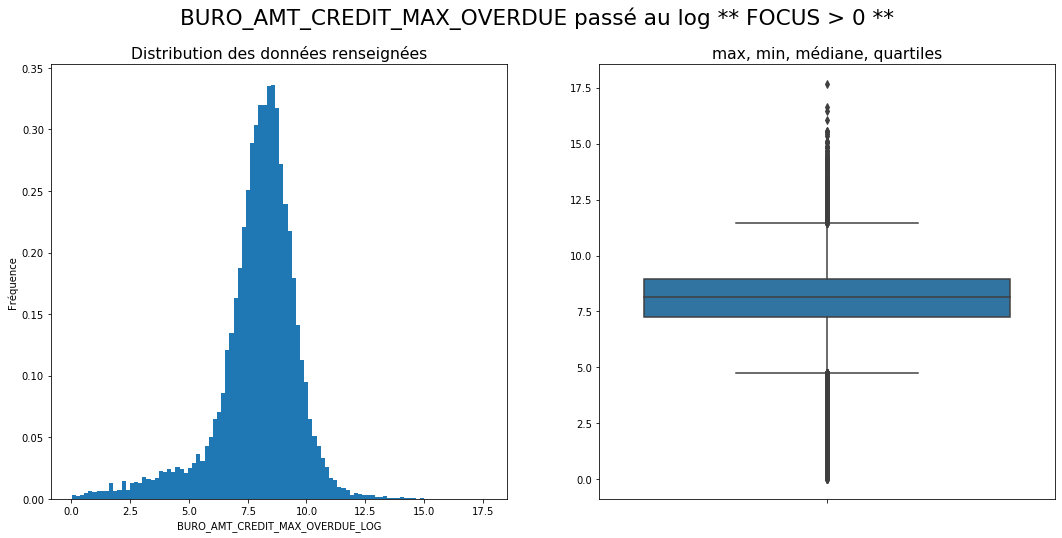

Mesures de position
 - Moyenne: 7.92
 - Médiane: 8.16
Mesures de dispertion
 - Ecart type: 1.73
 - Min: 0.01
 - Q25: 7.26
 - Q75: 8.94
 - Max: 17.67
Mesures de forme
 - Skewness (asymétrie): -1.17
 - Kurtosis (applatissement): 3.13


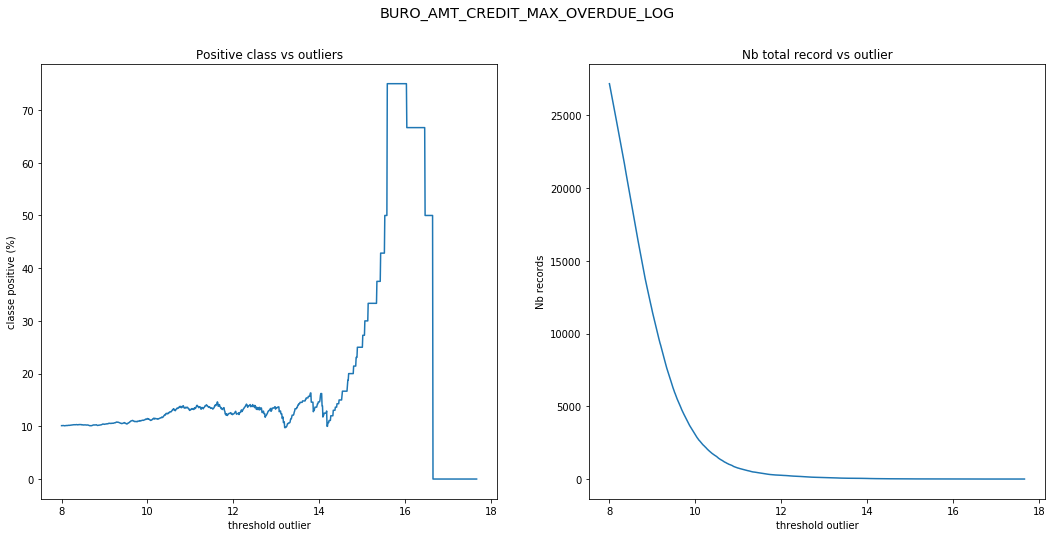

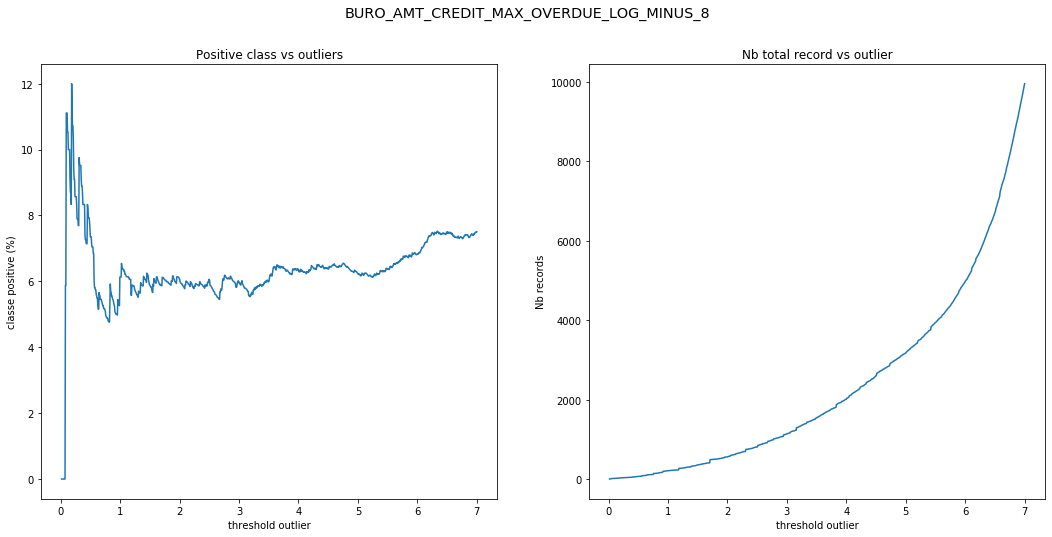

In [10]:
try:
    myDf(dfApplicationWorked).Stat('BURO_AMT_CREDIT_MAX_OVERDUE', pltTitle = 'BURO_AMT_CREDIT_MAX_OVERDUE')
    dfApplicationWorked['BURO_AMT_CREDIT_MAX_OVERDUE_LOG'] = dfApplicationWorked.apply(lambda x: np.log(x.BURO_AMT_CREDIT_MAX_OVERDUE + 1), axis=1)
    myDf(dfApplicationWorked).Stat('BURO_AMT_CREDIT_MAX_OVERDUE_LOG', pltTitle = 'BURO_AMT_CREDIT_MAX_OVERDUE passé au log')
    myDf(dfApplicationWorked[dfApplicationWorked.BURO_AMT_CREDIT_MAX_OVERDUE_LOG != 0]).Stat('BURO_AMT_CREDIT_MAX_OVERDUE_LOG', pltTitle = 'BURO_AMT_CREDIT_MAX_OVERDUE passé au log ** FOCUS > 0 **')

    statImbalancedOutlier(dfApplicationWorked, 'BURO_AMT_CREDIT_MAX_OVERDUE_LOG', limit_outlier=8, nb_points=1000)
    tmp = dfApplicationWorked[dfApplicationWorked.BURO_AMT_CREDIT_MAX_OVERDUE_LOG>0].copy()
    tmp['BURO_AMT_CREDIT_MAX_OVERDUE_LOG_MINUS_8'] = tmp.apply(lambda x: x.BURO_AMT_CREDIT_MAX_OVERDUE_LOG-8, axis=1)
    statImbalancedOutlier(tmp, 'BURO_AMT_CREDIT_MAX_OVERDUE_LOG_MINUS_8', limit_outlier=-1, nb_points=1000, to_add_to_threshold=8.0)

except:
    pass

#### INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG ** VU **

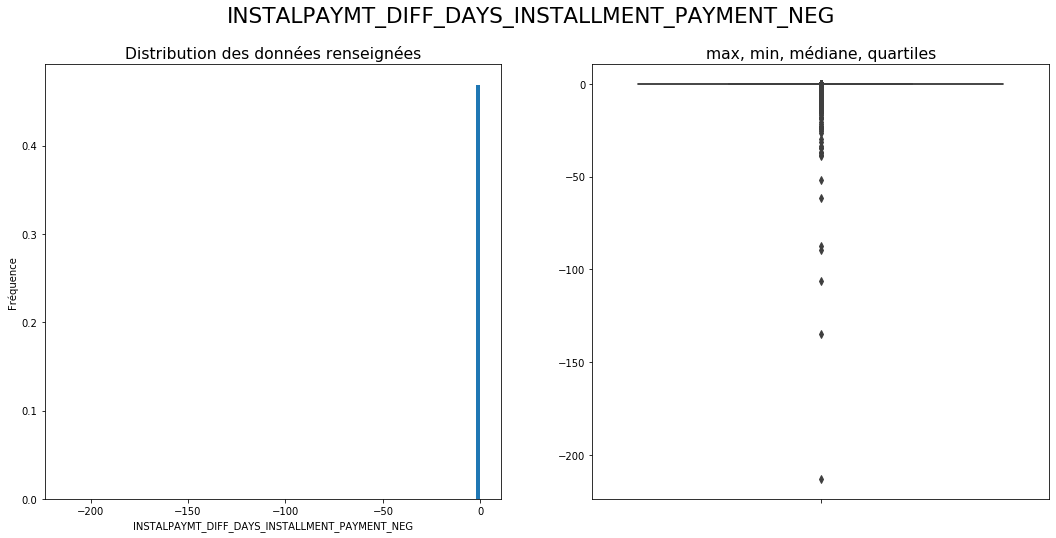

Mesures de position
 - Moyenne: -0.04
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 0.77
 - Min: -212.98
 - Q25: -0.02
 - Q75: 0.0
 - Max: 0.0
Mesures de forme
 - Skewness (asymétrie): -162.18
 - Kurtosis (applatissement): 36127.87


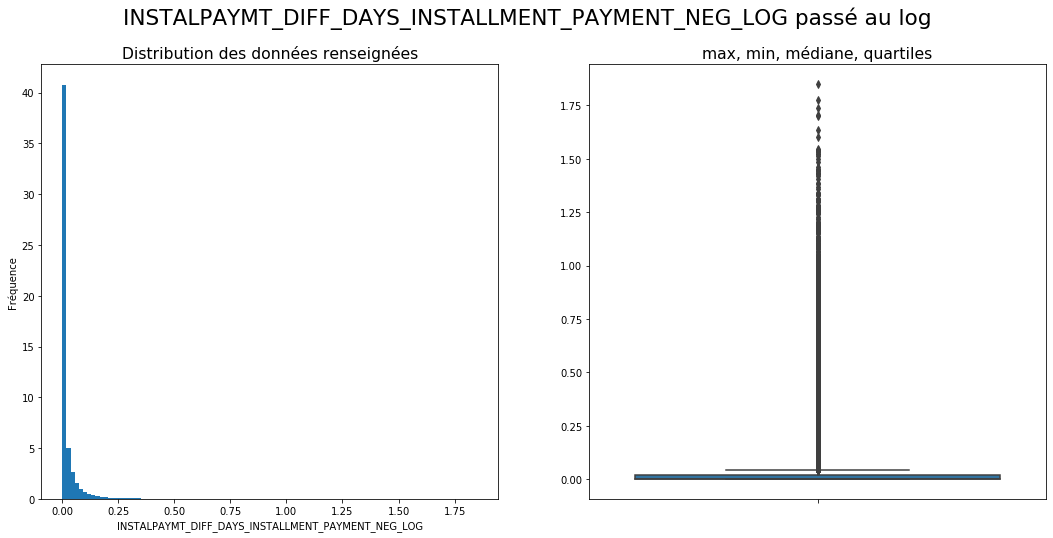

Mesures de position
 - Moyenne: 0.02
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 0.07
 - Min: 0.0
 - Q25: 0.0
 - Q75: 0.02
 - Max: 1.85
Mesures de forme
 - Skewness (asymétrie): 8.78
 - Kurtosis (applatissement): 115.22


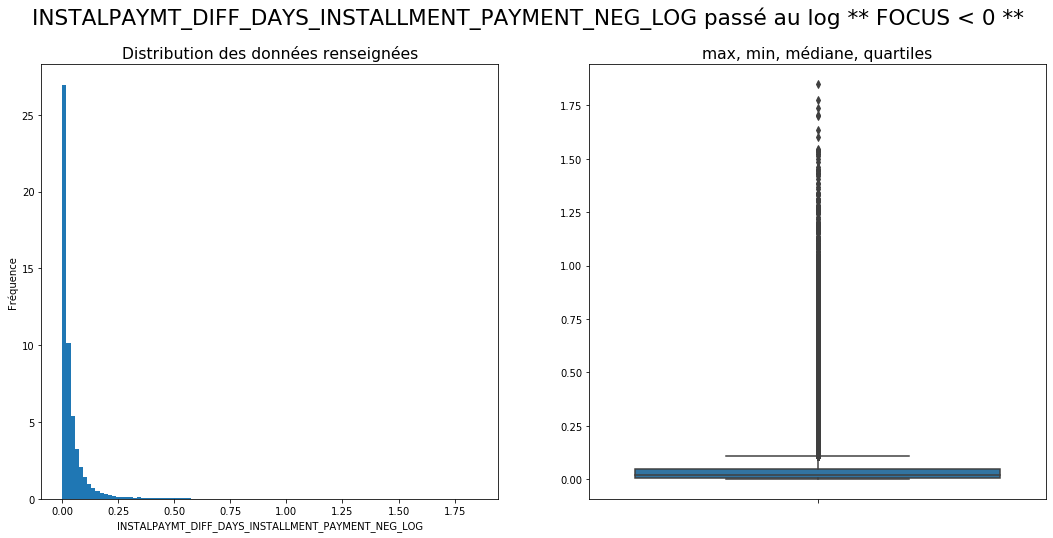

Mesures de position
 - Moyenne: 0.05
 - Médiane: 0.02
Mesures de dispertion
 - Ecart type: 0.09
 - Min: 0.0
 - Q25: 0.01
 - Q75: 0.05
 - Max: 1.85
Mesures de forme
 - Skewness (asymétrie): 6.56
 - Kurtosis (applatissement): 63.1


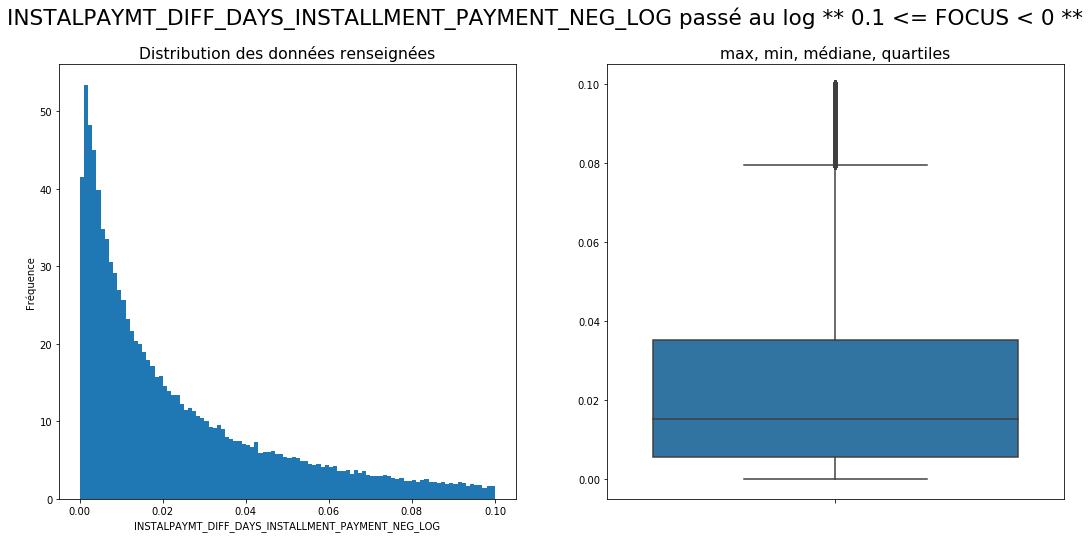

Mesures de position
 - Moyenne: 0.02
 - Médiane: 0.02
Mesures de dispertion
 - Ecart type: 0.02
 - Min: 0.0
 - Q25: 0.01
 - Q75: 0.04
 - Max: 0.1
Mesures de forme
 - Skewness (asymétrie): 1.27
 - Kurtosis (applatissement): 0.82


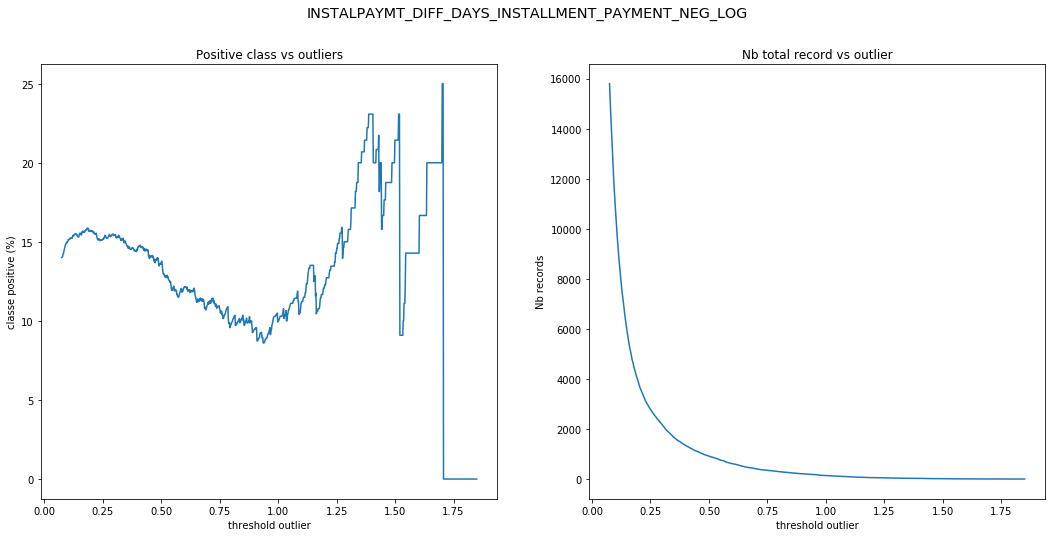

In [31]:
try:
    myDf(dfApplicationWorked).Stat('INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG', pltTitle = 'INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG')
    dfApplicationWorked['INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG_LOG'] = dfApplicationWorked.apply(lambda x: np.log(np.log(-x.INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG + 1)+1), axis=1)
    myDf(dfApplicationWorked).Stat('INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG_LOG', pltTitle = 'INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG_LOG passé au log')
    myDf(dfApplicationWorked[dfApplicationWorked.INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG_LOG > 0]).Stat('INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG_LOG', pltTitle = 'INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG_LOG passé au log ** FOCUS < 0 **')
    myDf(dfApplicationWorked[(dfApplicationWorked.INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG_LOG > 0) & (dfApplicationWorked.INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG_LOG < 0.1)]).Stat('INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG_LOG', pltTitle = 'INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG_LOG passé au log ** 0.1 <= FOCUS < 0 **')
    
    statImbalancedOutlier(dfApplicationWorked, 'INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG_LOG', limit_outlier=0.075, nb_points=1000)
except:
    pass

#### INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS *** VU ***

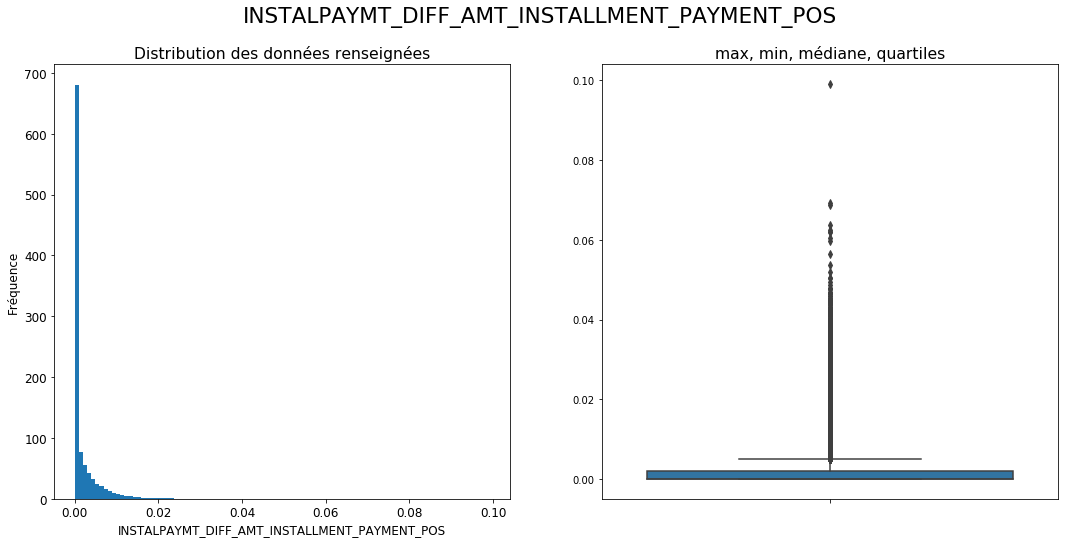

Mesures de position
 - Moyenne: 0.0
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 0.0
 - Min: 0.0
 - Q25: 0.0
 - Q75: 0.0
 - Max: 0.1
Mesures de forme
 - Skewness (asymétrie): 3.8
 - Kurtosis (applatissement): 25.25


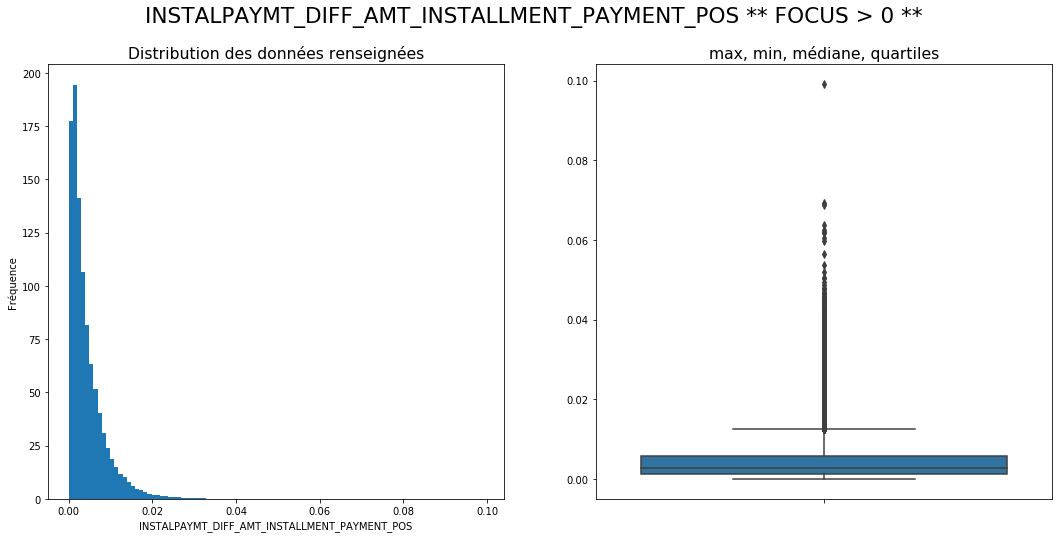

Mesures de position
 - Moyenne: 0.0
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 0.0
 - Min: 0.0
 - Q25: 0.0
 - Q75: 0.01
 - Max: 0.1
Mesures de forme
 - Skewness (asymétrie): 2.79
 - Kurtosis (applatissement): 15.46


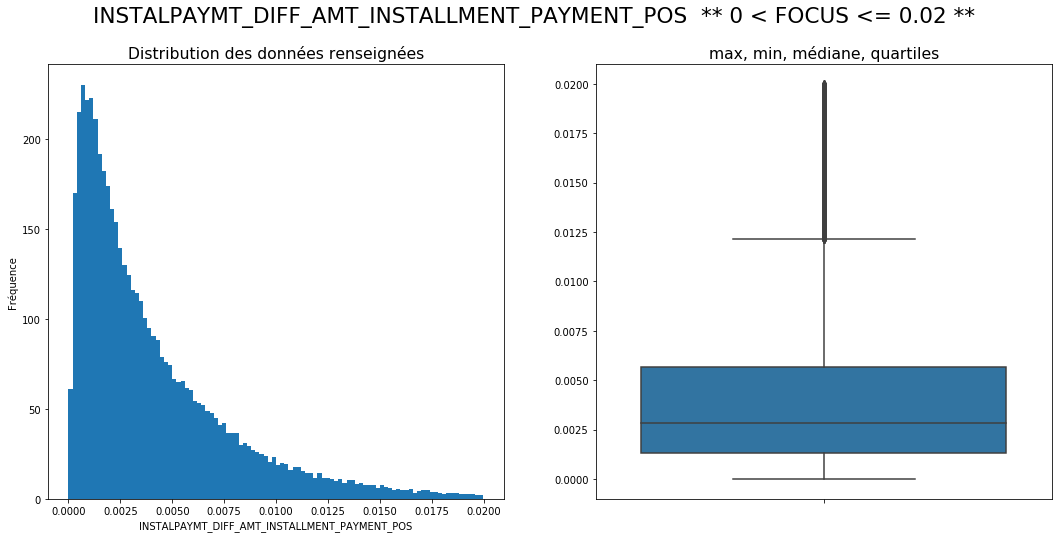

Mesures de position
 - Moyenne: 0.0
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 0.0
 - Min: 0.0
 - Q25: 0.0
 - Q75: 0.01
 - Max: 0.02
Mesures de forme
 - Skewness (asymétrie): 1.54
 - Kurtosis (applatissement): 2.31


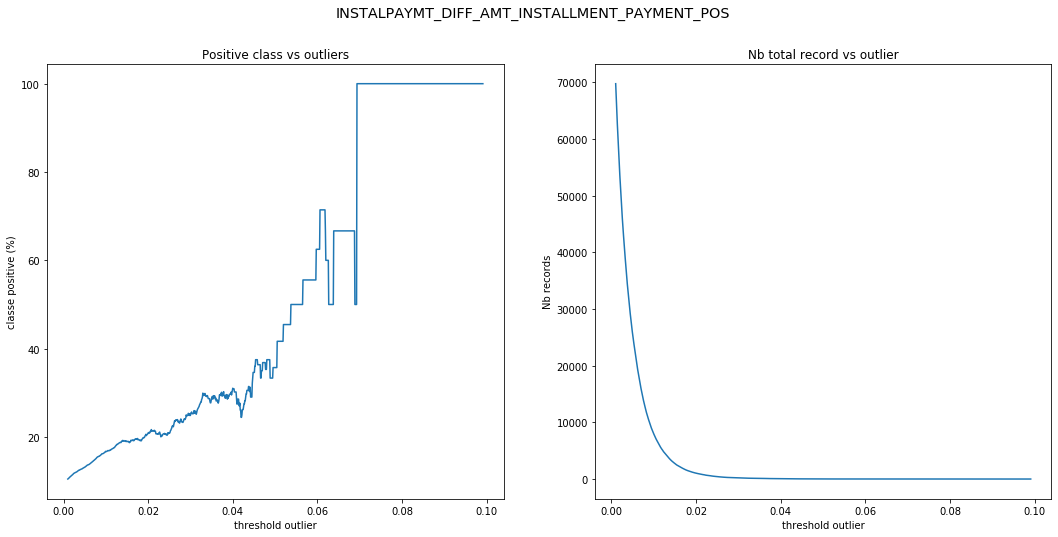

In [13]:
try:
    myDf(dfApplicationWorked).Stat('INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS', pltTitle = 'INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS')
    myDf(dfApplicationWorked[dfApplicationWorked.INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS > 0]).Stat('INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS', pltTitle = 'INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS ** FOCUS > 0 **')
    myDf(dfApplicationWorked[(dfApplicationWorked.INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS > 0) & (dfApplicationWorked.INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS < 0.02)]).Stat('INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS', pltTitle = 'INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS  ** 0 < FOCUS <= 0.02 **')

    statImbalancedOutlier(dfApplicationWorked, 'INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS', limit_outlier=0.001, nb_points=1000)
    #del dfApplicationWorked['BURO_AMT_CREDIT_MAX_OVERDUE']
except:
    pass

#### DEFAULT_PREV_AMT_DOWN_PAYMENT * VU *

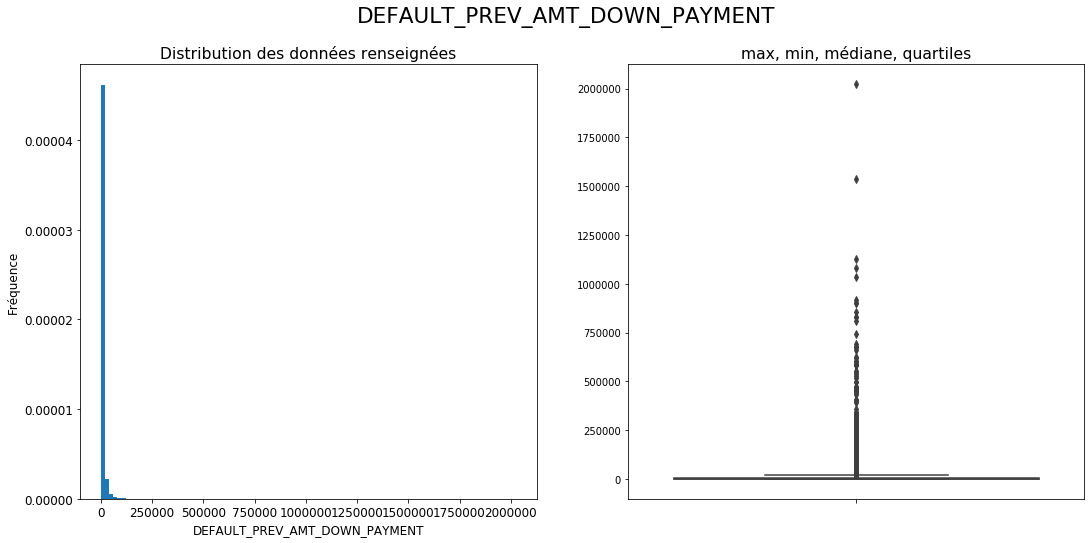

Mesures de position
 - Moyenne: 6306.11
 - Médiane: 2511.0
Mesures de dispertion
 - Ecart type: 17108.15
 - Min: -0.22
 - Q25: 0.0
 - Q75: 7318.12
 - Max: 2025000.0
Mesures de forme
 - Skewness (asymétrie): 28.18
 - Kurtosis (applatissement): 1858.39


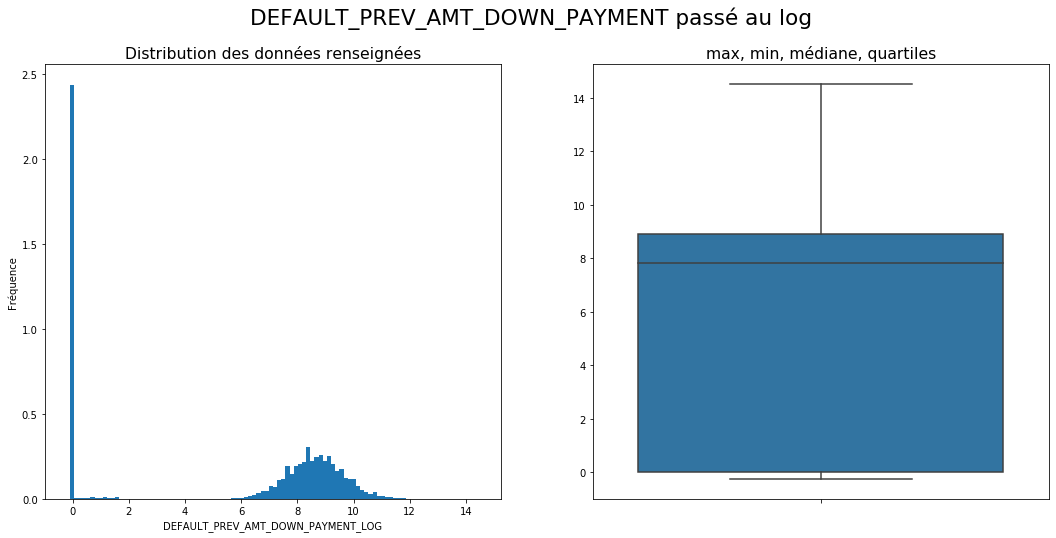

Mesures de position
 - Moyenne: 5.46
 - Médiane: 7.83
Mesures de dispertion
 - Ecart type: 4.25
 - Min: -0.25
 - Q25: 0.0
 - Q75: 8.9
 - Max: 14.52
Mesures de forme
 - Skewness (asymétrie): -0.43
 - Kurtosis (applatissement): -1.67


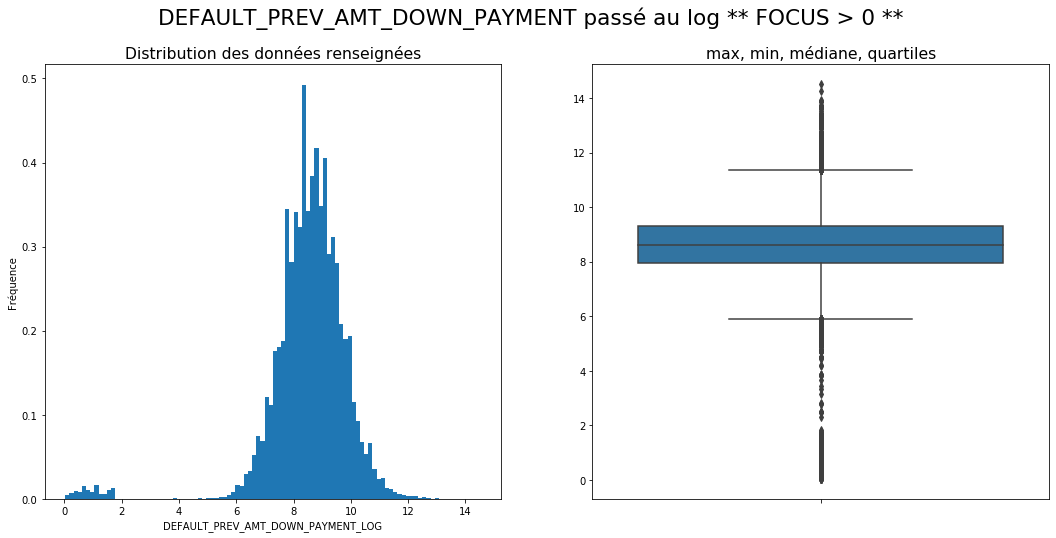

Mesures de position
 - Moyenne: 8.53
 - Médiane: 8.63
Mesures de dispertion
 - Ecart type: 1.41
 - Min: 0.03
 - Q25: 7.94
 - Q75: 9.3
 - Max: 14.52
Mesures de forme
 - Skewness (asymétrie): -2.45
 - Kurtosis (applatissement): 12.25


In [27]:
try:
    myDf(dfApplicationWorked).Stat('DEFAULT_PREV_AMT_DOWN_PAYMENT', pltTitle = 'DEFAULT_PREV_AMT_DOWN_PAYMENT')
    dfApplicationWorked['DEFAULT_PREV_AMT_DOWN_PAYMENT_LOG'] = dfApplicationWorked.apply(lambda x: np.log(x.DEFAULT_PREV_AMT_DOWN_PAYMENT + 1), axis=1)
    myDf(dfApplicationWorked).Stat('DEFAULT_PREV_AMT_DOWN_PAYMENT_LOG', pltTitle = 'DEFAULT_PREV_AMT_DOWN_PAYMENT passé au log')
    myDf(dfApplicationWorked[dfApplicationWorked.DEFAULT_PREV_AMT_DOWN_PAYMENT_LOG > 0]).Stat('DEFAULT_PREV_AMT_DOWN_PAYMENT_LOG', pltTitle = 'DEFAULT_PREV_AMT_DOWN_PAYMENT passé au log ** FOCUS > 0 **')

    statImbalancedOutlier(dfApplicationWorked, 'DEFAULT_PREV_AMT_DOWN_PAYMENT_LOG', limit_outlier=8, nb_points=1000)
    tmp = dfApplicationWorked[dfApplicationWorked.DEFAULT_PREV_AMT_DOWN_PAYMENT_LOG>0].copy()
    tmp['DEFAULT_PREV_AMT_DOWN_PAYMENT_LOG_MINUS_8'] = tmp.apply(lambda x: x.DEFAULT_PREV_AMT_DOWN_PAYMENT_LOG-8, axis=1)
    statImbalancedOutlier(tmp, 'DEFAULT_PREV_AMT_DOWN_PAYMENT_LOG_MINUS_8', limit_outlier=0, nb_points=1000, to_add_to_threshold=8.0)
    
except:
    pass

#### BURO_DAYS_CREDIT_ENDDATE *** VU ***

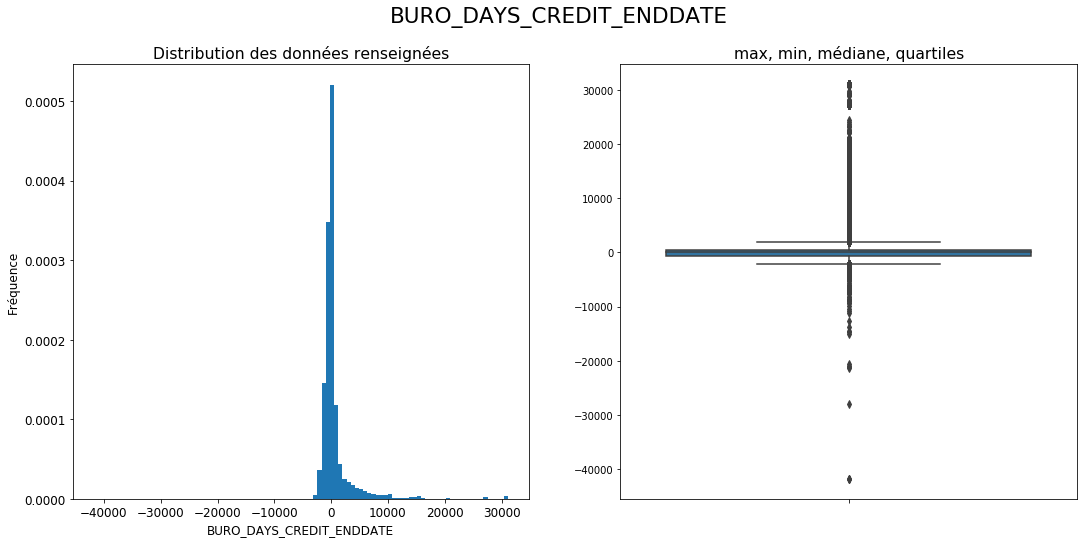

Mesures de position
 - Moyenne: 559.01
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 3051.48
 - Min: -41875.0
 - Q25: -593.17
 - Q75: 404.33
 - Max: 31198.0
Mesures de forme
 - Skewness (asymétrie): 5.35
 - Kurtosis (applatissement): 40.64


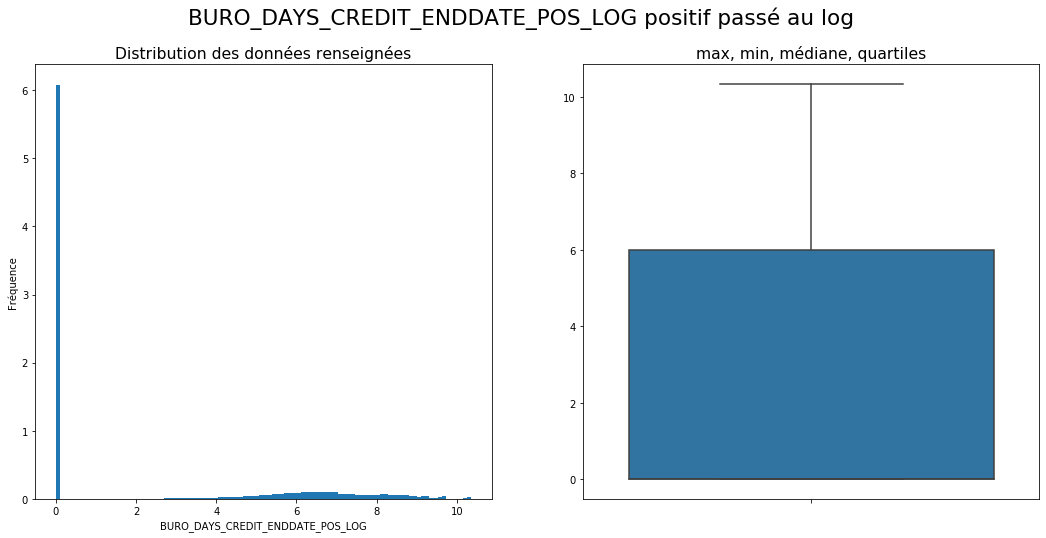

Mesures de position
 - Moyenne: 2.48
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 3.38
 - Min: 0.0
 - Q25: 0.0
 - Q75: 6.0
 - Max: 10.35
Mesures de forme
 - Skewness (asymétrie): 0.78
 - Kurtosis (applatissement): -1.12


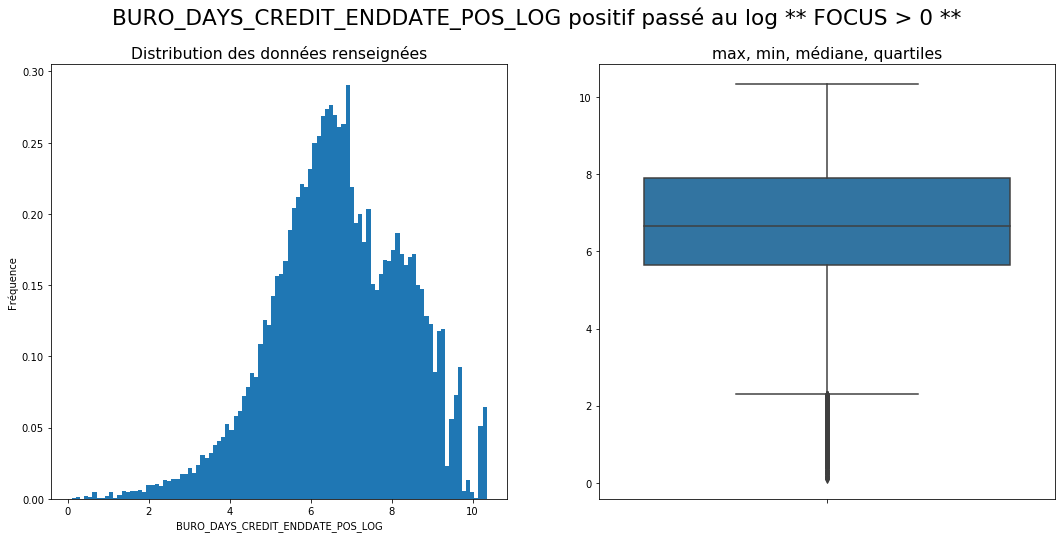

Mesures de position
 - Moyenne: 6.69
 - Médiane: 6.67
Mesures de dispertion
 - Ecart type: 1.63
 - Min: 0.1
 - Q25: 5.66
 - Q75: 7.9
 - Max: 10.35
Mesures de forme
 - Skewness (asymétrie): -0.3
 - Kurtosis (applatissement): 0.16


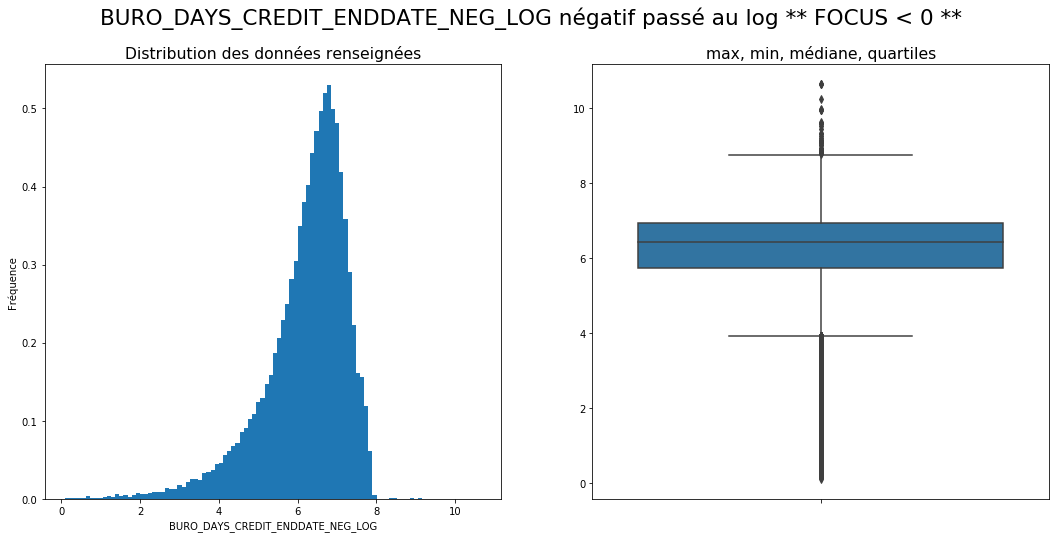

Mesures de position
 - Moyenne: 6.21
 - Médiane: 6.44
Mesures de dispertion
 - Ecart type: 1.06
 - Min: 0.11
 - Q25: 5.73
 - Q75: 6.93
 - Max: 10.64
Mesures de forme
 - Skewness (asymétrie): -1.39
 - Kurtosis (applatissement): 2.84


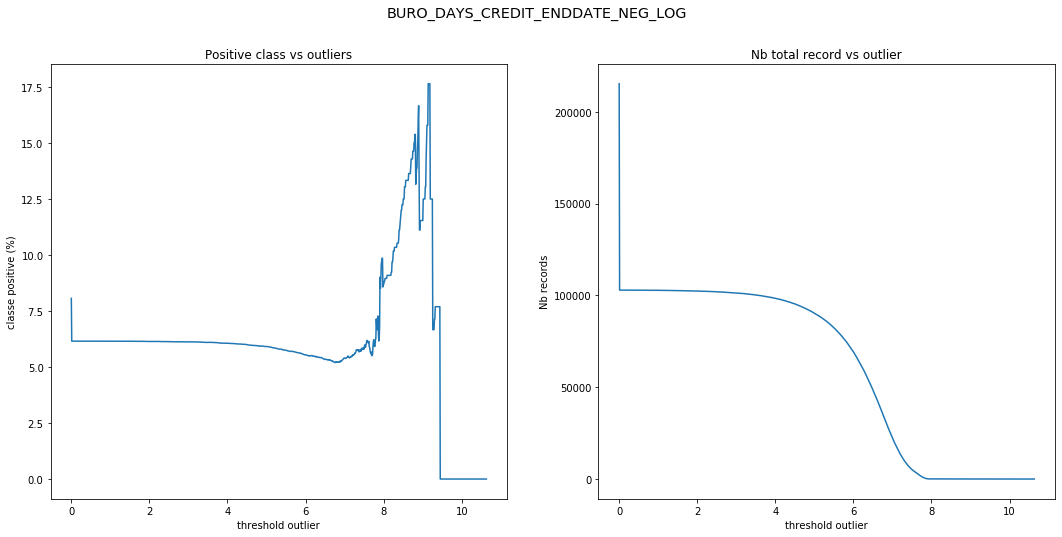

In [28]:
myDf(dfApplicationWorked).Stat('BURO_DAYS_CREDIT_ENDDATE', pltTitle = 'BURO_DAYS_CREDIT_ENDDATE')
dfApplicationWorked['BURO_DAYS_CREDIT_ENDDATE_POS_LOG'] = dfApplicationWorked.apply(lambda x: np.log(1+np.max([x.BURO_DAYS_CREDIT_ENDDATE,0])), axis=1)
dfApplicationWorked['BURO_DAYS_CREDIT_ENDDATE_NEG_LOG'] = dfApplicationWorked.apply(lambda x: np.log(1-np.min([x.BURO_DAYS_CREDIT_ENDDATE,0])), axis=1)
myDf(dfApplicationWorked).Stat('BURO_DAYS_CREDIT_ENDDATE_POS_LOG', pltTitle = 'BURO_DAYS_CREDIT_ENDDATE_POS_LOG positif passé au log')
myDf(dfApplicationWorked[dfApplicationWorked.BURO_DAYS_CREDIT_ENDDATE_POS_LOG>0]).Stat('BURO_DAYS_CREDIT_ENDDATE_POS_LOG', pltTitle = 'BURO_DAYS_CREDIT_ENDDATE_POS_LOG positif passé au log ** FOCUS > 0 **')
myDf(dfApplicationWorked[dfApplicationWorked.BURO_DAYS_CREDIT_ENDDATE_NEG_LOG>0]).Stat('BURO_DAYS_CREDIT_ENDDATE_NEG_LOG', pltTitle = 'BURO_DAYS_CREDIT_ENDDATE_NEG_LOG négatif passé au log ** FOCUS < 0 **')
statImbalancedOutlier(dfApplicationWorked, 'BURO_DAYS_CREDIT_ENDDATE_POS_LOG', limit_outlier=0, nb_points=1000)
statImbalancedOutlier(dfApplicationWorked, 'BURO_DAYS_CREDIT_ENDDATE_NEG_LOG', limit_outlier=0, nb_points=1000)

#### DEFAULT_POSCASH_CNT_INSTALMENT_FUTURE * VU *

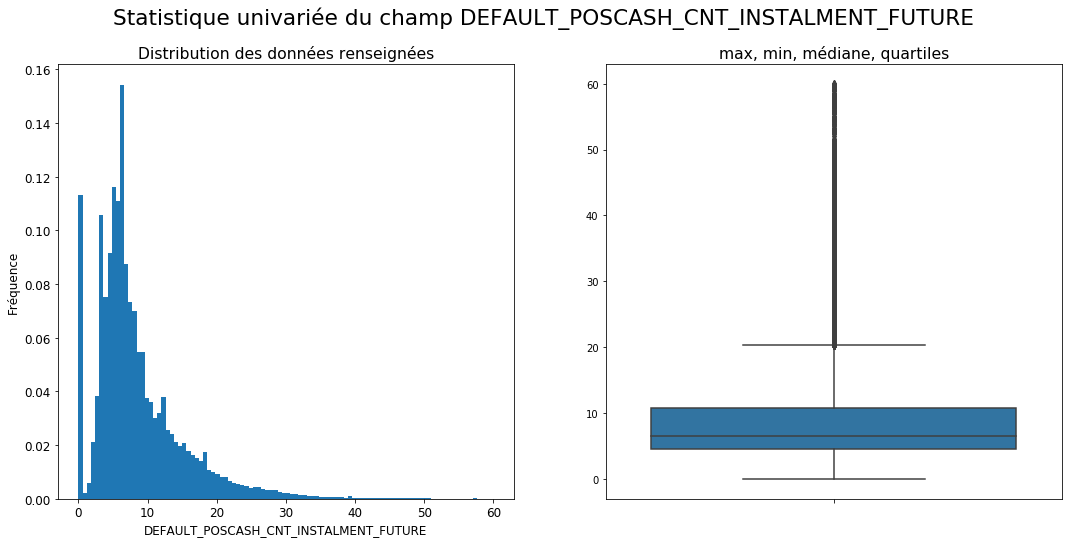

Mesures de position
 - Moyenne: 8.48
 - Médiane: 6.59
Mesures de dispertion
 - Ecart type: 6.56
 - Min: 0.0
 - Q25: 4.55
 - Q75: 10.85
 - Max: 60.0
Mesures de forme
 - Skewness (asymétrie): 1.88
 - Kurtosis (applatissement): 5.61


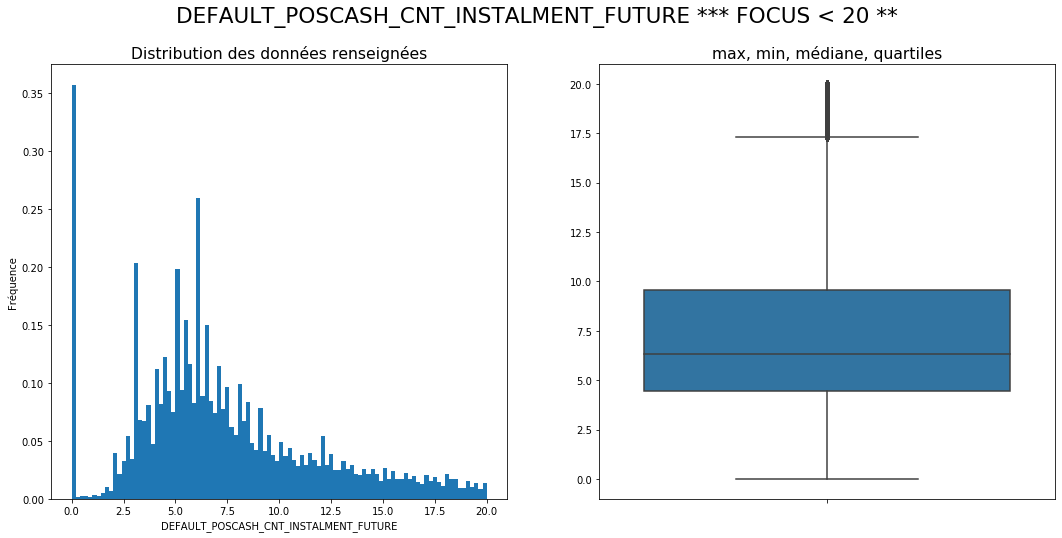

Mesures de position
 - Moyenne: 7.29
 - Médiane: 6.33
Mesures de dispertion
 - Ecart type: 4.49
 - Min: 0.0
 - Q25: 4.44
 - Q75: 9.58
 - Max: 20.0
Mesures de forme
 - Skewness (asymétrie): 0.71
 - Kurtosis (applatissement): 0.15


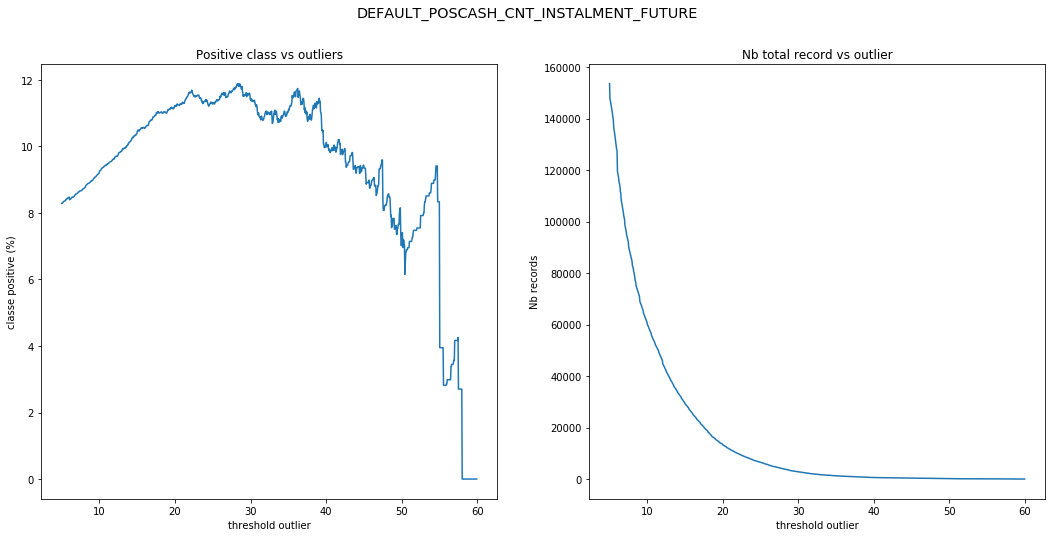

In [35]:
try:
    myDf(dfApplicationWorked).Stat('DEFAULT_POSCASH_CNT_INSTALMENT_FUTURE')
    myDf(dfApplicationWorked[dfApplicationWorked.DEFAULT_POSCASH_CNT_INSTALMENT_FUTURE <= 20]).Stat('DEFAULT_POSCASH_CNT_INSTALMENT_FUTURE', pltTitle='DEFAULT_POSCASH_CNT_INSTALMENT_FUTURE *** FOCUS < 20 **')
    statImbalancedOutlier(dfApplicationWorked,feature='DEFAULT_POSCASH_CNT_INSTALMENT_FUTURE', nb_points=1000, limit_outlier = 5)
except:
    pass

#### DAYS_EMPLOYED

Mesures de position
 - Moyenne: -1950.48
 - Médiane: -1209.0
Mesures de dispertion
 - Ecart type: 2304.46
 - Min: -17912
 - Q25: -2754.0
 - Q75: -289.0
 - Max: 1
Mesures de forme
 - Skewness (asymétrie): -2.05
 - Kurtosis (applatissement): 5.24


Mesures de position
 - Moyenne: -1641.09
 - Médiane: -1132.0
Mesures de dispertion
 - Ecart type: 1685.59
 - Min: -7500
 - Q25: -2523.0
 - Q75: -257.0
 - Max: 1
Mesures de forme
 - Skewness (asymétrie): -1.22
 - Kurtosis (applatissement): 0.94


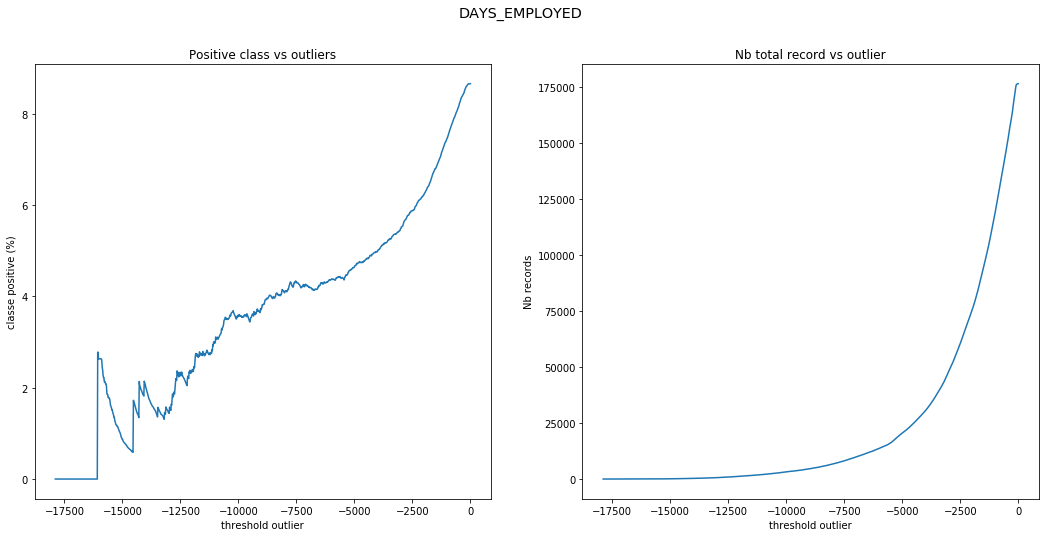

In [40]:
try:
    myDf(dfApplicationWorked).Stat('DAYS_EMPLOYED')
    myDf(dfApplicationWorked[dfApplicationWorked.DAYS_EMPLOYED >= -7500]).Stat('DAYS_EMPLOYED', pltTitle='DAYS_EMPLOYED ** FOCUS > -5500')
    statImbalancedOutlier(dfApplicationWorked,feature='DAYS_EMPLOYED', nb_points=1000, limit_outlier = -1)
except:
    pass

#### PREV_DAYS_DIFF

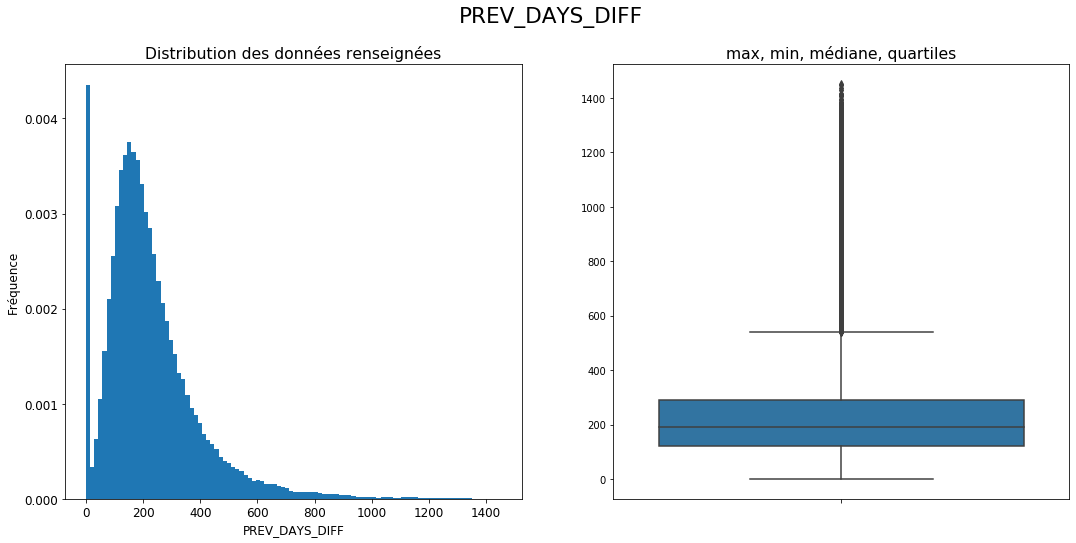

Mesures de position
 - Moyenne: 226.15
 - Médiane: 191.75
Mesures de dispertion
 - Ecart type: 166.34
 - Min: 0.0
 - Q25: 122.83
 - Q75: 290.33
 - Max: 1451.5
Mesures de forme
 - Skewness (asymétrie): 1.83
 - Kurtosis (applatissement): 5.78


Mesures de position
 - Moyenne: 216.78
 - Médiane: 190.0
Mesures de dispertion
 - Ecart type: 143.68
 - Min: 0.0
 - Q25: 121.95
 - Q75: 285.11
 - Max: 799.67
Mesures de forme
 - Skewness (asymétrie): 1.08
 - Kurtosis (applatissement): 1.51


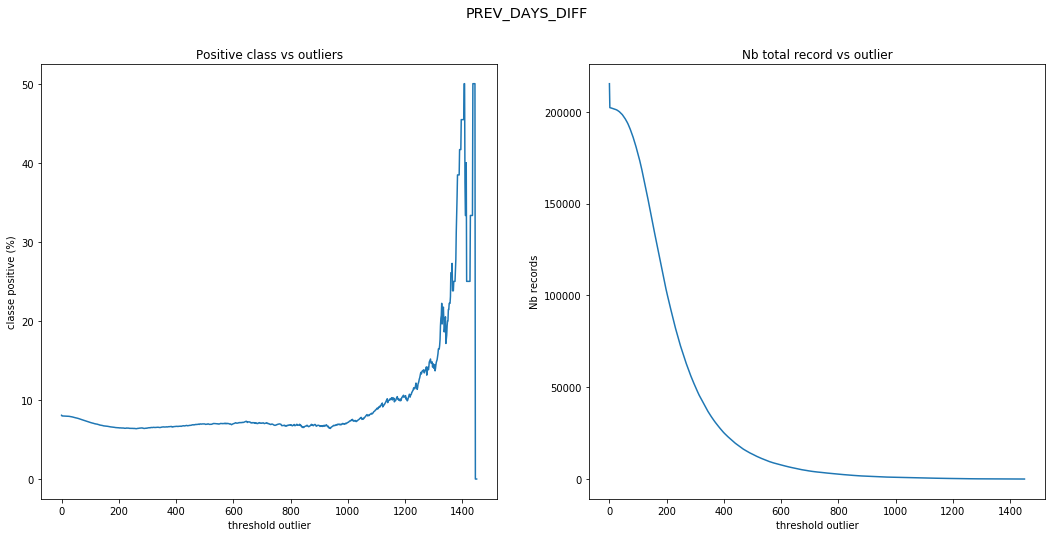

In [52]:
try:
    myDf(dfApplicationWorked).Stat('PREV_DAYS_DIFF', pltTitle='PREV_DAYS_DIFF')
    myDf(dfApplicationWorked[dfApplicationWorked.PREV_DAYS_DIFF < 800]).Stat('PREV_DAYS_DIFF', pltTitle='PREV_DAYS_DIFF ** FOCUS < 800 **')
    statImbalancedOutlier(dfApplicationWorked,feature='PREV_DAYS_DIFF', nb_points=1000, limit_outlier = 0)
except:
    pass

#### DEFAULT_AMT_GOODS_PRICE * VU *

Mesures de position
 - Moyenne: 538187.97
 - Médiane: 450000.0
Mesures de dispertion
 - Ecart type: 369446.25
 - Min: 45000.0
 - Q25: 238500.0
 - Q75: 679500.0
 - Max: 4050000.0
Mesures de forme
 - Skewness (asymétrie): 1.35
 - Kurtosis (applatissement): 2.42


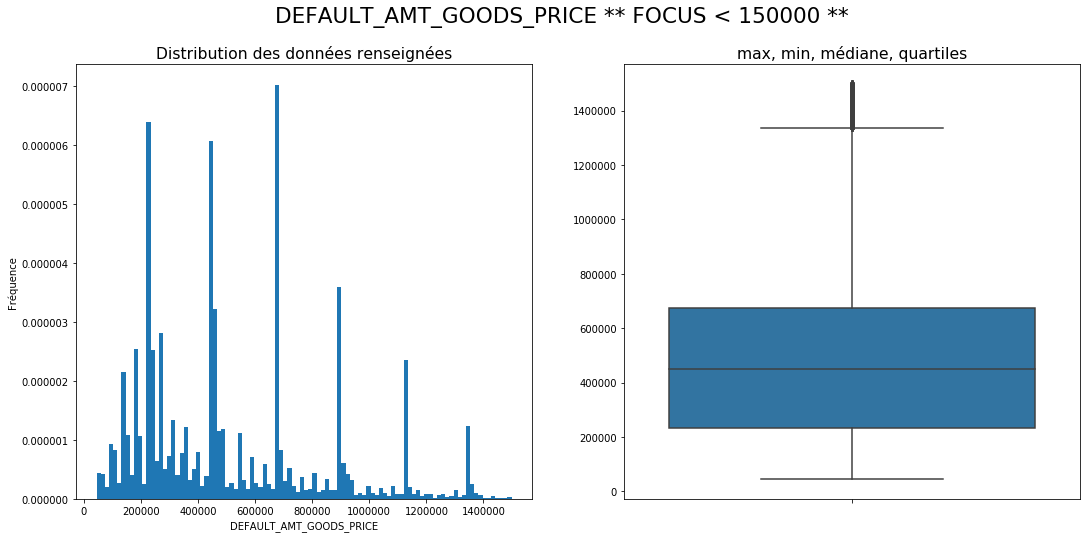

Mesures de position
 - Moyenne: 509556.17
 - Médiane: 450000.0
Mesures de dispertion
 - Ecart type: 318873.97
 - Min: 45000.0
 - Q25: 234000.0
 - Q75: 675000.0
 - Max: 1498500.0
Mesures de forme
 - Skewness (asymétrie): 0.85
 - Kurtosis (applatissement): 0.01


In [81]:
try:
    myDf(dfApplicationWorked).Stat('DEFAULT_AMT_GOODS_PRICE', pltTitle='DEFAULT_AMT_GOODS_PRICE')
    myDf(dfApplicationWorked[dfApplicationWorked.DEFAULT_AMT_GOODS_PRICE <= 1500000]).Stat('DEFAULT_AMT_GOODS_PRICE', pltTitle='DEFAULT_AMT_GOODS_PRICE ** FOCUS < 1500000 **')
    statImbalancedOutlier(dfApplicationWorked,feature='DEFAULT_AMT_GOODS_PRICE', nb_points=1000, limit_outlier = 0)
except:
    pass

#### DEFAULT_BURO_DAYS_CREDIT_UPDATE ** VU **

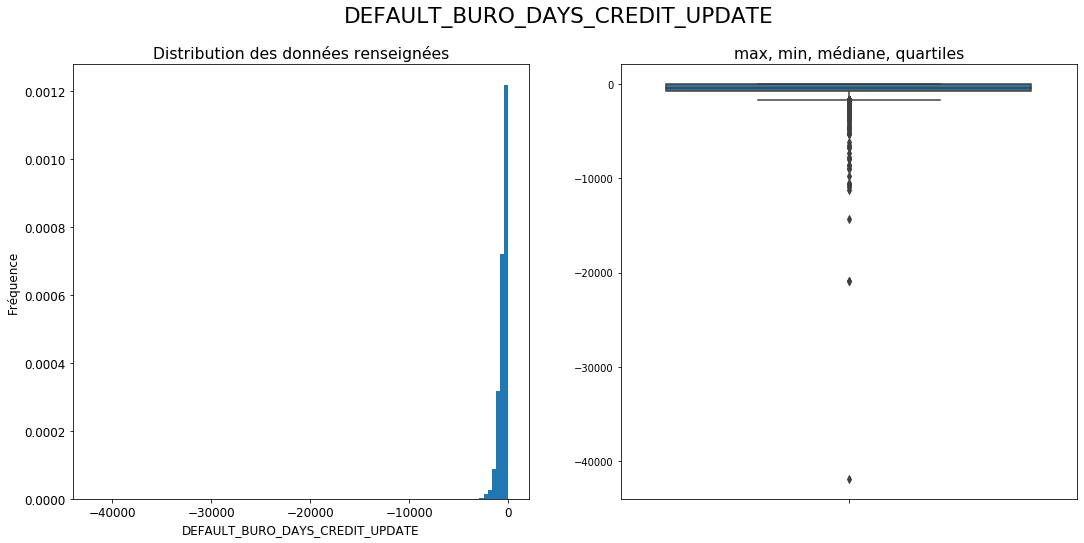

Mesures de position
 - Moyenne: -467.76
 - Médiane: -392.0
Mesures de dispertion
 - Ecart type: 465.53
 - Min: -41890.0
 - Q25: -720.12
 - Q75: -57.17
 - Max: 14.0
Mesures de forme
 - Skewness (asymétrie): -5.81
 - Kurtosis (applatissement): 341.35


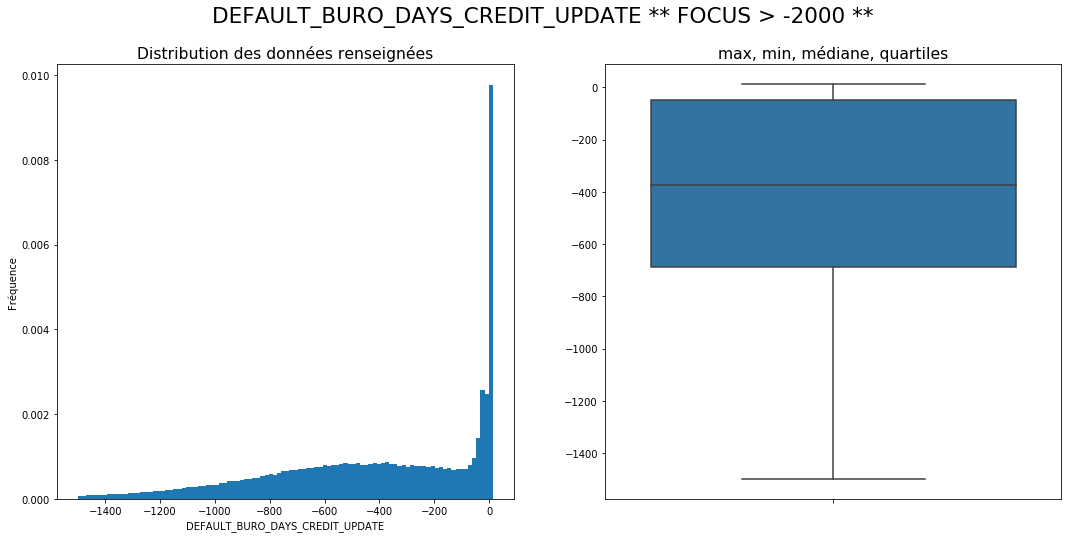

Mesures de position
 - Moyenne: -426.59
 - Médiane: -375.5
Mesures de dispertion
 - Ecart type: 376.11
 - Min: -1500.0
 - Q25: -689.0
 - Q75: -50.0
 - Max: 14.0
Mesures de forme
 - Skewness (asymétrie): -0.63
 - Kurtosis (applatissement): -0.5


In [69]:
try:
    myDf(dfApplicationWorked).Stat('DEFAULT_BURO_DAYS_CREDIT_UPDATE', pltTitle="DEFAULT_BURO_DAYS_CREDIT_UPDATE")
    myDf(dfApplicationWorked[dfApplicationWorked.DEFAULT_BURO_DAYS_CREDIT_UPDATE >= -1500]).Stat('DEFAULT_BURO_DAYS_CREDIT_UPDATE', pltTitle='DEFAULT_BURO_DAYS_CREDIT_UPDATE ** FOCUS > -1500 **')
    statImbalancedOutlier(dfApplicationWorked,feature='DEFAULT_BURO_DAYS_CREDIT_UPDATE', nb_points=1000, limit_outlier = -0.01)
except:
    pass

#### DEFAULT_PREV_CNT_PAYMENT

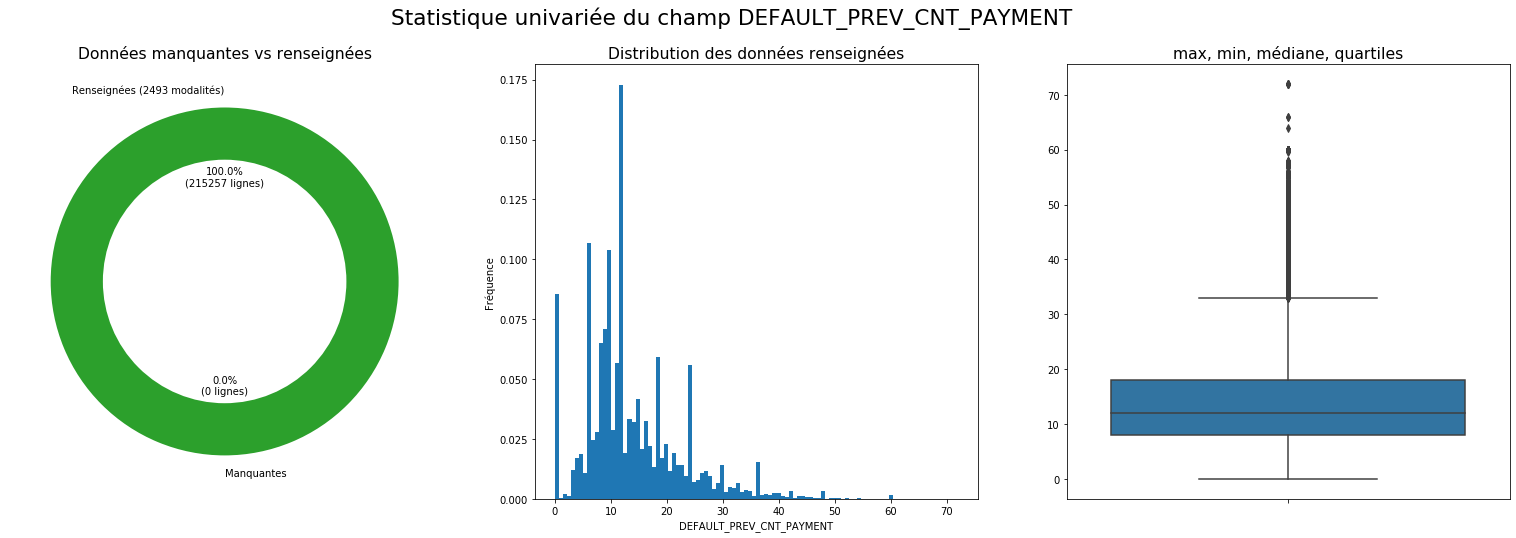

Mesures de position
 - Moyenne: 13.74
 - Médiane: 12.0
Mesures de dispertion
 - Ecart type: 8.84
 - Min: 0.0
 - Q25: 8.0
 - Q75: 18.0
 - Max: 72.0
Mesures de forme
 - Skewness (asymétrie): 1.2
 - Kurtosis (applatissement): 2.24


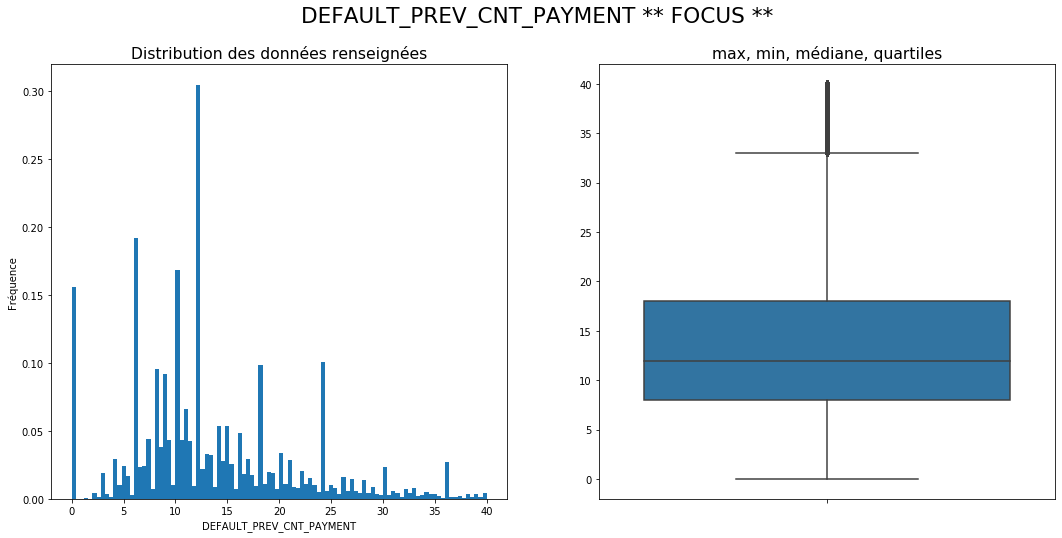

Mesures de position
 - Moyenne: 13.33
 - Médiane: 12.0
Mesures de dispertion
 - Ecart type: 8.05
 - Min: 0.0
 - Q25: 8.0
 - Q75: 18.0
 - Max: 40.0
Mesures de forme
 - Skewness (asymétrie): 0.82
 - Kurtosis (applatissement): 0.58


In [74]:
try:
    myDf(dfApplicationWorked).Stat('DEFAULT_PREV_CNT_PAYMENT', statsNan=True)
    myDf(dfApplicationWorked[dfApplicationWorked.DEFAULT_PREV_CNT_PAYMENT <= 40]).Stat('DEFAULT_PREV_CNT_PAYMENT', pltTitle='DEFAULT_PREV_CNT_PAYMENT ** FOCUS **')
    statImbalancedOutlier(dfApplicationWorked,feature='DEFAULT_PREV_CNT_PAYMENT', nb_points=1000, limit_outlier = 0)
except:
    pass

In [23]:
dfApplicationWorked = dfApplicationWorkedSvg.copy()


print(dfApplicationWorked.shape[0])

try:
    # VU
    dfApplicationWorked['BURO_AMT_CREDIT_MAX_OVERDUE_LOG'] = dfApplicationWorked.apply(lambda x: np.log(1+x.BURO_AMT_CREDIT_MAX_OVERDUE), axis=1)
    dfApplicationWorked['BURO_AMT_CREDIT_MAX_OVERDUE_LOG'] = dfApplicationWorked['BURO_AMT_CREDIT_MAX_OVERDUE_LOG'].astype('float64')
    del dfApplicationWorked['BURO_AMT_CREDIT_MAX_OVERDUE']
    print('BURO_AMT_CREDIT_MAX_OVERDUE')
    print(dfApplicationWorked.shape[0])
except:
    pass


try:
    #VU
    dfApplicationWorked['INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG_LOG'] = dfApplicationWorked.apply(lambda x: np.log(1+np.log(1-x.INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG)), axis=1)
    dfApplicationWorked = dfApplicationWorked[(dfApplicationWorked.INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG_LOG <= 0.1) | (dfApplicationWorked.TARGET == 1)]
    dfApplicationWorked['INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG_LOG'] = dfApplicationWorked.apply(lambda x: np.where(x.INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG_LOG > 0.1, (x.INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG_LOG-0.1)*6/190+0.04, x.INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG_LOG), axis=1)
    dfApplicationWorked['INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG_LOG'] = dfApplicationWorked['INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG_LOG'].astype('float64')
    del dfApplicationWorked['INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG']
    print('INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG_LOG')
    print(dfApplicationWorked.shape[0])
except:
    pass
try:
    #VU
    dfApplicationWorked = dfApplicationWorked[(dfApplicationWorked.INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS <= 0.02) | (dfApplicationWorked.TARGET == 1)]
    dfApplicationWorked['INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS'] = dfApplicationWorked.apply(lambda x: np.where(x.INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS >= 0.02, (x.INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS-0.02)*3/16+0.005, x.INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS), axis=1)
    dfApplicationWorked['INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS'] = dfApplicationWorked['INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS'].astype('float64')
    print('INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS')
    print(dfApplicationWorked.shape[0])
except:
    pass
try:
    # VU
    dfApplicationWorked['DEFAULT_PREV_AMT_DOWN_PAYMENT_LOG'] = dfApplicationWorked.apply(lambda x: np.log(1+x.DEFAULT_PREV_AMT_DOWN_PAYMENT), axis=1)
    dfApplicationWorked['DEFAULT_PREV_AMT_DOWN_PAYMENT_LOG'] = dfApplicationWorked['DEFAULT_PREV_AMT_DOWN_PAYMENT_LOG'].astype('float64')
    del dfApplicationWorked['DEFAULT_PREV_AMT_DOWN_PAYMENT']
    print('DEFAULT_PREV_AMT_DOWN_PAYMENT')
    print(dfApplicationWorked.shape[0])
except:
    pass
try:
    # VU
    dfApplicationWorked['BURO_DAYS_CREDIT_ENDDATE_POS_LOG'] = dfApplicationWorked.apply(lambda x: np.log(1+np.max([x.BURO_DAYS_CREDIT_ENDDATE,0])), axis=1)
    dfApplicationWorked['BURO_DAYS_CREDIT_ENDDATE_NEG_LOG'] = dfApplicationWorked.apply(lambda x: np.log(1-np.min([x.BURO_DAYS_CREDIT_ENDDATE,0])), axis=1)
    dfApplicationWorked['BURO_DAYS_CREDIT_ENDDATE_NEG_LOG'] = dfApplicationWorked['BURO_DAYS_CREDIT_ENDDATE_NEG_LOG'].astype('float64')
    del dfApplicationWorked['BURO_DAYS_CREDIT_ENDDATE']
    print('BURO_DAYS_CREDIT_ENDDATE')
    print(dfApplicationWorked.shape[0])
except:
    pass
try:
    #VU
    dfApplicationWorked = dfApplicationWorked[(dfApplicationWorked.DEFAULT_POSCASH_CNT_INSTALMENT_FUTURE <= 20) | (dfApplicationWorked.TARGET == 1)]
    dfApplicationWorked['DEFAULT_POSCASH_CNT_INSTALMENT_FUTURE'] = dfApplicationWorked.apply(lambda x: np.where(x.DEFAULT_POSCASH_CNT_INSTALMENT_FUTURE >=20, (x.DEFAULT_POSCASH_CNT_INSTALMENT_FUTURE-20)/4+10, x.DEFAULT_POSCASH_CNT_INSTALMENT_FUTURE) , axis=1)
    dfApplicationWorked['DEFAULT_POSCASH_CNT_INSTALMENT_FUTURE'] = dfApplicationWorked['DEFAULT_POSCASH_CNT_INSTALMENT_FUTURE'].astype('float64')
    print('DEFAULT_POSCASH_CNT_INSTALMENT_FUTURE')
    print(dfApplicationWorked.shape[0])
except:
    pass
try:
    #VU
    dfApplicationWorked['DAYS_EMPLOYED'] = -dfApplicationWorked['DAYS_EMPLOYED']
    dfApplicationWorked = dfApplicationWorked[(dfApplicationWorked.DAYS_EMPLOYED <= 7500) | (dfApplicationWorked.TARGET == 1)]
    dfApplicationWorked['DAYS_EMPLOYED'] = dfApplicationWorked.apply(lambda x: np.where(x.DAYS_EMPLOYED>=7500, (x.DAYS_EMPLOYED-7500)*1/5+2500, x.DEFAULT_POSCASH_CNT_INSTALMENT_FUTURE) , axis=1)
    dfApplicationWorked['DAYS_EMPLOYED'] = dfApplicationWorked['DAYS_EMPLOYED'].astype('float64')
    print('DAYS_EMPLOYED')
    print(dfApplicationWorked.shape[0])
except:
    pass
try:
    #VU
    dfApplicationWorked = dfApplicationWorked[(dfApplicationWorked.PREV_DAYS_DIFF <= 800) | (dfApplicationWorked.TARGET == 1)]
    dfApplicationWorked['PREV_DAYS_DIFF'] = dfApplicationWorked.apply(lambda x: np.where(x.PREV_DAYS_DIFF>=800, (x.PREV_DAYS_DIFF-800)*5/8+300, x.PREV_DAYS_DIFF) , axis=1)
    dfApplicationWorked['PREV_DAYS_DIFF'] = dfApplicationWorked['PREV_DAYS_DIFF'].astype('float64')
    print('PREV_DAYS_DIFF')
    print(dfApplicationWorked.shape[0])
except:
    pass
try:
    #VU
    dfApplicationWorked = dfApplicationWorked[(dfApplicationWorked.DEFAULT_AMT_GOODS_PRICE <= 1500000) | (dfApplicationWorked.TARGET == 1)]
    dfApplicationWorked['DEFAULT_AMT_GOODS_PRICE'] = dfApplicationWorked.apply(lambda x: np.where(x.DEFAULT_AMT_GOODS_PRICE>=1500000, (x.DEFAULT_AMT_GOODS_PRICE-1500000)*57/100+75000, x.DEFAULT_AMT_GOODS_PRICE) , axis=1)
    dfApplicationWorked['DEFAULT_AMT_GOODS_PRICE'] = dfApplicationWorked['DEFAULT_AMT_GOODS_PRICE'].astype('float64')
    print('DEFAULT_AMT_GOODS_PRICE')
    print(dfApplicationWorked.shape[0])
except:
    pass
try:
    #VU
    dfApplicationWorked['DEFAULT_BURO_DAYS_CREDIT_UPDATE'] = -dfApplicationWorked['DEFAULT_BURO_DAYS_CREDIT_UPDATE']
    dfApplicationWorked = dfApplicationWorked[(dfApplicationWorked.DEFAULT_BURO_DAYS_CREDIT_UPDATE <= 1500) | (dfApplicationWorked.TARGET == 1)]
    dfApplicationWorked['DEFAULT_BURO_DAYS_CREDIT_UPDATE'] = dfApplicationWorked.apply(lambda x: np.where(x.DEFAULT_BURO_DAYS_CREDIT_UPDATE>=1500, (x.DEFAULT_BURO_DAYS_CREDIT_UPDATE-1500)*3/154+750, x.DEFAULT_BURO_DAYS_CREDIT_UPDATE) , axis=1)
    dfApplicationWorked['DEFAULT_BURO_DAYS_CREDIT_UPDATE'] = dfApplicationWorked['DEFAULT_BURO_DAYS_CREDIT_UPDATE'].astype('float64')
    print('DEFAULT_BURO_DAYS_CREDIT_UPDATE')
    print(dfApplicationWorked.shape[0])
except:
    pass
try:
    #VU
    dfApplicationWorked = dfApplicationWorked[(dfApplicationWorked.DEFAULT_PREV_CNT_PAYMENT <= 40) | (dfApplicationWorked.TARGET == 1)]
    dfApplicationWorked['DEFAULT_PREV_CNT_PAYMENT'] = dfApplicationWorked.apply(lambda x: np.where(x.DEFAULT_PREV_CNT_PAYMENT>=40, (x.DEFAULT_PREV_CNT_PAYMENT-40)/2+20, x.DEFAULT_PREV_CNT_PAYMENT) , axis=1)
    dfApplicationWorked['DEFAULT_PREV_CNT_PAYMENT'] = dfApplicationWorked['DEFAULT_PREV_CNT_PAYMENT'].astype('float64')
    print('DEFAULT_PREV_CNT_PAYMENT')
    print(dfApplicationWorked.shape[0])
except:
    pass
#try:
#    dfApplicationWorked['PREV_NAME_CONTRACT_STATUS'] = dfApplicationWorked.apply(lambda x: x.PREV_NAME_CONTRACT_STATUS+1; axis=1)
#    dfApplicationWorked['DEFAULT_BURO_DAYS_ENDDATE_FACT'] = -dfApplicationWorked['DEFAULT_BURO_DAYS_ENDDATE_FACT']
#except:
#    pass
#print(dfApplicationWorked.shape[0])

215257
BURO_AMT_CREDIT_MAX_OVERDUE
215257
INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG_LOG
206077
INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS
205833
DEFAULT_PREV_AMT_DOWN_PAYMENT
205833
BURO_DAYS_CREDIT_ENDDATE
205833
DEFAULT_POSCASH_CNT_INSTALMENT_FUTURE
194457
DAYS_EMPLOYED
187572
PREV_DAYS_DIFF
185454
DEFAULT_AMT_GOODS_PRICE
181397
DEFAULT_BURO_DAYS_CREDIT_UPDATE
176933
DEFAULT_PREV_CNT_PAYMENT
176127


In [24]:
from pickle import dump
dump(dfApplicationWorked, open('ApplicationWorked_wo_outliers.pkl','wb'))

In [29]:
dfApplicationWorked.dtypes

SK_ID_CURR                                             int64
TARGET                                                 int64
CODE_GENDER                                            int64
DAYS_BIRTH                                             int64
DAYS_EMPLOYED                                        float64
ORGANIZATION_TYPE                                     object
EXT_SOURCE_2                                         float64
EXT_SOURCE_3                                         float64
PREV_DAYS_DIFF                                       float64
PREV_NAME_CONTRACT_STATUS                            float64
PREV_DAYS_DECISION                                   float64
PREV_NAME_YIELD_GROUP                                float64
INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS         float64
BURO_CREDIT_ACTIVE                                   float64
BURO_DAYS_CREDIT                                     float64
DEFAULT_EXT_SOURCE_1                                 float64
DEFAULT_BURO_DAYS_CREDIT

In [89]:
for col in dfApplicationWorked.columns:
    print(dfApplicationWorked[col].dtypes)
    print(col)
    if dfApplicationWorked[col].dtypes == 'object':
        print(col)

float64
SK_ID_CURR
int64
TARGET
int64
CODE_GENDER
float64
DAYS_BIRTH
float64
DAYS_EMPLOYED
int64
ORGANIZATION_TYPE
float64
EXT_SOURCE_2
float64
EXT_SOURCE_3
float64
PREV_DAYS_DIFF
float64
PREV_NAME_CONTRACT_STATUS
float64
PREV_DAYS_DECISION
float64
PREV_NAME_YIELD_GROUP
float64
INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS
float64
BURO_CREDIT_ACTIVE
float64
BURO_DAYS_CREDIT
float64
DEFAULT_EXT_SOURCE_1
float64
DEFAULT_BURO_DAYS_CREDIT_UPDATE
float64
DEFAULT_POSCASH_CNT_INSTALMENT_FUTURE
float64
DEFAULT_PREV_CNT_PAYMENT
float64
DEFAULT_BURO_DAYS_ENDDATE_FACT
float64
DEFAULT_AMT_GOODS_PRICE
float64
BURO_AMT_CREDIT_MAX_OVERDUE_LOG
float64
INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG_LOG
float64
DEFAULT_PREV_AMT_DOWN_PAYMENT_LOG
float64
BURO_DAYS_CREDIT_ENDDATE_POS_LOG
float64
BURO_DAYS_CREDIT_ENDDATE_NEG_LOG


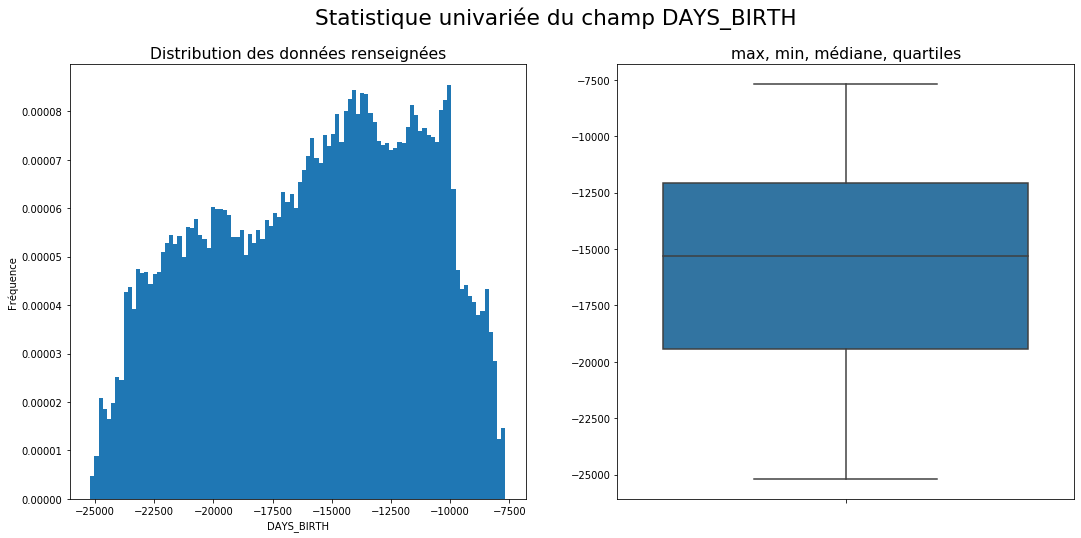

Mesures de position
 - Moyenne: -15748.48
 - Médiane: -15292.0
Mesures de dispertion
 - Ecart type: 4411.68
 - Min: -25197
 - Q25: -19419.0
 - Q75: -12056.0
 - Max: -7673
Mesures de forme
 - Skewness (asymétrie): -0.21
 - Kurtosis (applatissement): -1.03


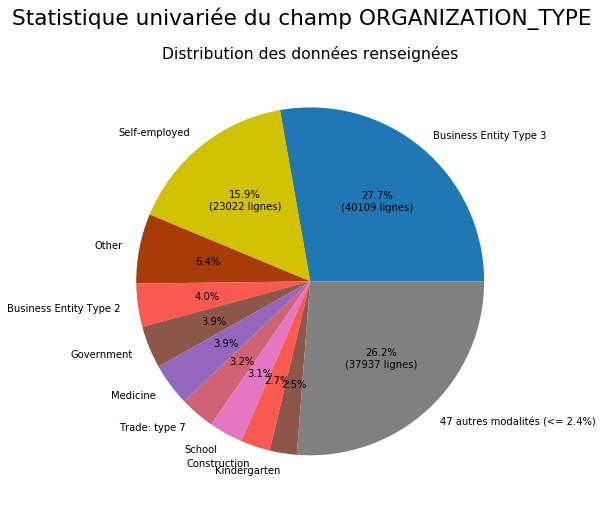

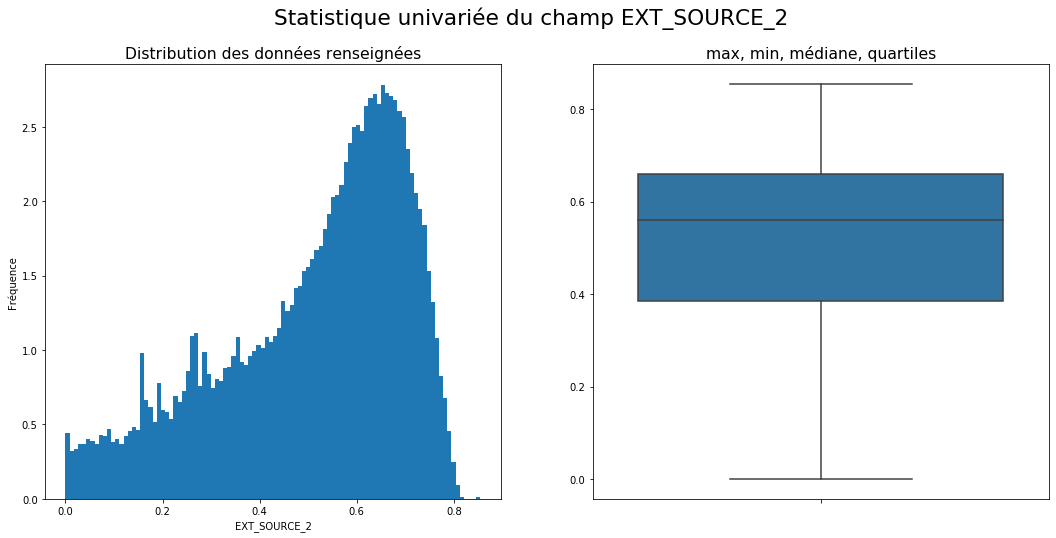

Mesures de position
 - Moyenne: 0.51
 - Médiane: 0.56
Mesures de dispertion
 - Ecart type: 0.19
 - Min: 0.0
 - Q25: 0.38
 - Q75: 0.66
 - Max: 0.85
Mesures de forme
 - Skewness (asymétrie): -0.77
 - Kurtosis (applatissement): -0.32


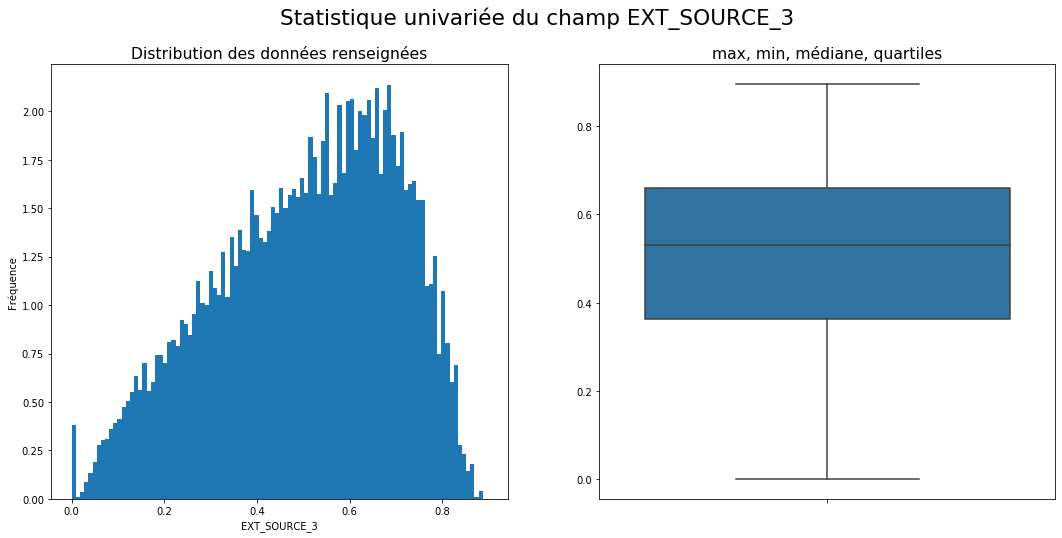

Mesures de position
 - Moyenne: 0.51
 - Médiane: 0.53
Mesures de dispertion
 - Ecart type: 0.19
 - Min: 0.0
 - Q25: 0.36
 - Q75: 0.66
 - Max: 0.9
Mesures de forme
 - Skewness (asymétrie): -0.39
 - Kurtosis (applatissement): -0.69


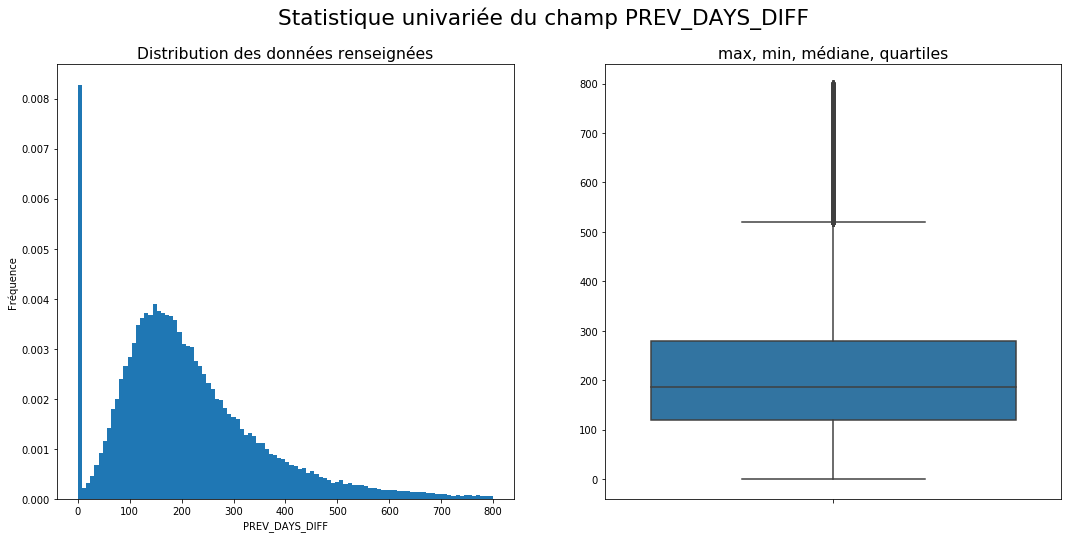

Mesures de position
 - Moyenne: 212.08
 - Médiane: 186.36
Mesures de dispertion
 - Ecart type: 141.81
 - Min: 0.0
 - Q25: 118.78
 - Q75: 279.32
 - Max: 799.67
Mesures de forme
 - Skewness (asymétrie): 1.09
 - Kurtosis (applatissement): 1.59


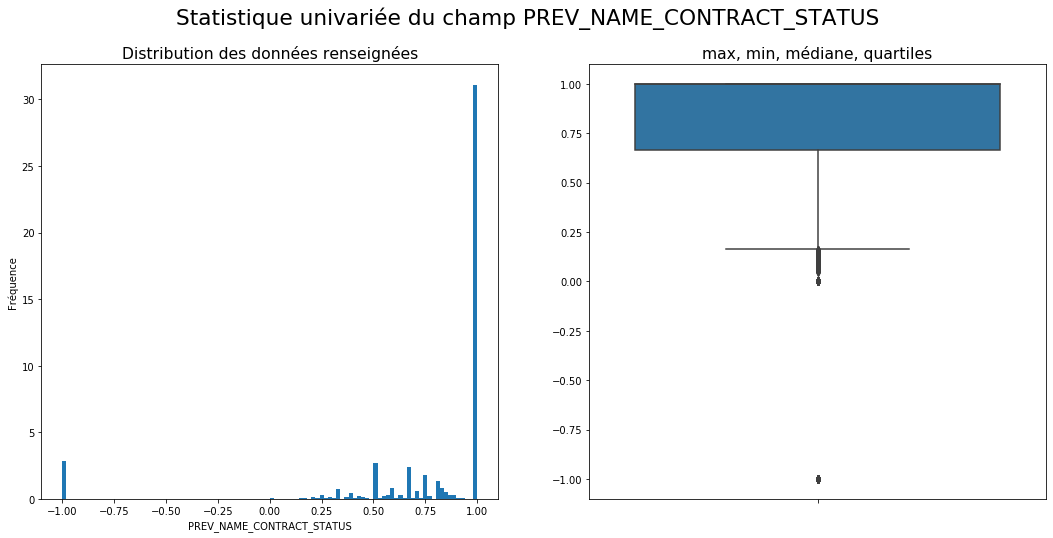

Mesures de position
 - Moyenne: 0.76
 - Médiane: 1.0
Mesures de dispertion
 - Ecart type: 0.48
 - Min: -1.0
 - Q25: 0.67
 - Q75: 1.0
 - Max: 1.0
Mesures de forme
 - Skewness (asymétrie): -2.83
 - Kurtosis (applatissement): 7.58


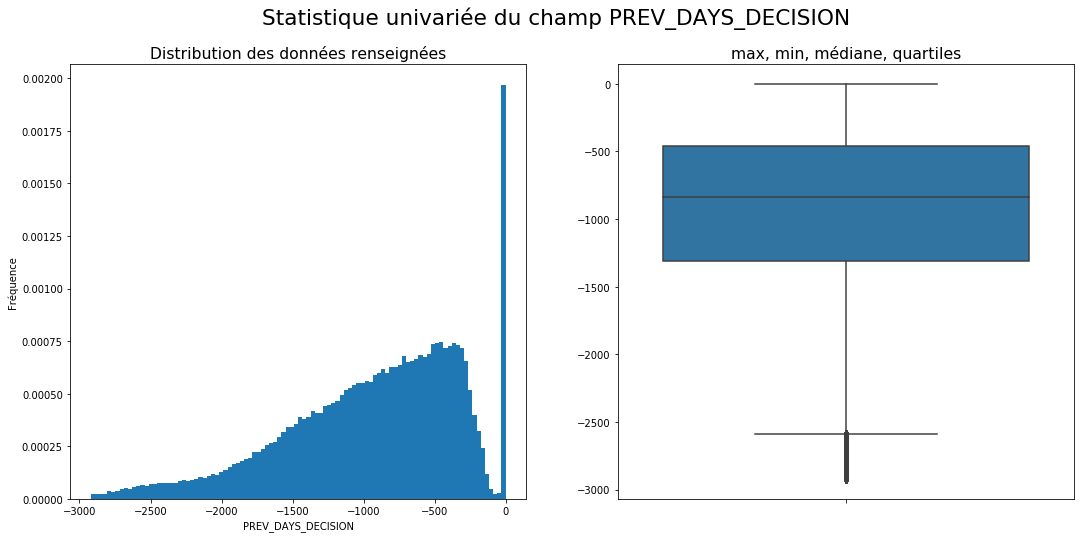

Mesures de position
 - Moyenne: -932.95
 - Médiane: -835.0
Mesures de dispertion
 - Ecart type: 612.21
 - Min: -2922.0
 - Q25: -1313.0
 - Q75: -462.0
 - Max: 0.0
Mesures de forme
 - Skewness (asymétrie): -0.72
 - Kurtosis (applatissement): 0.11


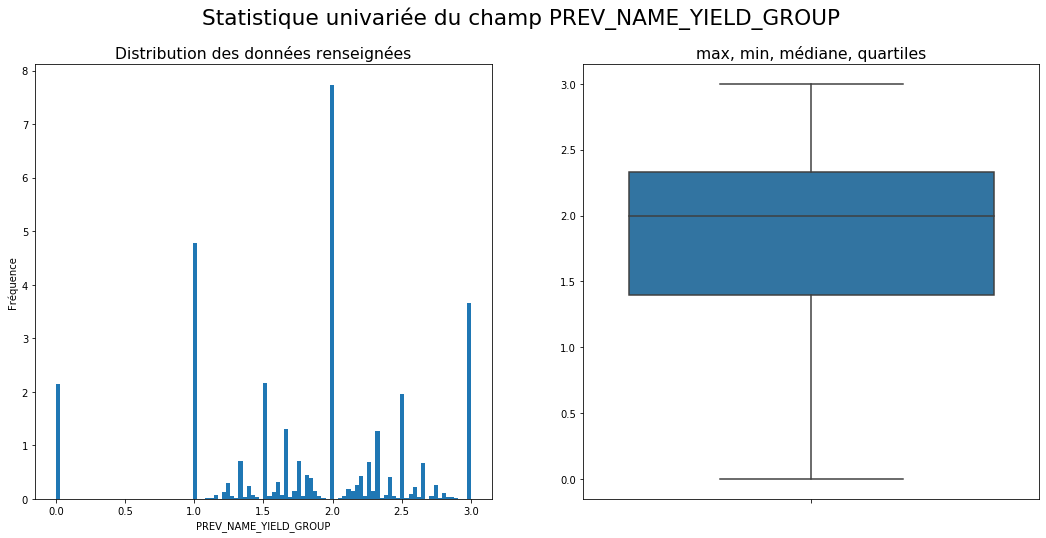

Mesures de position
 - Moyenne: 1.83
 - Médiane: 2.0
Mesures de dispertion
 - Ecart type: 0.76
 - Min: 0.0
 - Q25: 1.4
 - Q75: 2.33
 - Max: 3.0
Mesures de forme
 - Skewness (asymétrie): -0.57
 - Kurtosis (applatissement): 0.12


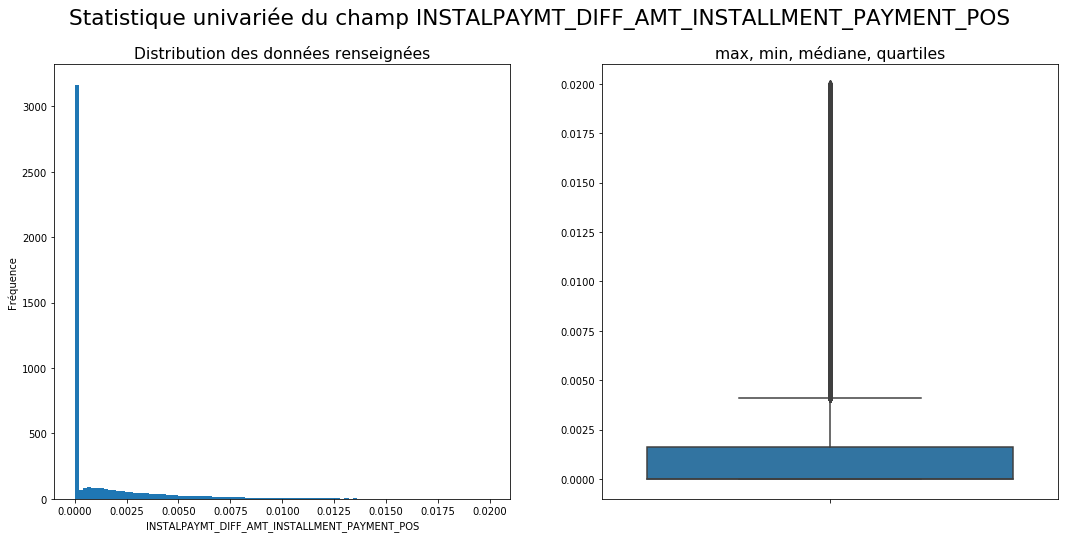

Mesures de position
 - Moyenne: 0.0
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 0.0
 - Min: 0.0
 - Q25: 0.0
 - Q75: 0.0
 - Max: 0.02
Mesures de forme
 - Skewness (asymétrie): 2.76
 - Kurtosis (applatissement): 8.78


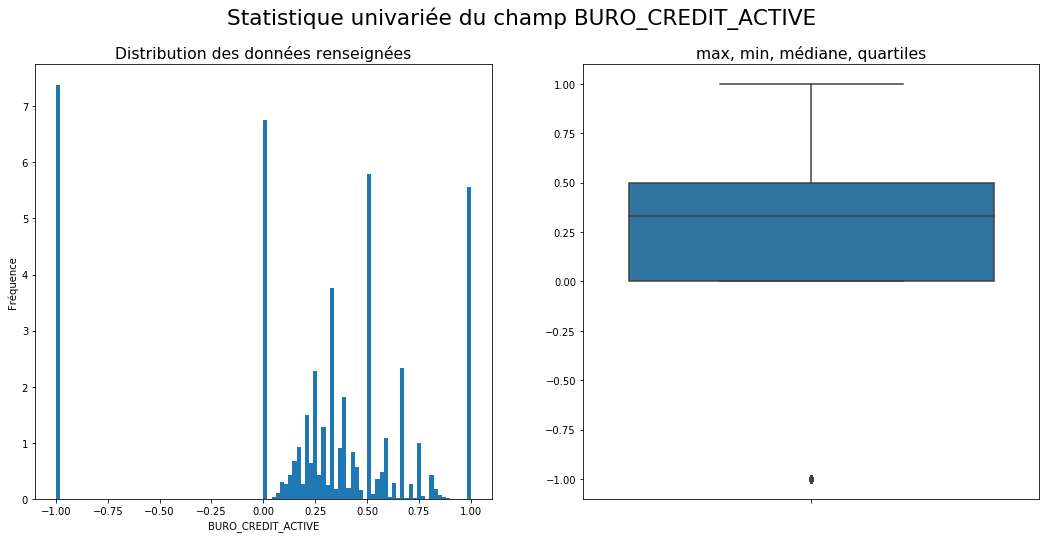

Mesures de position
 - Moyenne: 0.21
 - Médiane: 0.33
Mesures de dispertion
 - Ecart type: 0.58
 - Min: -1.0
 - Q25: 0.0
 - Q75: 0.5
 - Max: 1.0
Mesures de forme
 - Skewness (asymétrie): -1.0
 - Kurtosis (applatissement): 0.29


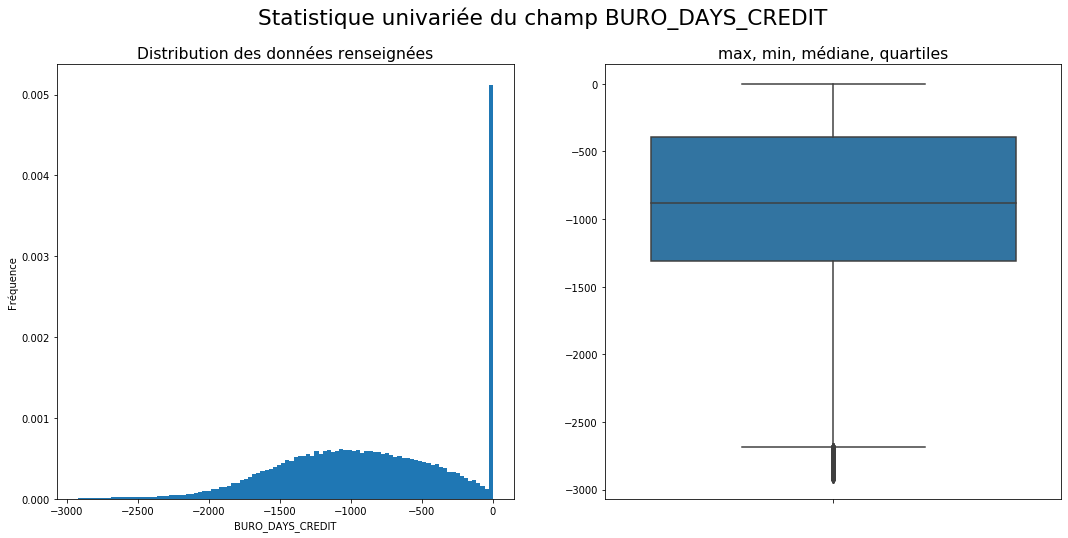

Mesures de position
 - Moyenne: -875.54
 - Médiane: -882.0
Mesures de dispertion
 - Ecart type: 604.23
 - Min: -2922.0
 - Q25: -1309.0
 - Q75: -393.58
 - Max: 0.0
Mesures de forme
 - Skewness (asymétrie): -0.26
 - Kurtosis (applatissement): -0.5


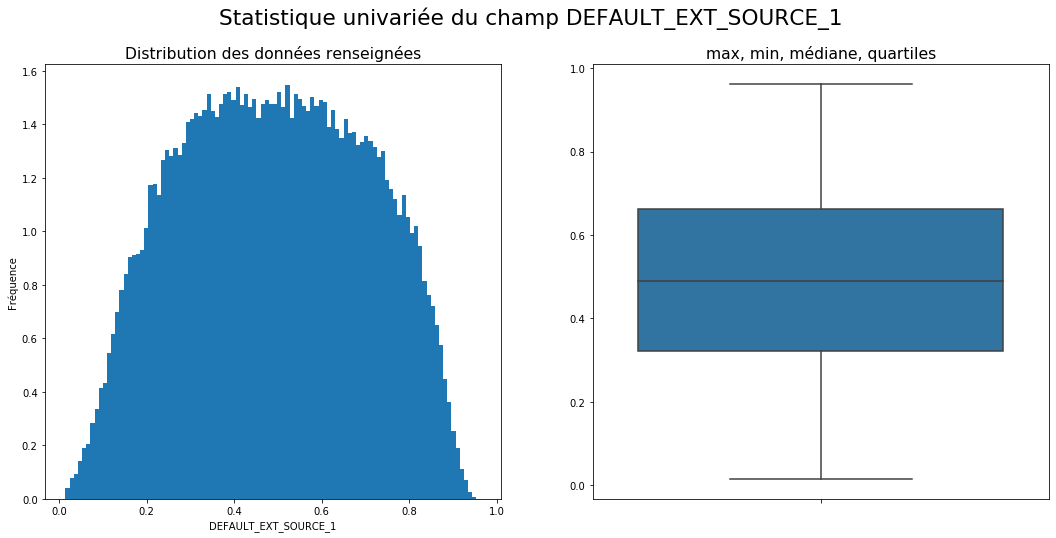

Mesures de position
 - Moyenne: 0.49
 - Médiane: 0.49
Mesures de dispertion
 - Ecart type: 0.21
 - Min: 0.01
 - Q25: 0.32
 - Q75: 0.66
 - Max: 0.96
Mesures de forme
 - Skewness (asymétrie): -0.01
 - Kurtosis (applatissement): -0.97


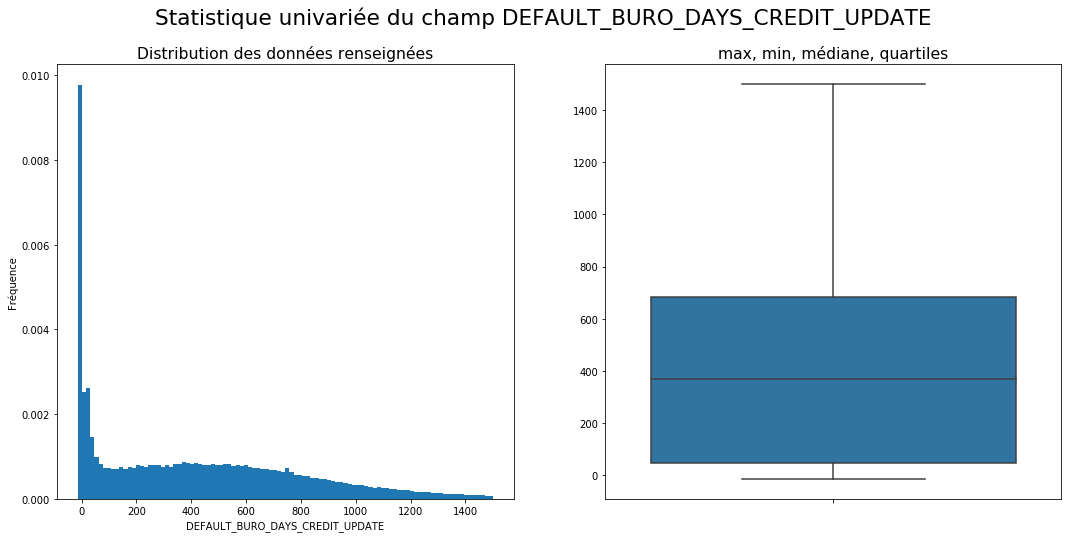

Mesures de position
 - Moyenne: 422.91
 - Médiane: 369.56
Mesures de dispertion
 - Ecart type: 375.25
 - Min: -14.0
 - Q25: 48.0
 - Q75: 685.0
 - Max: 1499.89
Mesures de forme
 - Skewness (asymétrie): 0.64
 - Kurtosis (applatissement): -0.48


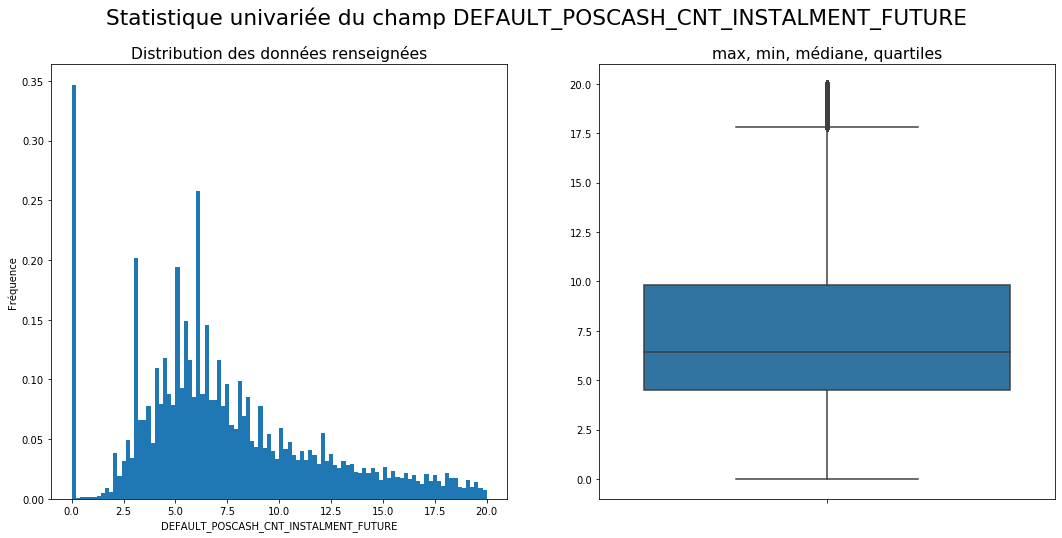

Mesures de position
 - Moyenne: 7.37
 - Médiane: 6.43
Mesures de dispertion
 - Ecart type: 4.47
 - Min: 0.0
 - Q25: 4.5
 - Q75: 9.83
 - Max: 20.0
Mesures de forme
 - Skewness (asymétrie): 0.68
 - Kurtosis (applatissement): 0.09


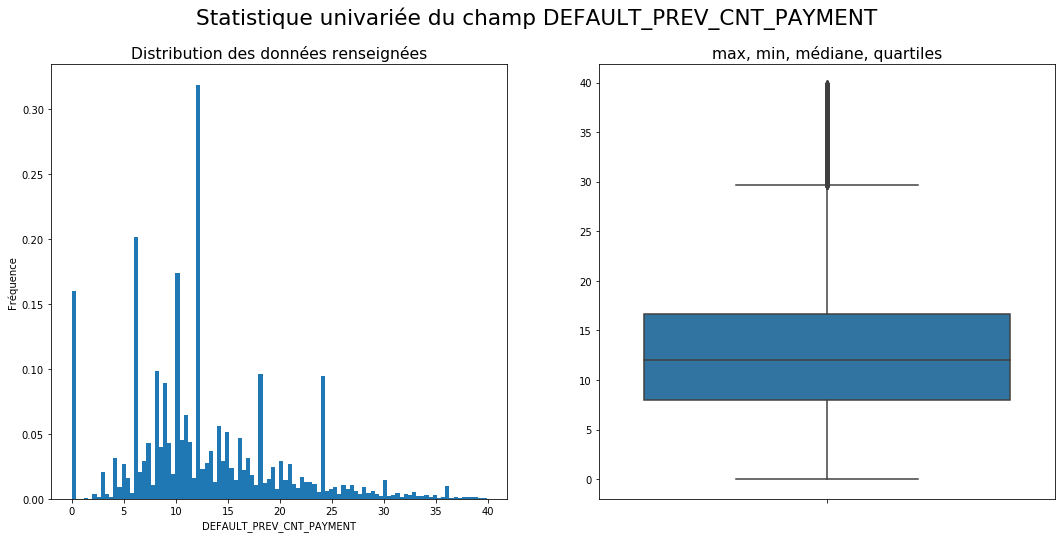

Mesures de position
 - Moyenne: 12.65
 - Médiane: 12.0
Mesures de dispertion
 - Ecart type: 7.36
 - Min: 0.0
 - Q25: 8.0
 - Q75: 16.67
 - Max: 39.88
Mesures de forme
 - Skewness (asymétrie): 0.75
 - Kurtosis (applatissement): 0.72


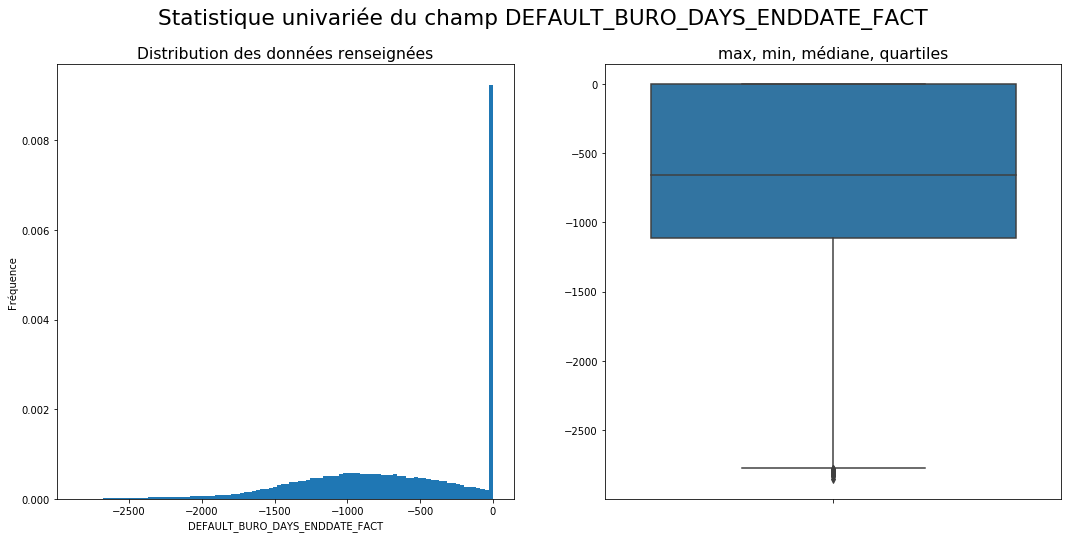

Mesures de position
 - Moyenne: -684.16
 - Médiane: -657.67
Mesures de dispertion
 - Ecart type: 593.52
 - Min: -2852.0
 - Q25: -1110.33
 - Q75: 0.0
 - Max: 0.0
Mesures de forme
 - Skewness (asymétrie): -0.54
 - Kurtosis (applatissement): -0.39


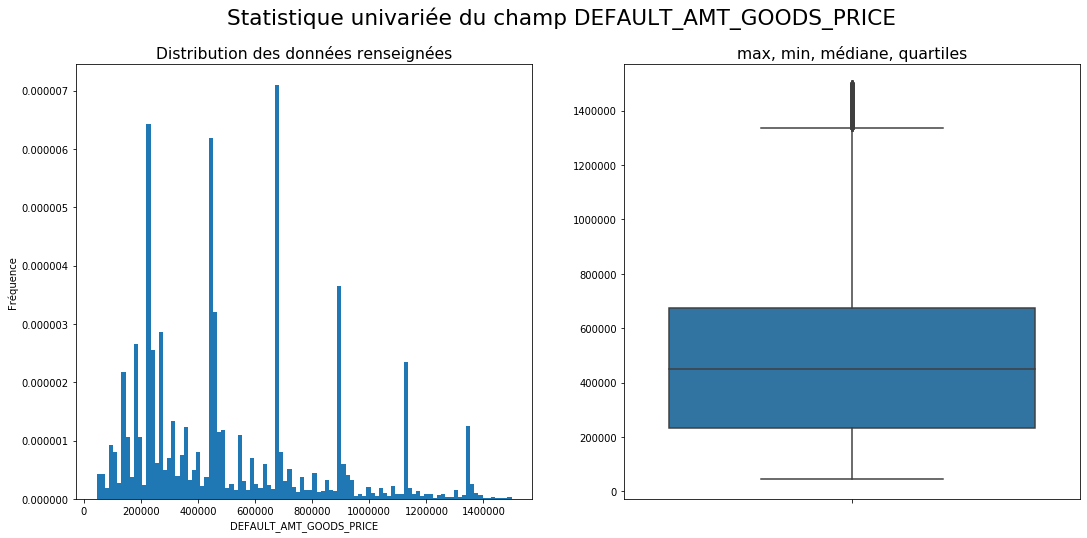

Mesures de position
 - Moyenne: 508594.69
 - Médiane: 450000.0
Mesures de dispertion
 - Ecart type: 318492.17
 - Min: 45000.0
 - Q25: 234000.0
 - Q75: 675000.0
 - Max: 1498500.0
Mesures de forme
 - Skewness (asymétrie): 0.85
 - Kurtosis (applatissement): 0.02


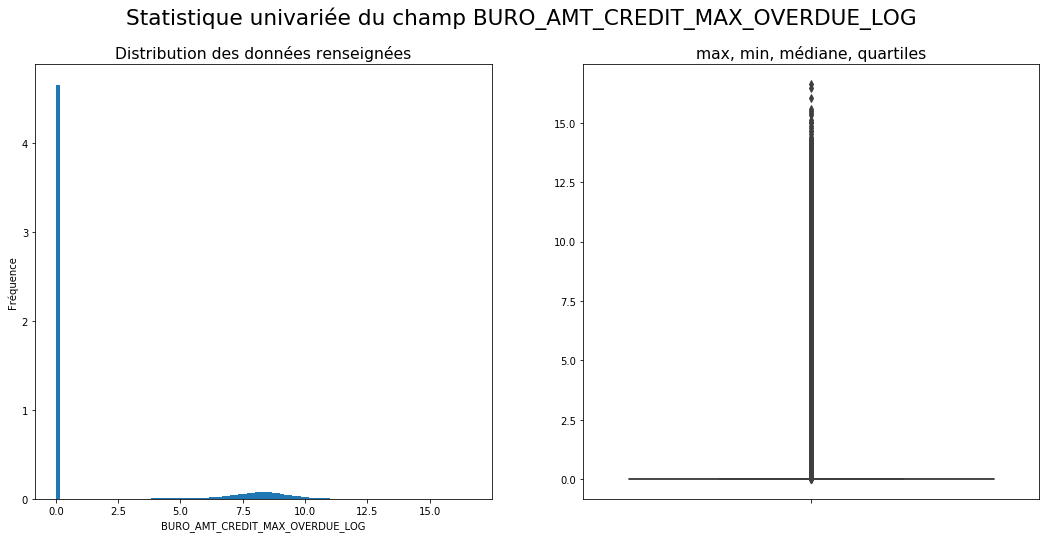

Mesures de position
 - Moyenne: 1.78
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 3.4
 - Min: 0.0
 - Q25: 0.0
 - Q75: 0.0
 - Max: 16.65
Mesures de forme
 - Skewness (asymétrie): 1.49
 - Kurtosis (applatissement): 0.41


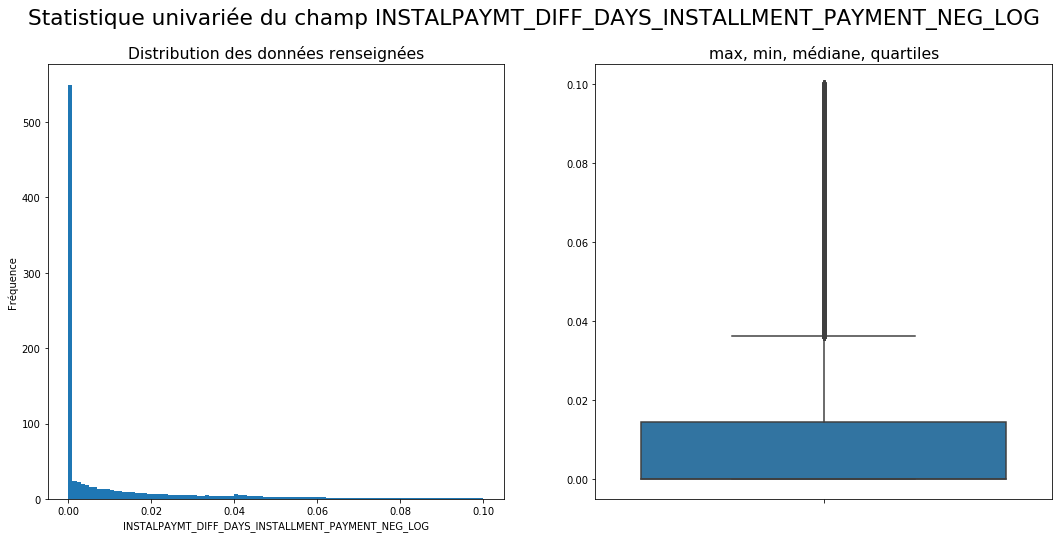

Mesures de position
 - Moyenne: 0.01
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 0.02
 - Min: 0.0
 - Q25: 0.0
 - Q75: 0.01
 - Max: 0.1
Mesures de forme
 - Skewness (asymétrie): 2.13
 - Kurtosis (applatissement): 4.12


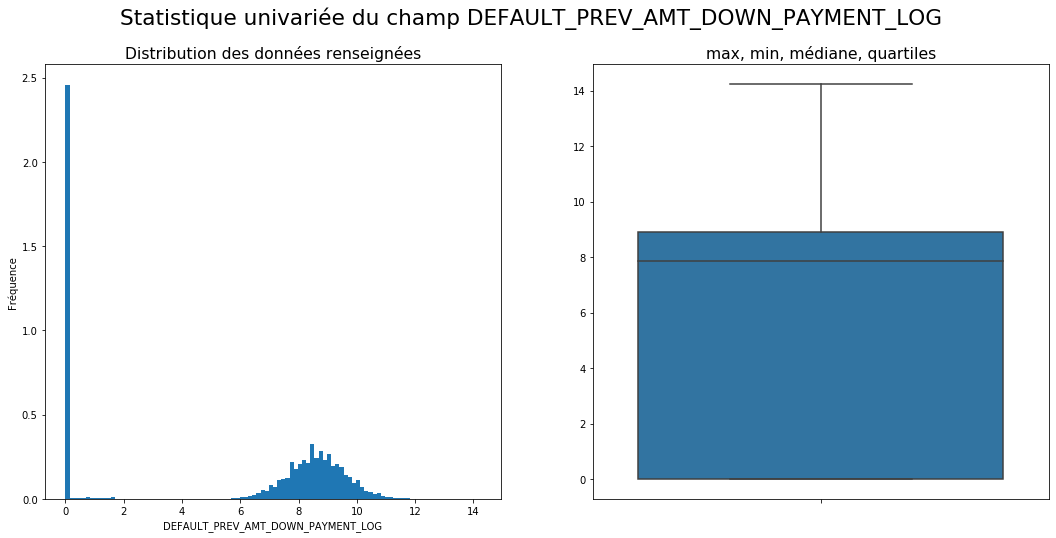

Mesures de position
 - Moyenne: 5.53
 - Médiane: 7.87
Mesures de dispertion
 - Ecart type: 4.21
 - Min: 0.0
 - Q25: 0.0
 - Q75: 8.9
 - Max: 14.24
Mesures de forme
 - Skewness (asymétrie): -0.47
 - Kurtosis (applatissement): -1.63


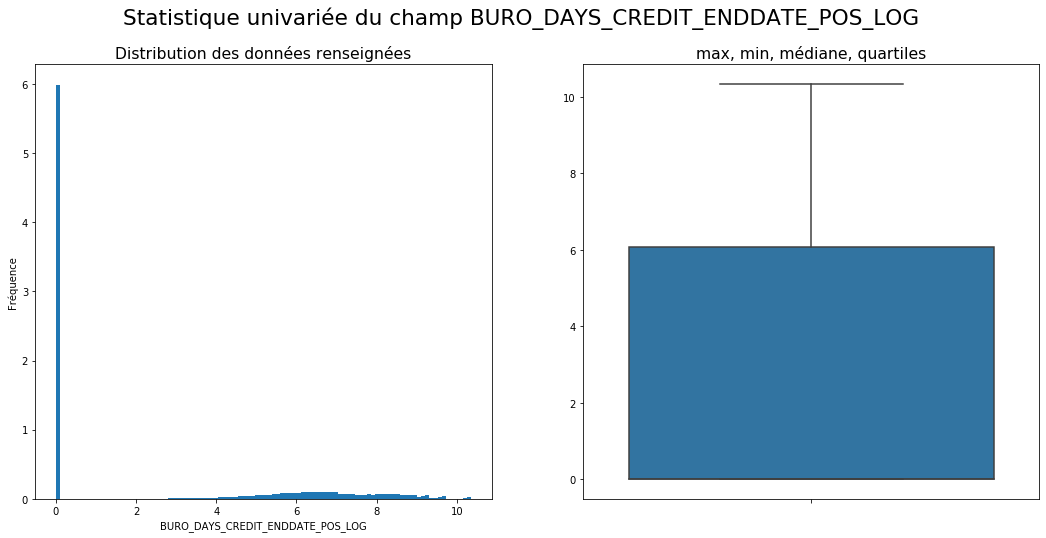

Mesures de position
 - Moyenne: 2.55
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 3.4
 - Min: 0.0
 - Q25: 0.0
 - Q75: 6.07
 - Max: 10.35
Mesures de forme
 - Skewness (asymétrie): 0.74
 - Kurtosis (applatissement): -1.18


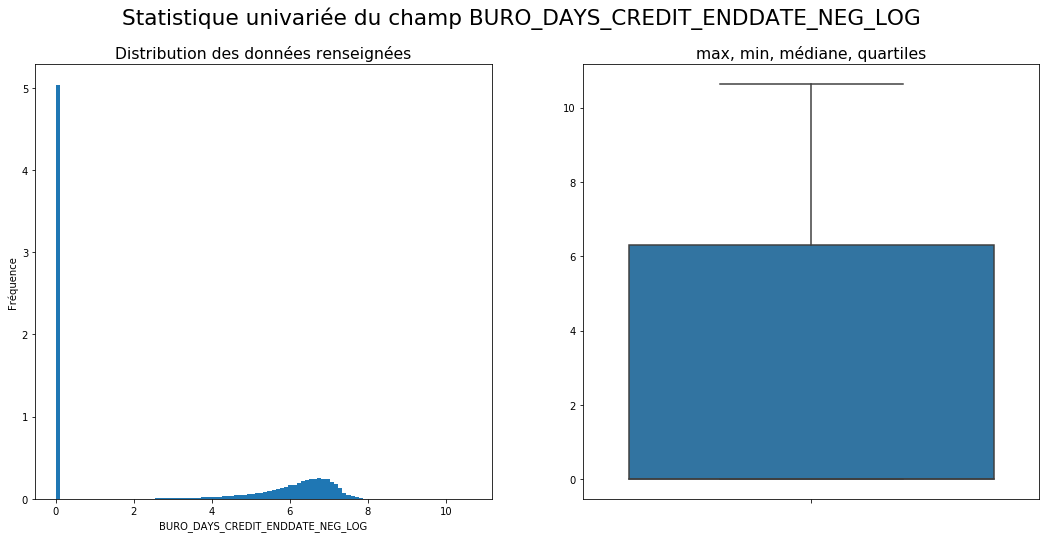

Mesures de position
 - Moyenne: 2.84
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 3.14
 - Min: 0.0
 - Q25: 0.0
 - Q75: 6.29
 - Max: 10.64
Mesures de forme
 - Skewness (asymétrie): 0.27
 - Kurtosis (applatissement): -1.81


In [44]:
myDf(dfApplicationWorked).Stat(typeStat='univ', exclCol=['DAYS_EMPLOYED','SK_ID_CURR'])

### Métriques avec et sans Over-Under sampling

 Model ROC AUC: 0.746
 No Skill ROC AUC: 0.500
 Model PR AUC: 0.309
 No Skill PR AUC: 0.549


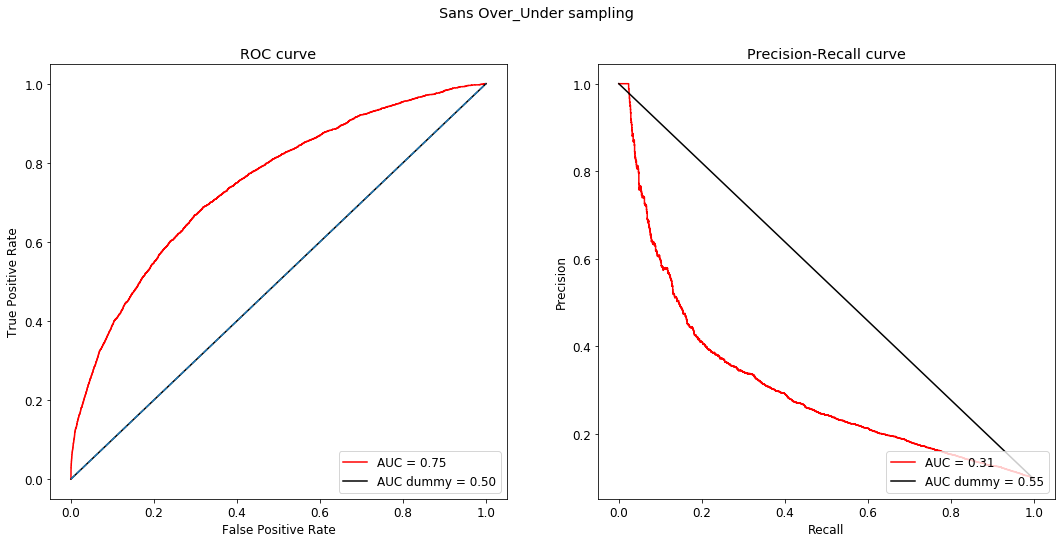

Counter({0: 126961, 1: 13940})
Counter({0: 126961, 1: 38088})
Counter({0: 76176, 1: 38088})
 Model ROC AUC: 0.747
 No Skill ROC AUC: 0.500
 Model PR AUC: 0.309
 No Skill PR AUC: 0.549


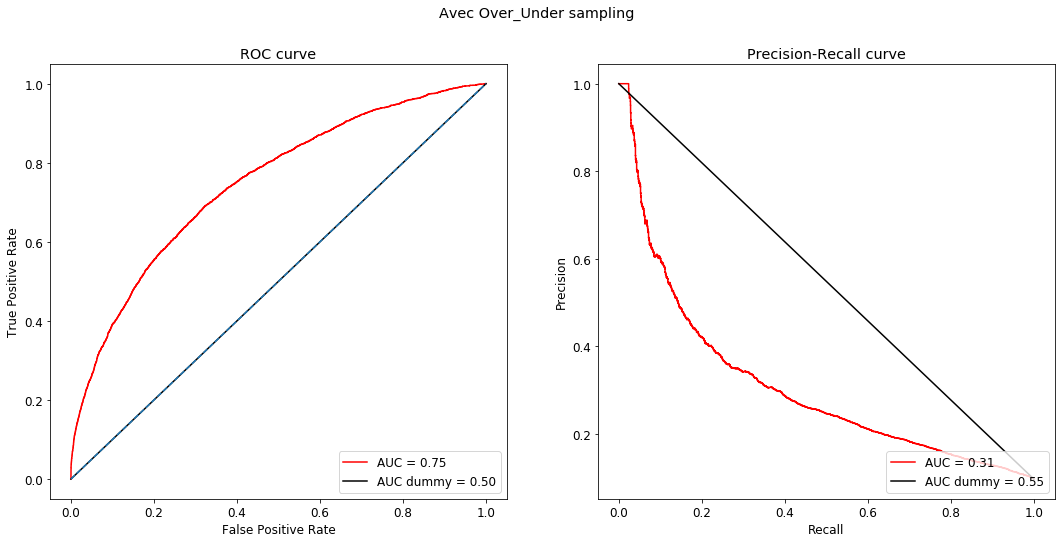

[4.794295072555542,
 9.837892770767212,
 0.7560738266700258,
 0.6203056855767214,
 2.947850227355957,
 0.747145375912585,
 0.30937987279250356,
 '']

In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from pickle import load

df = transformDf(dfApplicationWorked)

dfTrain, dfTest = train_test_split(df, test_size=0.2, random_state=1)
y_train = dfTrain['TARGET'].values
y_test = dfTest['TARGET'].values
del dfTrain['TARGET']
del dfTest['TARGET']
del dfTrain['SK_ID_CURR']
del dfTest['SK_ID_CURR']
X_train = dfTrain.values
X_test = dfTest.values
    
model = RandomForestClassifier(n_estimators=200, max_depth=5, n_jobs=-1)
metrics_model(model, X_train, y_train, X_test, y_test, display_plot=True, calc_feat_imp = False, features = [], label_model = 'Sans Over_Under sampling')

    
X_train, y_train = OverUnder(X_train, y_train)

model = RandomForestClassifier(n_estimators=200, max_depth=5, n_jobs=-1)
metrics_model(model, X_train, y_train, X_test, y_test, display_plot=True, calc_feat_imp = False, features = [], label_model = 'Avec Over_Under sampling')

In [84]:
DicoRatio={}
DicoNbPos = {}
DicoNbTot = {}
for val in dfApplicationWorkedSvg.ORGANIZATION_TYPE.unique():
    NbPositive = dfApplicationWorkedSvg[(dfApplicationWorkedSvg.ORGANIZATION_TYPE == val) &(dfApplicationWorkedSvg.TARGET == 1)].shape[0]
    NbTotal = dfApplicationWorkedSvg[dfApplicationWorkedSvg.ORGANIZATION_TYPE == val].shape[0]
    ratio = round(NbPositive / (NbTotal+0.1) * 100, 1)
    DicoRatio[val] = ratio
    DicoNbPos[val] = NbPositive
    DicoNbTot[val] = NbTotal
pd.DataFrame({'valeur': list(Dico.keys()), 'ratioPos':list(DicoRatio.values()), 'nbPos': list(DicoNbPos.values()), 'nbTot': list(DicoNbTot.values())}).sort_values('ratioPos', ascending=False)

valeur  ratioPos  nbPos  nbTot
53        Industry: type 8      19.9      3     15
31       Transport: type 3      15.9    134    841
14              Restaurant      12.1    150   1242
5             Construction      11.7    551   4713
23                 Realtor      11.5     32    279
41        Industry: type 1      11.2     78    696
22        Industry: type 3      10.8    246   2275
18             Agriculture      10.7    184   1717
13        Industry: type 4      10.6     65    611
6            Self-employed      10.2   2751  27069
40           Trade: type 1      10.1     24    237
27                Security      10.1    231   2279
17           Trade: type 3       9.8    243   2473
55           Trade: type 5       9.6      3     31
25           Trade: type 7       9.4    522   5553
4   Business Entity Type 3       9.3   4404  47544
56       Industry: type 13       9.3      4     43
29       Industry: type 11       9.1    174   1910
54       Industry: type 10       9.1      6     66
8        Transport: type 4       9.1    346   3800
2   Business Entity Type 2       8.7    642   7368
33                 Telecom       8.6     36    418
43             Advertising       8.6     25    289
24                 Housing       8.5    174   2037
45                Cleaning       8.5     15    177
16  Business Entity Type 1       8.5    356   4203
15       Transport: type 2       8.1    124   1536
51                  Mobile       8.0     17    212
49          Legal Services       7.8     17    218
7                   Postal       7.7    116   1511
9                    Other       7.6    893  11675
37        Industry: type 7       7.4     66    895
36        Industry: type 5       7.4     30    404
35        Industry: type 2       7.2     24    333
32           Trade: type 2       6.9     92   1340
10            Kindergarten       6.9    329   4751
0               Government       6.8    489   7235
12        Industry: type 9       6.7    157   2355
21                Medicine       6.7    525   7821
30             Electricity       6.5     44    672
46               Emergency       6.4     27    424
38                Services       6.4     70   1087
28                   Hotel       6.3     43    680
48        Industry: type 6       6.1      5     82
47                 Culture       5.9     15    255
11                  School       5.7    357   6226
39               Insurance       5.6     23    409
20                  Police       5.1     83   1634
34                    Bank       5.1     92   1791
42           Trade: type 6       5.0     22    440
26              University       4.9     45    911
19                Military       4.9     90   1820
3      Security Ministries       4.8     66   1376
44       Industry: type 12       4.3     10    235
57                Religion       3.9      2     51
50       Transport: type 1       3.6      5    139
52           Trade: type 4       0.0      0     43
1                      NaN       0.0      0      0

In [46]:
0.1-0.02

0.08

In [47]:
x=0.1
-0.25*(x-0.02)+0.04

0.02

## Statistiques

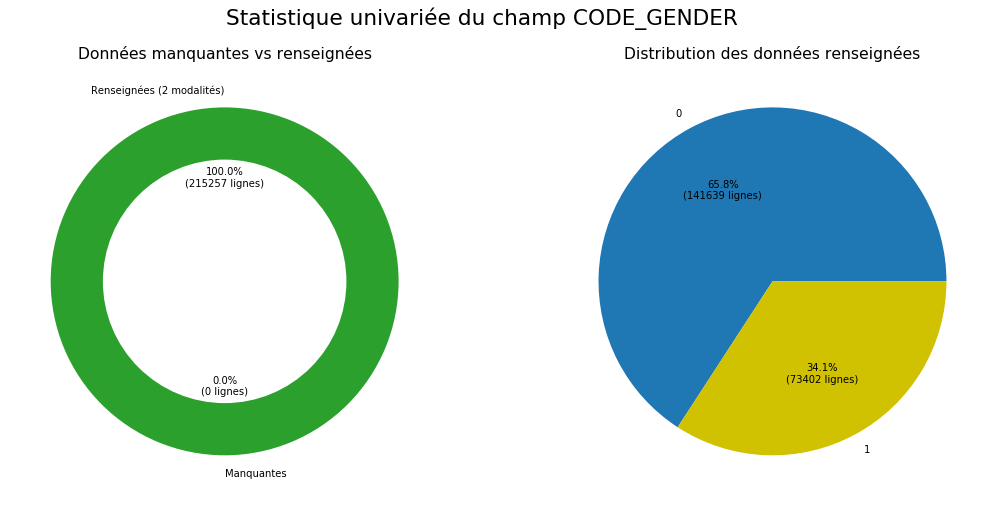

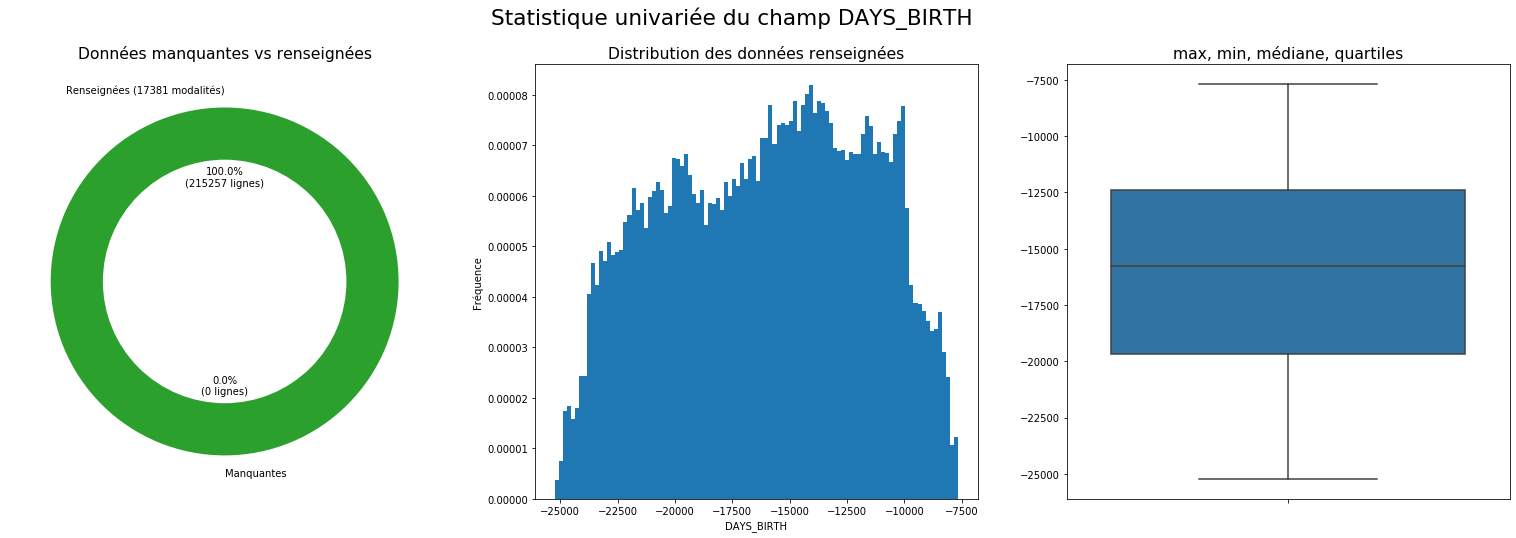

Mesures de position
 - Moyenne: -16040.39
 - Médiane: -15759.0
Mesures de dispertion
 - Ecart type: 4368.92
 - Min: -25229
 - Q25: -19694.0
 - Q75: -12411.0
 - Max: -7673
Mesures de forme
 - Skewness (asymétrie): -0.11
 - Kurtosis (applatissement): -1.05


Mesures de position
 - Moyenne: -1950.48
 - Médiane: -1209.0
Mesures de dispertion
 - Ecart type: 2304.46
 - Min: -17912
 - Q25: -2754.0
 - Q75: -289.0
 - Max: 1
Mesures de forme
 - Skewness (asymétrie): -2.05
 - Kurtosis (applatissement): 5.24


Mesures de position
 - Moyenne: 0.51
 - Médiane: 0.57
Mesures de dispertion
 - Ecart type: 0.19
 - Min: 0.0
 - Q25: 0.39
 - Q75: 0.66
 - Max: 0.85
Mesures de forme
 - Skewness (asymétrie): -0.79
 - Kurtosis (applatissement): -0.28


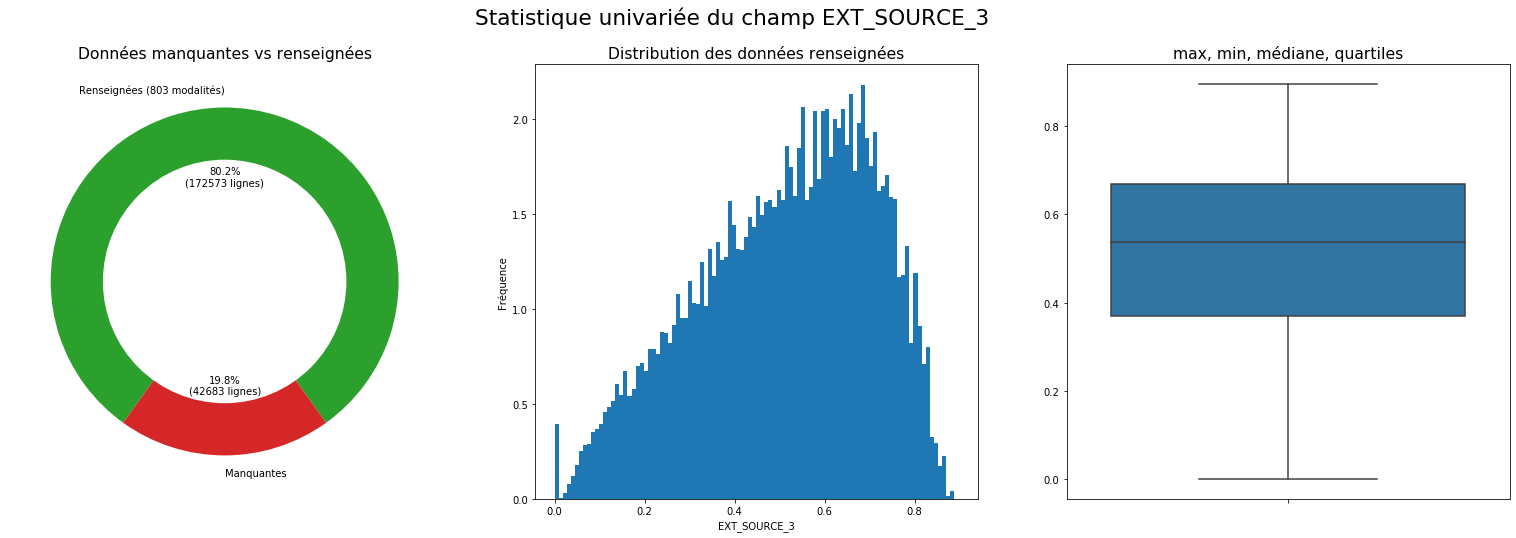

Mesures de position
 - Moyenne: 0.51
 - Médiane: 0.54
Mesures de dispertion
 - Ecart type: 0.19
 - Min: 0.0
 - Q25: 0.37
 - Q75: 0.67
 - Max: 0.9
Mesures de forme
 - Skewness (asymétrie): -0.41
 - Kurtosis (applatissement): -0.66


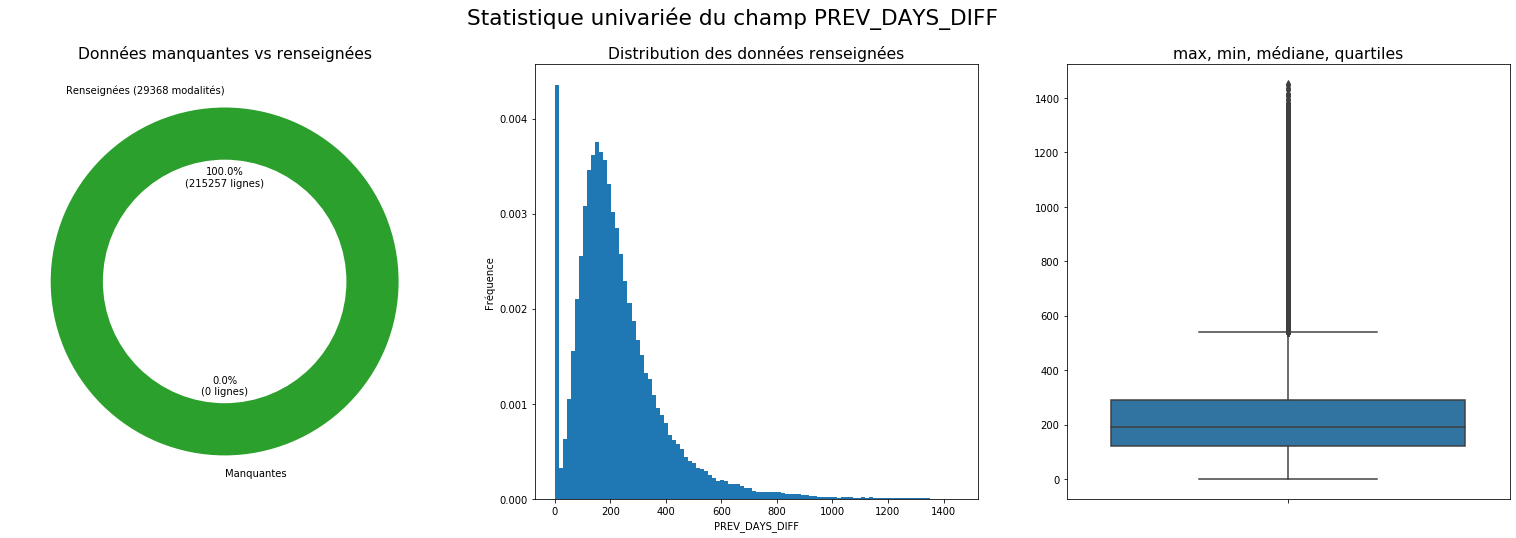

Mesures de position
 - Moyenne: 226.15
 - Médiane: 191.75
Mesures de dispertion
 - Ecart type: 166.34
 - Min: 0.0
 - Q25: 122.83
 - Q75: 290.33
 - Max: 1451.5
Mesures de forme
 - Skewness (asymétrie): 1.83
 - Kurtosis (applatissement): 5.78


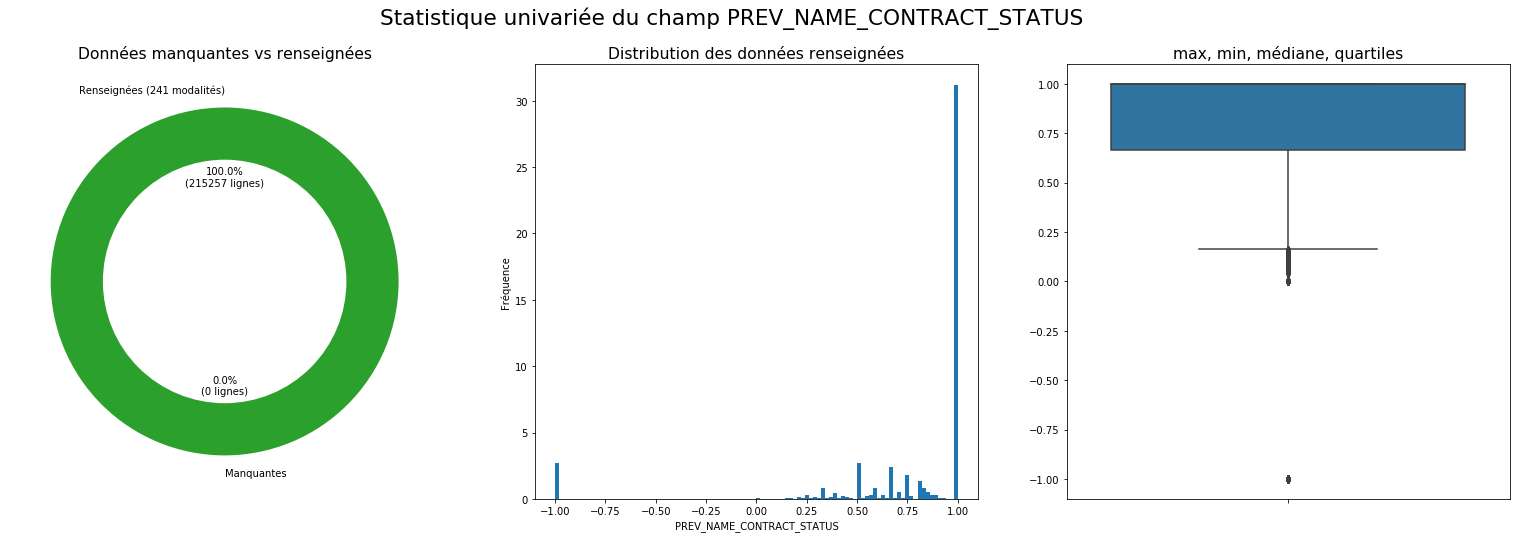

Mesures de position
 - Moyenne: 0.77
 - Médiane: 1.0
Mesures de dispertion
 - Ecart type: 0.47
 - Min: -1.0
 - Q25: 0.67
 - Q75: 1.0
 - Max: 1.0
Mesures de forme
 - Skewness (asymétrie): -2.85
 - Kurtosis (applatissement): 7.78


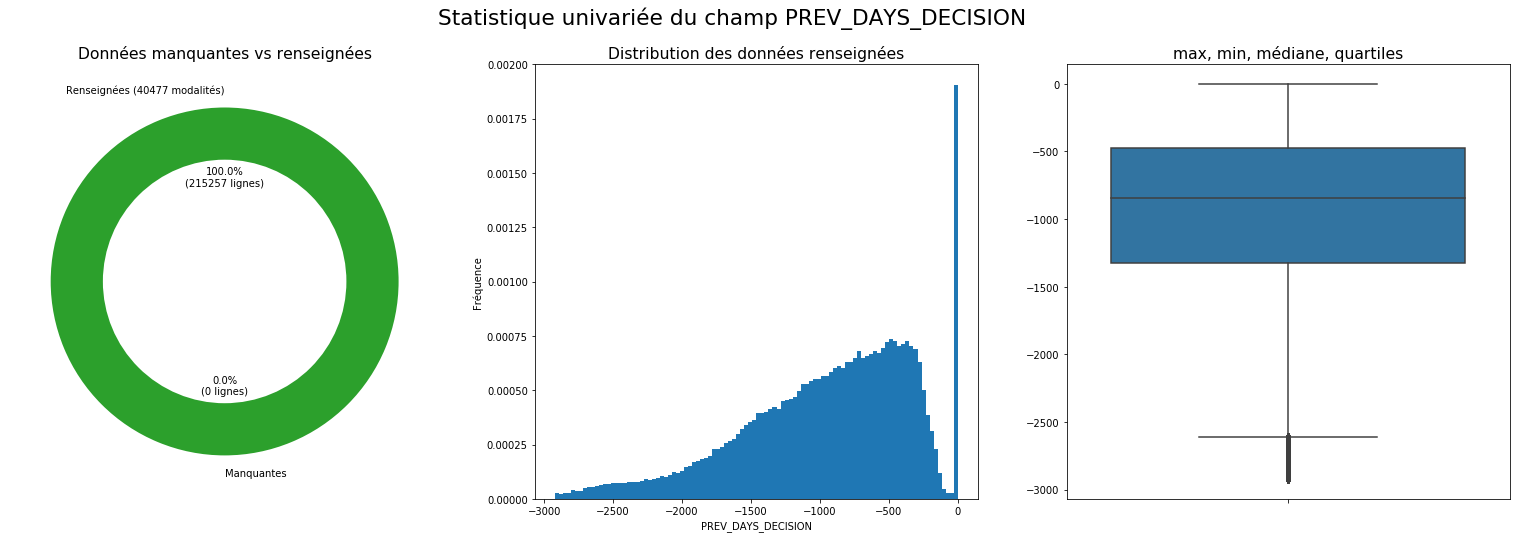

Mesures de position
 - Moyenne: -944.7
 - Médiane: -847.17
Mesures de dispertion
 - Ecart type: 615.29
 - Min: -2922.0
 - Q25: -1326.33
 - Q75: -472.0
 - Max: 0.0
Mesures de forme
 - Skewness (asymétrie): -0.71
 - Kurtosis (applatissement): 0.1


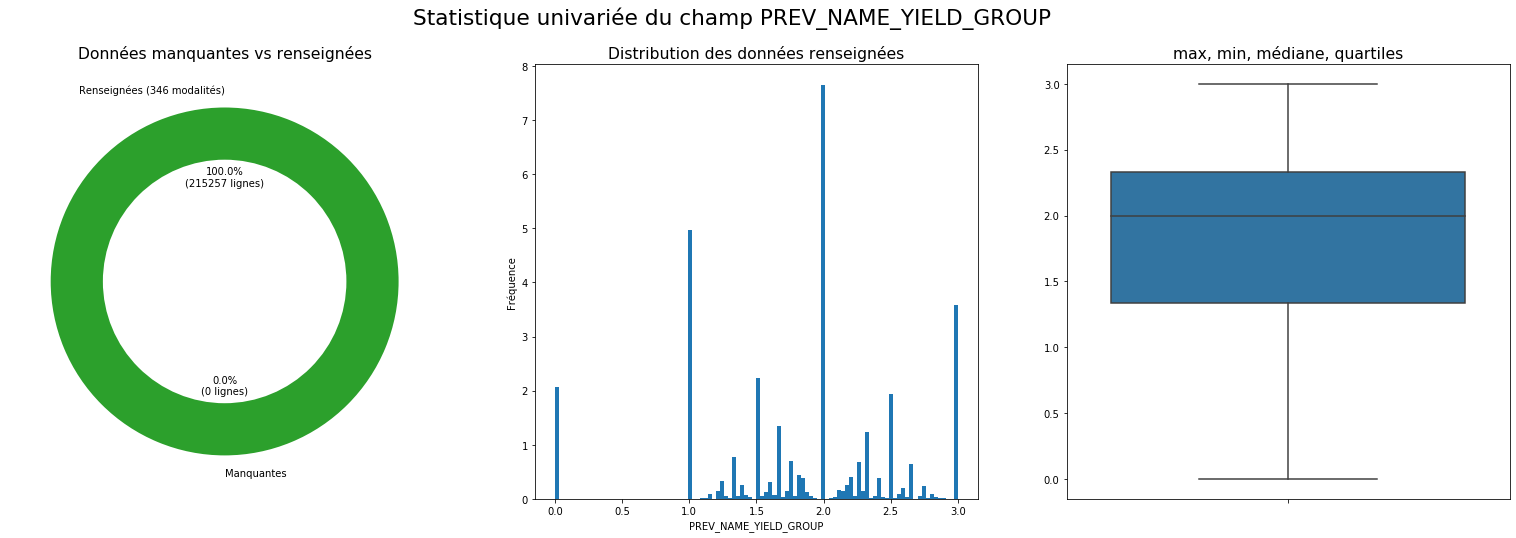

Mesures de position
 - Moyenne: 1.82
 - Médiane: 2.0
Mesures de dispertion
 - Ecart type: 0.76
 - Min: 0.0
 - Q25: 1.33
 - Q75: 2.33
 - Max: 3.0
Mesures de forme
 - Skewness (asymétrie): -0.53
 - Kurtosis (applatissement): 0.09


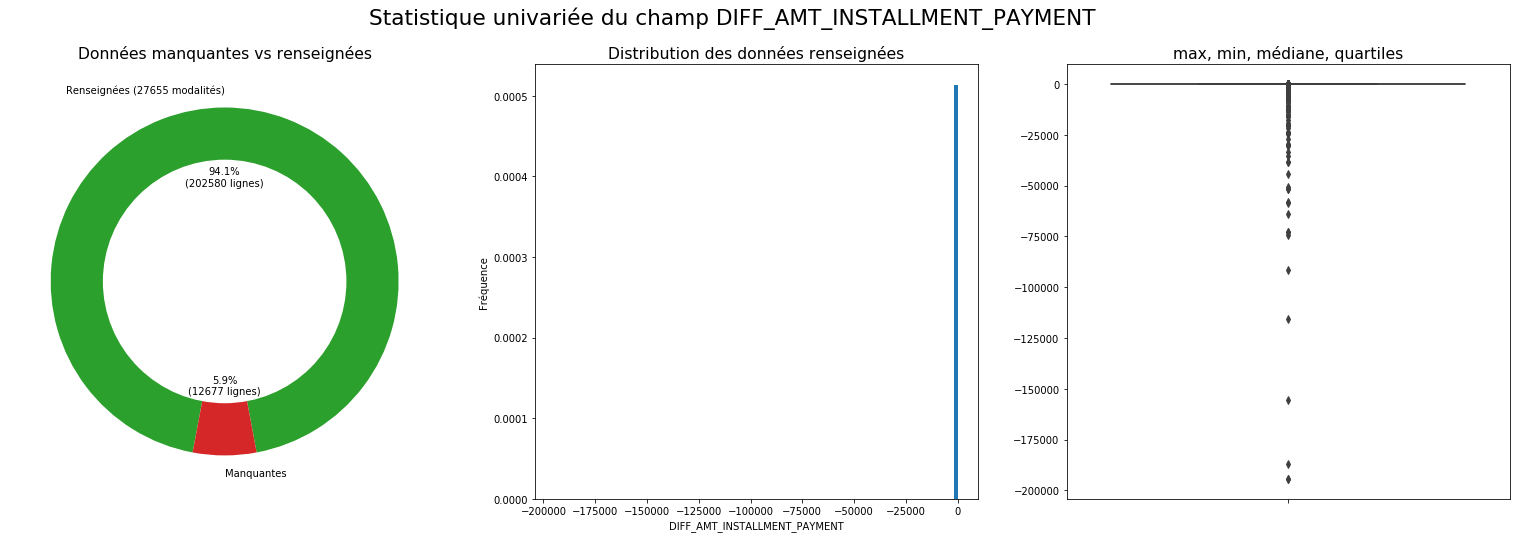

Mesures de position
 - Moyenne: -13.35
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 1021.9
 - Min: -194415.46
 - Q25: 0.0
 - Q75: 1.67
 - Max: 81.17
Mesures de forme
 - Skewness (asymétrie): -138.97
 - Kurtosis (applatissement): 22929.89


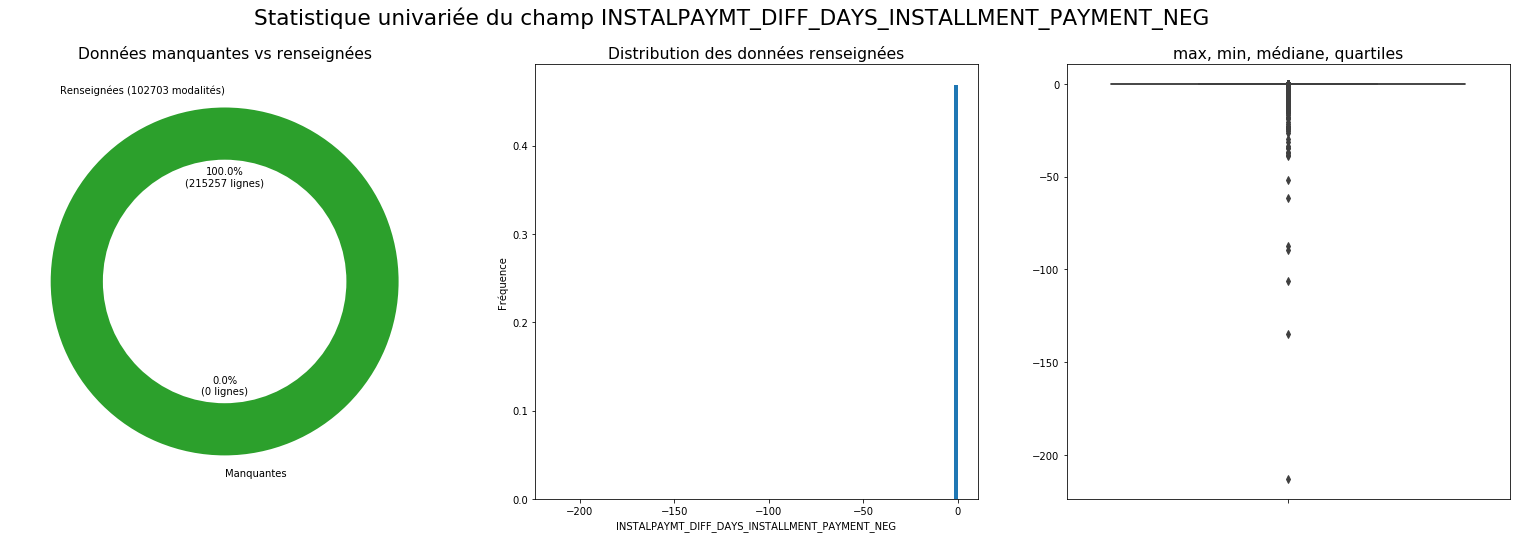

Mesures de position
 - Moyenne: -0.04
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 0.77
 - Min: -212.98
 - Q25: -0.02
 - Q75: 0.0
 - Max: 0.0
Mesures de forme
 - Skewness (asymétrie): -162.18
 - Kurtosis (applatissement): 36127.87


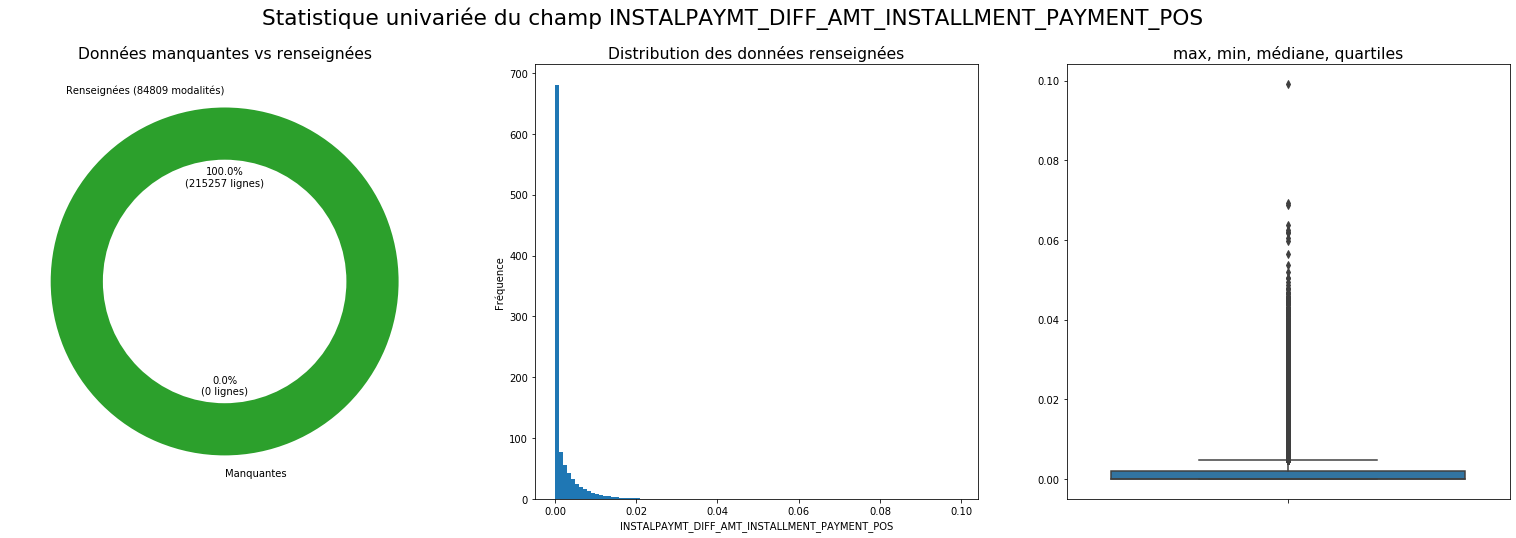

Mesures de position
 - Moyenne: 0.0
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 0.0
 - Min: 0.0
 - Q25: 0.0
 - Q75: 0.0
 - Max: 0.1
Mesures de forme
 - Skewness (asymétrie): 3.8
 - Kurtosis (applatissement): 25.25


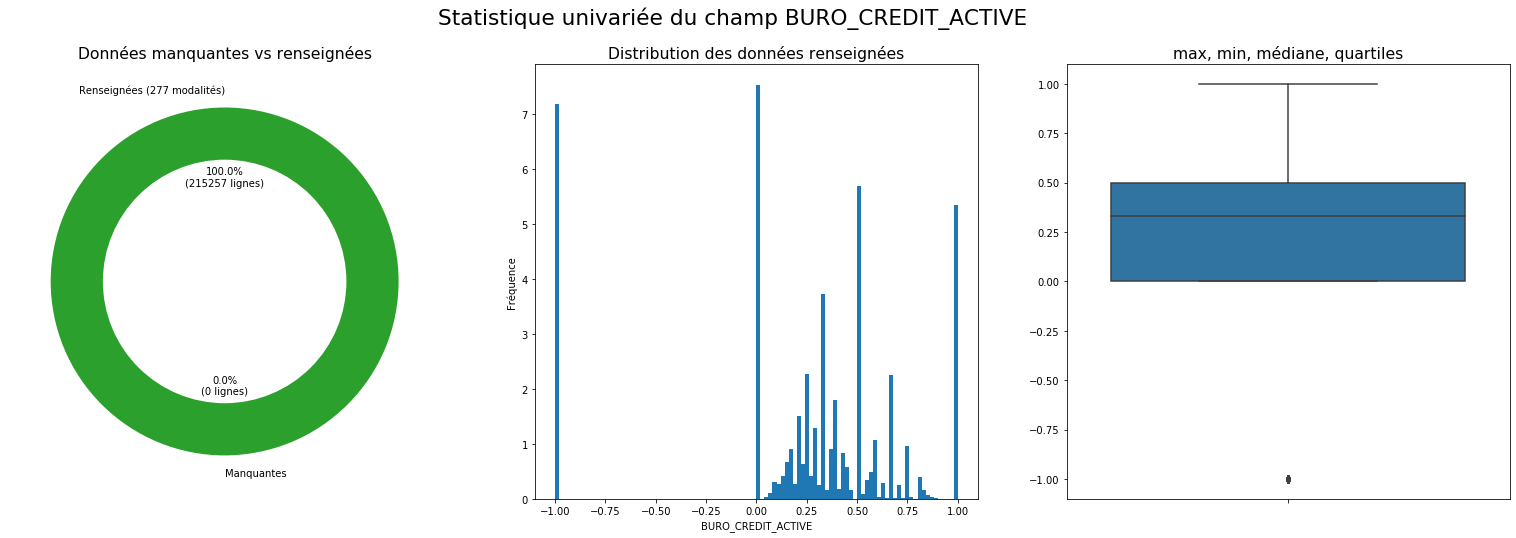

Mesures de position
 - Moyenne: 0.21
 - Médiane: 0.33
Mesures de dispertion
 - Ecart type: 0.57
 - Min: -1.0
 - Q25: 0.0
 - Q75: 0.5
 - Max: 1.0
Mesures de forme
 - Skewness (asymétrie): -0.99
 - Kurtosis (applatissement): 0.34


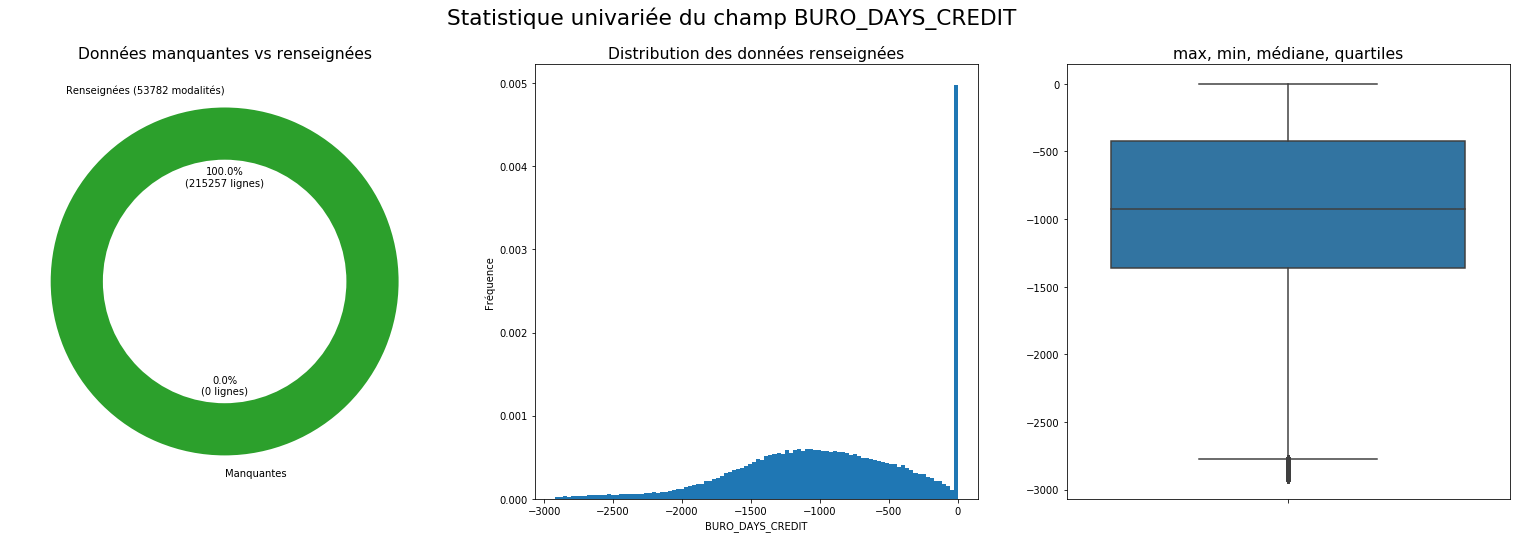

Mesures de position
 - Moyenne: -926.73
 - Médiane: -926.08
Mesures de dispertion
 - Ecart type: 644.67
 - Min: -2922.0
 - Q25: -1361.5
 - Q75: -422.0
 - Max: 0.0
Mesures de forme
 - Skewness (asymétrie): -0.35
 - Kurtosis (applatissement): -0.34


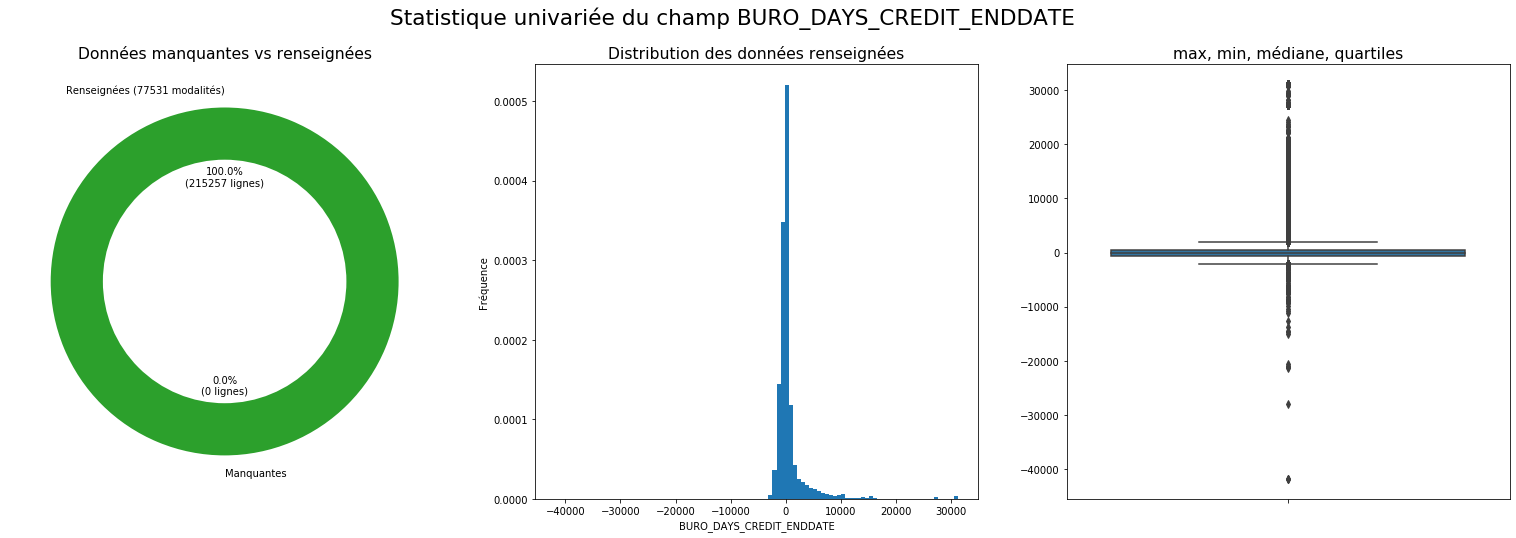

Mesures de position
 - Moyenne: 559.01
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 3051.48
 - Min: -41875.0
 - Q25: -593.17
 - Q75: 404.33
 - Max: 31198.0
Mesures de forme
 - Skewness (asymétrie): 5.35
 - Kurtosis (applatissement): 40.64


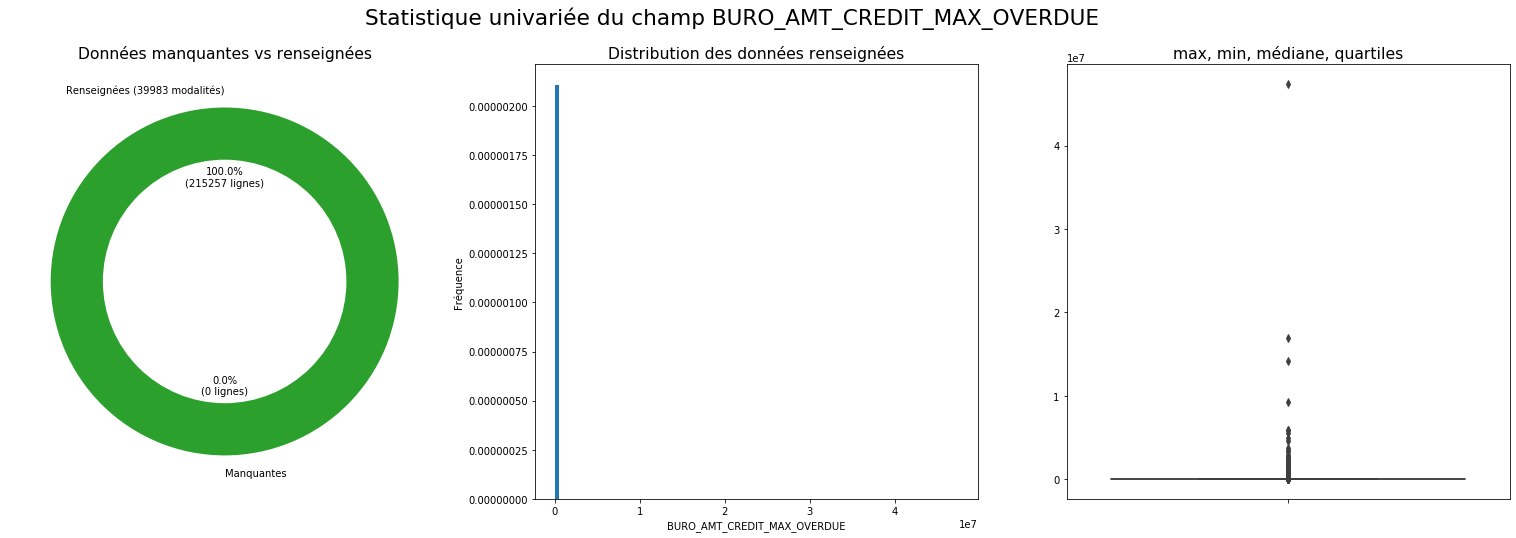

Mesures de position
 - Moyenne: 2759.67
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 120831.82
 - Min: 0.0
 - Q25: 0.0
 - Q75: 0.0
 - Max: 47406123.0
Mesures de forme
 - Skewness (asymétrie): 305.75
 - Kurtosis (applatissement): 112969.99


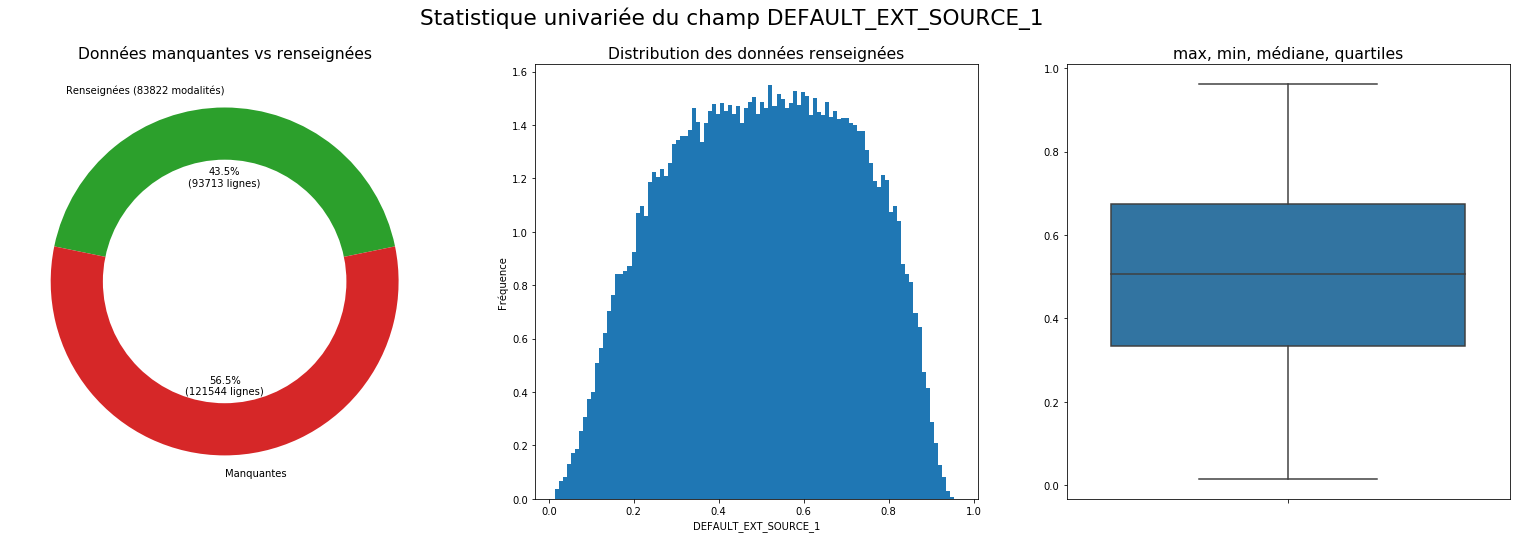

Mesures de position
 - Moyenne: 0.5
 - Médiane: 0.51
Mesures de dispertion
 - Ecart type: 0.21
 - Min: 0.01
 - Q25: 0.33
 - Q75: 0.68
 - Max: 0.96
Mesures de forme
 - Skewness (asymétrie): -0.07
 - Kurtosis (applatissement): -0.97


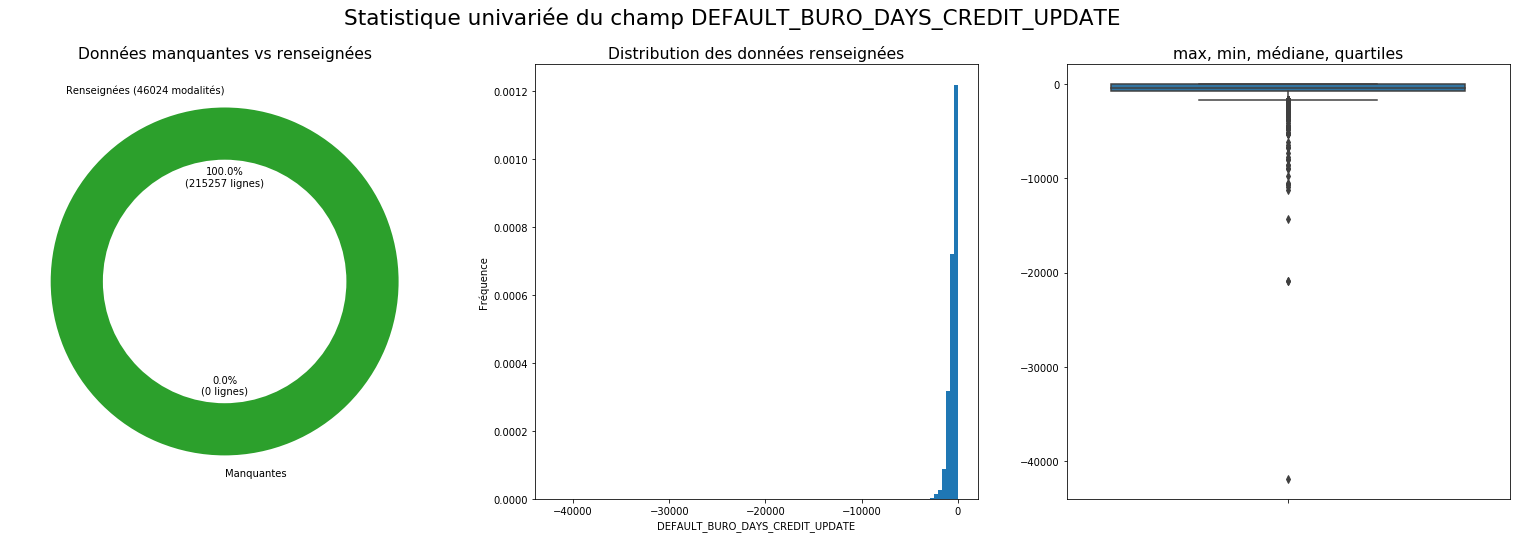

Mesures de position
 - Moyenne: -467.76
 - Médiane: -392.0
Mesures de dispertion
 - Ecart type: 465.53
 - Min: -41890.0
 - Q25: -720.12
 - Q75: -57.17
 - Max: 14.0
Mesures de forme
 - Skewness (asymétrie): -5.81
 - Kurtosis (applatissement): 341.35


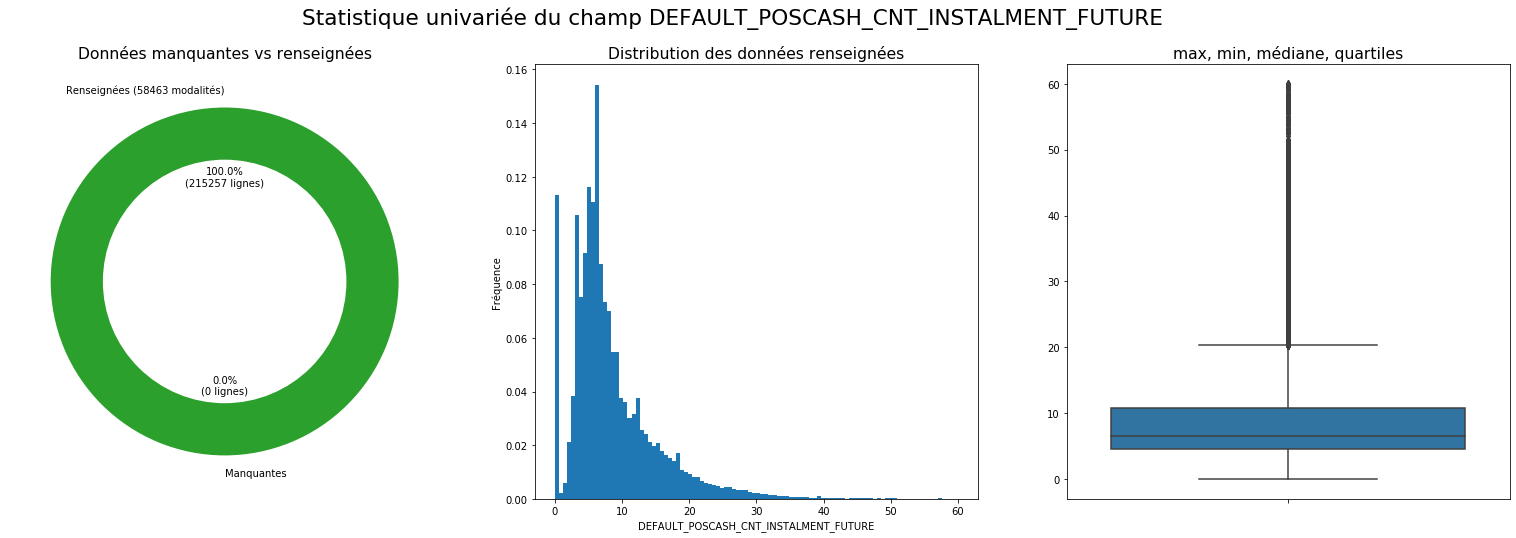

Mesures de position
 - Moyenne: 8.48
 - Médiane: 6.59
Mesures de dispertion
 - Ecart type: 6.56
 - Min: 0.0
 - Q25: 4.55
 - Q75: 10.85
 - Max: 60.0
Mesures de forme
 - Skewness (asymétrie): 1.88
 - Kurtosis (applatissement): 5.61


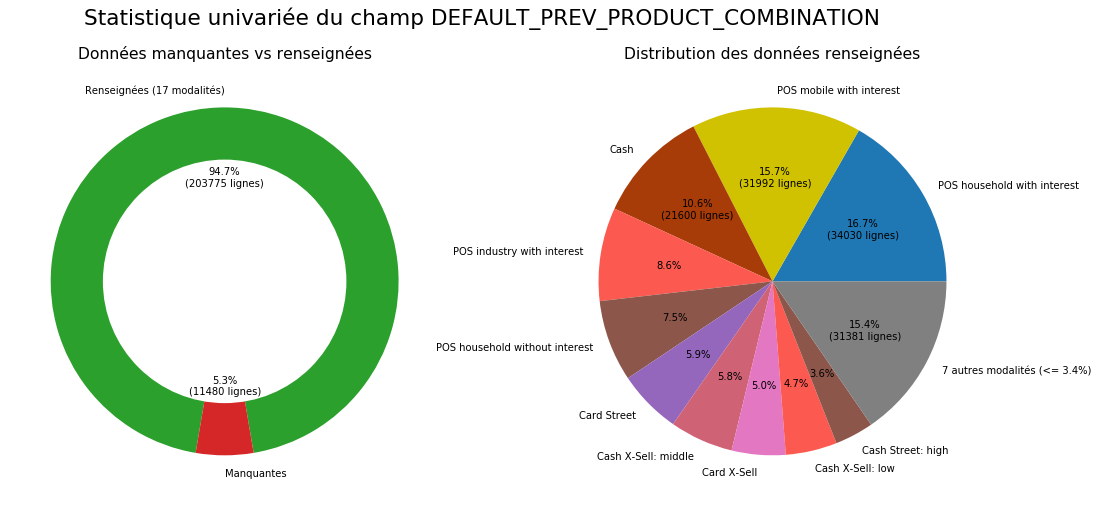

Mesures de position
 - Moyenne: 538187.97
 - Médiane: 450000.0
Mesures de dispertion
 - Ecart type: 369446.25
 - Min: 45000.0
 - Q25: 238500.0
 - Q75: 679500.0
 - Max: 4050000.0
Mesures de forme
 - Skewness (asymétrie): 1.35
 - Kurtosis (applatissement): 2.42


Mesures de position
 - Moyenne: -726.02
 - Médiane: -696.33
Mesures de dispertion
 - Ecart type: 625.84
 - Min: -2884.0
 - Q25: -1156.71
 - Q75: 0.0
 - Max: 0.0
Mesures de forme
 - Skewness (asymétrie): -0.56
 - Kurtosis (applatissement): -0.37


In [106]:
myDf(dfApplicationWorkedSvg).Stat(typeStat='univ', exclCol=['SK_ID_CURR'], statsNan=True)

## Gestion des valeurs manquantes

In [90]:
dfApplicationWorked = dfApplicationWorkedSvg.copy()

### Aperçu des valeurs manquantes

#### Valeurs numériques

(215257, 25)


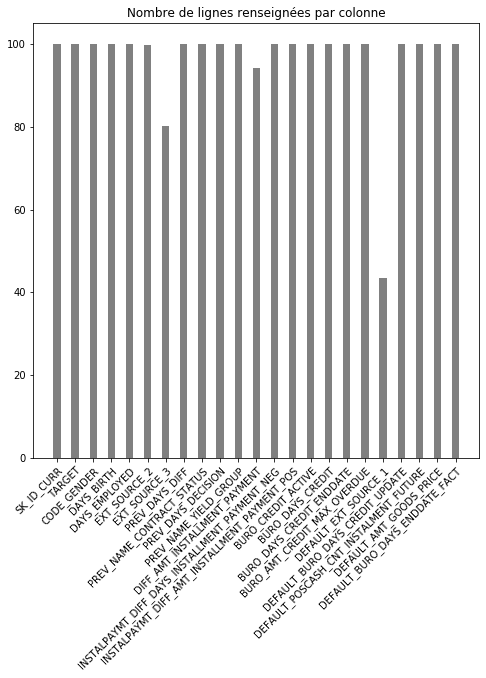

In [91]:
print(dfApplicationWorked.shape)
numerical_ix = dfApplicationWorked.select_dtypes(include=['int64', 'float64']).columns
myDf(dfApplicationWorked[numerical_ix]).ColCountLinesChart(displayColName=True)

#### Valeurs catégorielles

(215257, 25)


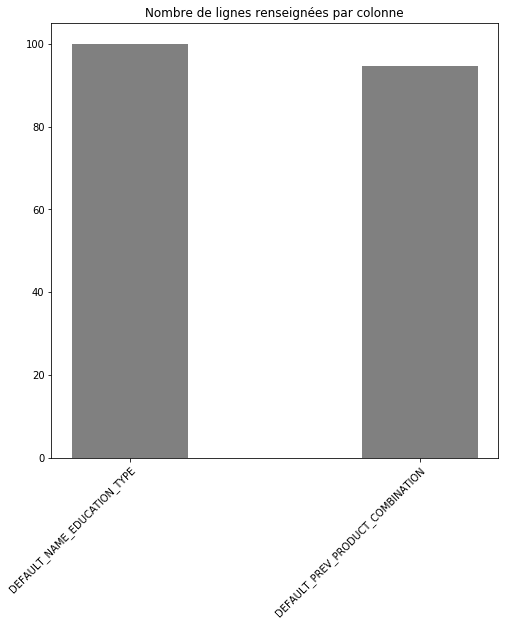

In [92]:
print(dfApplicationWorked.shape)
categorical_ix = dfApplicationWorked.select_dtypes(include=['object', 'bool']).columns
myDf(dfApplicationWorked[categorical_ix]).ColCountLinesChart(displayColName=True)

### Evaluation de l'iterative imputer

In [111]:
def evaluateImputer(imputer, model, X, y, title,cv=3):
    from sklearn.impute import SimpleImputer
    from sklearn.experimental import enable_iterative_imputer
    from sklearn.impute import IterativeImputer
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.tree import DecisionTreeRegressor
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.preprocessing import StandardScaler
    from sklearn.preprocessing import RobustScaler
    from sklearn.compose import ColumnTransformer
    from sklearn.pipeline import Pipeline

    numerical_ix = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_ix = X.select_dtypes(include=['object', 'bool']).columns
    X[categorical_ix] = X[categorical_ix].replace(np.nan, 'missing')
    t = [('cat', OneHotEncoder(handle_unknown='ignore', sparse=True), categorical_ix), ('num', MinMaxScaler(), numerical_ix)]
    #t = [('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-10), categorical_ix), ('num', MinMaxScaler(), numerical_ix)]
    col_transform = ColumnTransformer(transformers=t)
    pipeline = Pipeline(steps=[('prep',col_transform), ('i', imputer), ('m', model)])
    # evaluate the model
    t1 = time.time()
    scores = cross_val_score(pipeline, X, y, scoring= 'roc_auc' , cv=cv, n_jobs=-1)
    t2 = time.time()
    print( ' > %.3f (%.3f) %.0f ' % (mean(scores), std(scores), t2-t1))
    plt.boxplot([scores], labels=[title], showmeans=True)
    plt.title = title
    plt.show()

#### Comparaison avec le mean imputer

In [115]:
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import warnings
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor

warnings.filterwarnings('ignore')

dfApplicationWorked = dfApplicationWorkedSvg.copy()

y = dfApplicationWorked['TARGET']
del dfApplicationWorked['TARGET']
del dfApplicationWorked['SK_ID_CURR']
X = dfApplicationWorked
X_col = dfApplicationWorked.columns

#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
evaluateImputer(SimpleImputer(strategy='mean'), model, X, y, 'Mean imputer', cv=10)
evaluateImputer(IterativeImputer(), model, X, y, 'Iterative imputer')

 > 0.733 (0.008) 91 


 > 0.737 (0.004) 327 


#### Optimisation de la stratégie

In [113]:
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


strategies = ['1','2','5','10']
#strategies = ['1']
encoder = OneHotEncoder(handle_unknown='ignore', sparse=True)
#encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-10)

print(datetime.datetime.now())

results = list()
for s in strategies:
    # create the modeling pipeline
    numerical_ix = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_ix = X.select_dtypes(include=['object', 'bool']).columns
    t = [('cat', encoder, categorical_ix), ('num', MinMaxScaler(), numerical_ix)]
    col_transform = ColumnTransformer(transformers=t)
    pipeline = Pipeline(steps=[('prep',col_transform), ('i', IterativeImputer(max_iter=int(s))), ('m', RandomForestClassifier(n_estimators=200, max_depth=5, n_jobs=-1))])
    # evaluate the model
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    cv=3
    t1 = time.time()
    scores = cross_val_score(pipeline, X, y, scoring= 'roc_auc' , cv=cv, n_jobs=-1)
    t2 = time.time()
    # store results
    results.append(scores)
    print( ' >%s %.3f (%.3f) %.0f ' % (s, mean(scores), std(scores), t2-t1))
    # plot model performance for comparison
plt.boxplot(results, labels=strategies, showmeans=True)
plt.show()

2021-01-22 22:42:54.875785
 >1 0.737 (0.004) 71 
 >2 0.737 (0.004) 124 
 >5 0.736 (0.004) 282 
 >10 0.737 (0.004) 338 


#### Iterative imputer basé sur un random forest

In [114]:
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import warnings
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor

warnings.filterwarnings('ignore')

dfApplicationWorked = dfApplicationWorkedSvg.copy()

y = dfApplicationWorked['TARGET']
del dfApplicationWorked['TARGET']
del dfApplicationWorked['SK_ID_CURR']
X = dfApplicationWorked
X_col = dfApplicationWorked.columns

model = RandomForestClassifier(n_estimators=200, max_depth=5, n_jobs=-1)
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
#evaluateImputer(SimpleImputer(strategy='mean'), model, X, y, 'Mean imputer')
evaluateImputer(IterativeImputer(estimator=RandomForestRegressor(n_estimators=100, max_depth=5, n_jobs=-1)), model, X, y, 'Iterative imputer')

 > 0.735 (0.005) 17768 


# OLD

### Iterative imputer

#### Optimisation de l'IterativeImputer sur le jeu de données travaillé

In [34]:
dfApplicationWorkedImputer = dfApplicationWorked.copy()

categorical_ix = dfApplicationWorkedImputer.select_dtypes(include=['object']).columns
dfApplicationWorkedImputer[categorical_ix] = dfApplicationWorkedImputer[categorical_ix].replace(np.nan, 'missing')

dfApplicationWorkedImputer = dfApplicationWorkedImputer[0:50000]

del dfApplicationWorkedImputer['SK_ID_CURR']
y = dfApplicationWorkedImputer['TARGET']
del dfApplicationWorkedImputer['TARGET']
X = dfApplicationWorkedImputer

from sklearn.preprocessing import LabelEncoder
labelEncoder = LabelEncoder()
y = labelEncoder.fit_transform(y)

Baseline: simple imputer

In [38]:
dfApplicationDefaultImputer = dfApplicationDefault.copy()

categorical_ix = dfApplicationDefaultImputer.select_dtypes(include=['object']).columns
dfApplicationDefaultImputer[categorical_ix] = dfApplicationDefaultImputer[categorical_ix].replace(np.nan, 'missing')

dfApplicationDefaultImputer = dfApplicationDefaultImputer[0:10000]

del dfApplicationDefaultImputer['SK_ID_CURR']
y = dfApplicationDefaultImputer['TARGET']
del dfApplicationDefaultImputer['TARGET']
X = dfApplicationDefaultImputer

from sklearn.preprocessing import LabelEncoder
labelEncoder = LabelEncoder()
y = labelEncoder.fit_transform(y)

 > 0.728 (0.029) 99 


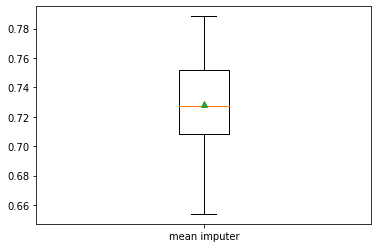

In [39]:
from sklearn.impute import SimpleImputer
evaluateImputer(SimpleImputer(strategy='mean'))

In [40]:
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


encoder = OneHotEncoder(handle_unknown='ignore')
#encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-10)

print(datetime.datetime.now())

numerical_ix = X.select_dtypes(include=['int64', 'float64']).columns
categorical_ix = X.select_dtypes(include=['object', 'bool']).columns
t = [('cat', encoder, categorical_ix), ('num', MinMaxScaler(), numerical_ix)]
col_transform = ColumnTransformer(transformers=t)
pipeline = Pipeline(steps=[('prep',col_transform), ('i', IterativeImputer(max_iter=1))])

Xtrans = pipeline.fit_transform(X)

2021-01-16 11:03:49.523790


In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


imputer = IterativeImputer()
strategies = ['1','2','5','10']
strategies = ['1']
encoder = OneHotEncoder(handle_unknown='ignore')
#encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-10)

print(datetime.datetime.now())

results = list()
for s in strategies:
    # create the modeling pipeline
    numerical_ix = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_ix = X.select_dtypes(include=['object', 'bool']).columns
    t = [('cat', encoder, categorical_ix), ('num', MinMaxScaler(), numerical_ix)]
    col_transform = ColumnTransformer(transformers=t)
    pipeline = Pipeline(steps=[('prep',col_transform), ('i', IterativeImputer(max_iter=int(s))), ('m', RandomForestClassifier(n_estimators=300, max_depth=6, n_jobs=-1))])
    # evaluate the model
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    t1 = time.time()
    scores = cross_val_score(pipeline, X, y, scoring= 'roc_auc' , cv=cv, n_jobs=-1)
    t2 = time.time()
    # store results
    results.append(scores)
    print( ' >%s %.3f (%.3f) %.0f ' % (s, mean(scores), std(scores), t2-t1))
    # plot model performance for comparison
plt.boxplot(results, labels=strategies, showmeans=True)
plt.show()

2021-01-16 08:25:34.414783
 >1 0.731 (0.031) 3027 


In [48]:
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

imputer = IterativeImputer(estimator=DecisionTreeRegressor(max_depth=999))
strategies = ['1','2','5','10']
strategies = ['8']
encoder = OneHotEncoder(handle_unknown='ignore')
#encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-10)

print(datetime.datetime.now())

results = list()
for s in strategies:
    # create the modeling pipeline
    numerical_ix = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_ix = X.select_dtypes(include=['object', 'bool']).columns
    t = [('cat', encoder, categorical_ix), ('num', MinMaxScaler(), numerical_ix)]
    col_transform = ColumnTransformer(transformers=t)
    pipeline = Pipeline(steps=[('prep',col_transform), ('i', IterativeImputer(estimator=DecisionTreeRegressor(max_depth=int(s)))), ('m', RandomForestClassifier(n_estimators=300, max_depth=6, n_jobs=-1))])
    # evaluate the model
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    t1 = time.time()
    scores = cross_val_score(pipeline, X, y, scoring= 'roc_auc' , cv=cv, n_jobs=-1)
    t2 = time.time()
    # store results
    results.append(scores)
    print( ' >%s %.3f (%.3f) %.0f ' % (s, mean(scores), std(scores), t2-t1))
    # plot model performance for comparison
plt.boxplot(results, labels=strategies, showmeans=True)
plt.show()

2021-01-16 12:36:52.281850


KeyboardInterrupt: 

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

imputer = IterativeImputer(estimator=DecisionTreeRegressor(max_depth=999))
strategies = ['1','2','5','10']
strategies = ['8']
#encoder = OneHotEncoder(handle_unknown='ignore')
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-10)

print(datetime.datetime.now())

results = list()
for s in strategies:
    # create the modeling pipeline
    numerical_ix = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_ix = X.select_dtypes(include=['object', 'bool']).columns
    t = [('cat', encoder, categorical_ix), ('num', MinMaxScaler(), numerical_ix)]
    col_transform = ColumnTransformer(transformers=t)
    pipeline = Pipeline(steps=[('prep',col_transform), ('i', IterativeImputer(estimator=DecisionTreeRegressor(max_depth=int(s)))), ('m', RandomForestClassifier(n_estimators=300, max_depth=6, n_jobs=-1))])
    # evaluate the model
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    t1 = time.time()
    scores = cross_val_score(pipeline, X, y, scoring= 'roc_auc' , cv=cv, n_jobs=-1)
    t2 = time.time()
    # store results
    results.append(scores)
    print( ' >%s %.3f (%.3f) %.0f ' % (s, mean(scores), std(scores), t2-t1))
    # plot model performance for comparison
plt.boxplot(results, labels=strategies, showmeans=True)
plt.show()

In [234]:
evaluateImputer(IterativeImputer(max_iter=10))

 > 0.734 (0.116) 14 


 > 0.722 (0.116) 13 


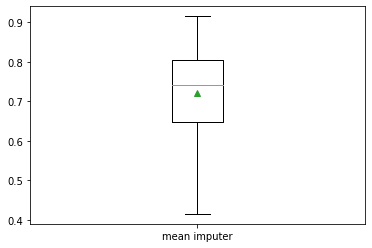

In [229]:
from sklearn.tree import DecisionTreeRegressor
evaluateImputer(IterativeImputer(max_iter=1, estimator=DecisionTreeRegressor()))

In [ ]:
results = list()
for s in strategies:
    # create the modeling pipeline
    numerical_ix = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_ix = X.select_dtypes(include=['object', 'bool']).columns
    t = [('cat', OneHotEncoder(handle_unknown='ignore'), categorical_ix), ('num', MinMaxScaler(), numerical_ix)]
    #t = [('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-10), categorical_ix), ('num', MinMaxScaler(), numerical_ix)]
    col_transform = ColumnTransformer(transformers=t)
    pipeline = Pipeline(steps=[('prep',col_transform), ('i', imputer), ('m', RandomForestClassifier(n_estimators=300, max_depth=6, n_jobs=-1))])
    # evaluate the model
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    t1 = time.time()
    scores = cross_val_score(pipeline, X, y, scoring= 'roc_auc' , cv=cv, n_jobs=-1)
    t2 = time.time()
    # store results
    results.append(scores)
    print( ' >%s %.3f (%.3f) %.0f ' % (s, mean(scores), std(scores), t2-t1))
    # plot model performance for comparison
plt.boxplot(results, labels=strategies, showmeans=True)
plt.show()

IterativeImputer: optimisation de max_iter

In [58]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

results = list()
strategies = [str(i) for i in range(1, 10)]
for s in strategies:
    # create the modeling pipeline
    # n_jobs=None pour éviter TerminatedWorkerError
    numerical_ix = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_ix = X.select_dtypes(include=['object', 'bool']).columns
    t = [('cat', OneHotEncoder(), categorical_ix), ('num', MinMaxScaler(), numerical_ix)]
    col_transform = ColumnTransformer(transformers=t)
    pipeline = Pipeline(steps=[('prep',col_transform), ('i', IterativeImputer(max_iter=int(s))), ('m', RandomForestRegressor(n_estimators=500, max_depth=6, n_jobs=-1))])
    # evaluate the model
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
    t1 = time.time()
    scores = cross_val_score(pipeline, X, y, scoring= 'roc_auc' , cv=cv, n_jobs=-1)
    t2 = time.time()
    # store results
    results.append(scores)
    print( ' >%s %.3f (%.3f) %.0f ' % (s, mean(scores), std(scores), t2-t1))
    # plot model performance for comparison
plt.boxplot(results, labels=strategies, showmeans=True)
plt.show()

results = list()
strategies = {"min-max":MinMaxScaler(), "standard":StandardScaler(), "robust":RobustScaler()}
for label, scaler in strategies.items():
    # create the modeling pipeline
    numerical_ix = X.select_dtypes(include=['int64', 'float64']).columns
    t = [('num', scaler, numerical_ix)]
    col_transform = ColumnTransformer(transformers=t)
    # evaluate the model
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    pipeline = Pipeline(steps=[('prep',col_transform), ( 'i' , IterativeImputer(max_iter=1)), ( 'm' , RandomForestRegressor(n_estimators=500, max_depth=6, n_jobs=-1))])
    t1 = time.time()
    scores = cross_val_score(pipeline, X, y, scoring= 'roc_auc' , cv=cv, n_jobs=-1)
    t2 = time.time()
    # store results
    results.append(scores)
    print( ' >%s %.3f (%.3f) %.0f ' % (label, mean(scores), std(scores), t2-t1))
    # plot model performance for comparison
plt.boxplot(results, labels=strategies.keys(), showmeans=True)
plt.show()

 >1 0.724 (0.025) 469 


WorkerInterrupt: 

IterativeImputer: optimisation de imputation_order

In [56]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer

results = list()
strategies = ['ascending', 'descending', 'roman' ,'arabic' ,'random']
for s in strategies:
    # create the modeling pipeline
    numerical_ix = X.select_dtypes(include=['int64', 'float64']).columns
    t = [('num', scaler, numerical_ix)]
    col_transform = ColumnTransformer(transformers=t)
    # evaluate the model
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    pipeline = Pipeline(steps=[('prep',col_transform), ('i', IterativeImputer(max_iter=1, imputation_order=s)), ('m', RandomForestRegressor(n_estimators=500, max_depth=6, n_jobs=-1))])
    t1 = time.time()
    scores = cross_val_score(pipeline, X, y, scoring= 'roc_auc' , cv=cv, n_jobs=-1)
    t2 = time.time()
    # store results
    results.append(scores)
    print( ' >%s %.3f (%.3f) %.0f ' % (s, mean(scores), std(scores), t2-t1))
    # plot model performance for comparison
plt.boxplot(results, labels=strategies, showmeans=True)
plt.show()

NameError: name 'scaler' is not defined

IterativeImputer: optimisation du scaler

In [57]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer

results = list()
strategies = {"min-max":MinMaxScaler(), "standard":StandardScaler(), "robust":RobustScaler()}
for label, scaler in strategies.items():
    # create the modeling pipeline
    numerical_ix = X.select_dtypes(include=['int64', 'float64']).columns
    t = [('num', scaler, numerical_ix)]
    col_transform = ColumnTransformer(transformers=t)
    # evaluate the model
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    pipeline = Pipeline(steps=[('prep',col_transform), ( 'i' , IterativeImputer(max_iter=1)), ( 'm' , RandomForestRegressor(n_estimators=500, max_depth=6, n_jobs=-1))])
    t1 = time.time()
    scores = cross_val_score(pipeline, X, y, scoring= 'roc_auc' , cv=cv, n_jobs=-1)
    t2 = time.time()
    # store results
    results.append(scores)
    print( ' >%s %.3f (%.3f) %.0f ' % (label, mean(scores), std(scores), t2-t1))
    # plot model performance for comparison
plt.boxplot(results, labels=strategies.keys(), showmeans=True)
plt.show()

 >min-max 0.725 (0.027) 140 


KeyboardInterrupt: 

#### Imputation des missing values

In [60]:
from sklearn.preprocessing import OrdinalEncoder

for dfApplication in [dfApplicationDefault, dfApplicationWorked]:  
    categorical_ix = dfApplication.select_dtypes(include=['object']).columns
    dfApplication[categorical_ix] = dfApplication[categorical_ix].replace(np.nan, 'missing')

for dfApplication in [dfApplicationDefault, dfApplicationWorked]:  
    for col in dfApplication.columns:
        if dfApplication[col].dtypes == 'object':
            ordinal_encoder = OrdinalEncoder()
            dfApplication[col] = ordinal_encoder.fit_transform(dfApplication[[col]])

Imputation sur le jeu de données travaillé

In [61]:
del dfApplicationDefaultImputer['SK_ID_CURR']
y = dfApplicationDefaultImputer['TARGET']
del dfApplicationDefaultImputer['TARGET']
X = dfApplicationDefaultImputer

In [ ]:
pipeline = Pipeline(steps=[('prep',col_transform), ( 'i' , IterativeImputer(max_iter=1)), ( 'm' , RandomForestRegressor(n_estimators=500, max_depth=6))])

In [201]:
dfApplicationDefaultSvg = dfApplicationDefault.copy()
dfApplicationWorkedSvg = dfApplicationWorked.copy()

In [235]:
for dfApplication in [dfApplicationDefault, dfApplicationWorked]:  
    categorical_ix = dfApplication.select_dtypes(include=['object']).columns
    dfApplication[categorical_ix] = dfApplication[categorical_ix].replace(np.nan, 'missing')

for dfApplication in [dfApplicationDefault, dfApplicationWorked]:  
    for col in dfApplication.columns:
        if dfApplication[col].dtypes == 'object':
            ordinal_encoder = OrdinalEncoder()
            dfApplication[col] = ordinal_encoder.fit_transform(dfApplication[[col]])

In [236]:
imputer = IterativeImputer(max_iter=1)

dfApplicationDefault = dfApplicationDefault.reset_index(drop=True)
dfApplicationDefaultId = dfApplicationDefault['SK_ID_CURR']
dfApplicationDefaultTarget = dfApplicationDefault['TARGET']
del dfApplicationDefault['SK_ID_CURR']
y = dfApplicationDefault['TARGET'].values
del dfApplicationDefault['TARGET']
X = dfApplicationDefault.values

# fit on the dataset
imputer.fit(X)
# transform the dataset
X = imputer.transform(X)

/home/pierre/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:669: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


In [239]:
dfApplicationDefault = pd.concat([dfApplicationDefaultId,
                                   dfApplicationDefaultTarget,
                                   pd.DataFrame(X, columns = dfApplicationDefault.columns)], 
                                  axis=1)

In [240]:
imputer = IterativeImputer(max_iter=1)

dfApplicationWorked = dfApplicationWorked.reset_index(drop=True)
dfApplicationWorkedId = dfApplicationWorked['SK_ID_CURR']
dfApplicationWorkedTarget = dfApplicationWorked['TARGET']
del dfApplicationWorked['SK_ID_CURR']
y = dfApplicationWorked['TARGET'].values
del dfApplicationWorked['TARGET']
X = dfApplicationWorked.values

# fit on the dataset
imputer.fit(X)
# transform the dataset
X = imputer.transform(X)

In [241]:
dfApplicationWorked = pd.concat([dfApplicationWorkedId,
                                   dfApplicationWorkedTarget,
                                   pd.DataFrame(X, columns = dfApplicationWorked.columns)], 
                                  axis=1)

### One hot encoding des variables catégorielles

In [105]:
for dfApplication in [dfApplicationWorked, dfApplicationDefault]:  
    categorical_ix = dfApplication.select_dtypes(include=['object']).columns
    dfApplication[categorical_ix] = dfApplication[categorical_ix].replace(np.nan, 'missing')

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

categorical_ix = dfApplicationDefault.select_dtypes(include=['object', 'bool']).columns
t = [('cat', OneHotEncoder(), categorical_ix)]
col_transform = ColumnTransformer(transformers=t)
pipeline = Pipeline(steps=[('prep',col_transform)])

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [19]:




def EvaluateModel(df, test_size=0.2, random_state=1):

    dfTrain, dfTest = train_test_split(df, test_size=test_size, random_state=random_state)
    
    X_train = dfTrain.copy()
    del X_train['TARGET']
    X_train = X_train.values
    y_train = dfTrain.TARGET.values
    
    X_test = dfTest.copy()
    del X_test['TARGET']
    X_test = X_test.values
    y_test = dfTest.TARGET.values
    

    # Knn avec pipeline et sélection du k
    list_train_dur = []
    list_train_scores = []
    list_train_pred_dur = []
    list_test_scores = []
    list_test_pred_dur = []
    strategies = [str(i) for i in [1,3,6,10,15,25,50]]
    for s in strategies:
        train_dur = []
        train_scores = []
        train_pred_dur = []
        test_scores = []
        test_pred_dur = []
        for _ in np.arange(10):
            pipeline = Pipeline(steps=[('i', KNNImputer(n_neighbors=int(s))), ('m', RandomForestClassifier())])
            duration_training, duration_pred_train, roc_auc_train, duration_pred_test, roc_auc_test, feature_imp = metrics_model(pipeline, X_train, y_train, X_test, y_test)
            train_dur.append(duration_training)
            train_scores.append(roc_auc_train)
            train_pred_dur.append(duration_pred_train)
            test_scores.append(roc_auc_test)
            test_pred_dur.append(duration_pred_test)
        list_train_dur.append(train_dur)
        list_train_scores.append(train_scores)
        list_train_pred_dur.append(train_pred_dur)
        list_test_scores.append(test_scores)
        list_test_pred_dur.append(test_pred_dur)
        print('>%s %.3f %.3f %.3f %.3f %.3f' % (s, mean(train_scores), mean(test_scores), mean(train_pred_dur), mean(test_pred_dur),  mean(train_dur)))
    pyplot.boxplot(list_train_scores, labels=strategies, showmeans=True)
    pyplot.boxplot(list_test_scores, labels=strategies, showmeans=True)
    pyplot.show()

>1 0.689 0.640 3.985 0.755 2.042
>3 0.691 0.643 4.084 0.762 2.100
>6 0.695 0.648 4.255 0.774 2.191
>10 0.694 0.645 4.263 0.776 2.189
>15 0.689 0.649 4.254 0.776 2.187
>25 0.691 0.644 4.262 0.772 2.163
>50 0.693 0.646 4.279 0.774 2.171


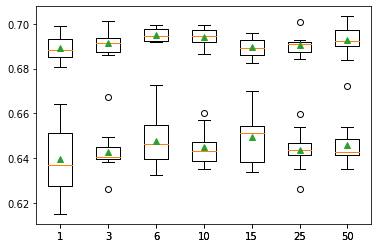

In [144]:
EvaluateModel(dfApplicationWorked)

>1 0.674 0.663 16.936 1.815 10.237
>3 0.680 0.678 18.280 1.975 10.771
>6 0.681 0.673 21.328 2.150 11.584
>10 0.682 0.672 19.521 1.997 10.368
>15 0.679 0.687 19.778 2.045 10.517
>25 0.679 0.683 19.683 2.049 10.377
>50 0.683 0.669 20.016 2.099 10.483


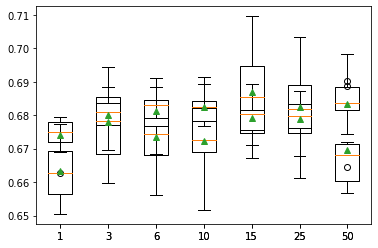

In [145]:
EvaluateModel(dfApplicationDefault)

### Gestion des valeurs manquantes

2021-01-02 18:57:15.006889    >    1 0.662 (0.035)
2021-01-02 18:57:34.409427    >    3 0.661 (0.039)
2021-01-02 18:57:54.068138    >    6 0.659 (0.045)
2021-01-02 18:58:13.875964    >    10 0.659 (0.042)
2021-01-02 18:58:33.832532    >    15 0.663 (0.048)
2021-01-02 18:58:53.667691    >    25 0.666 (0.049)
2021-01-02 18:59:13.465366    >    50 0.665 (0.048)


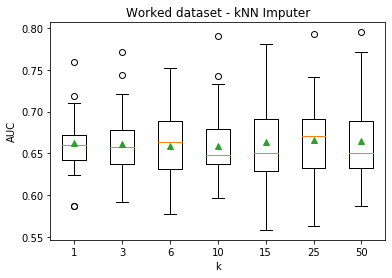

2021-01-02 19:01:00.648236    >    1 0.648 (0.042)
2021-01-02 19:02:50.323595    >    3 0.655 (0.045)
2021-01-02 19:04:42.553880    >    6 0.651 (0.044)
2021-01-02 19:06:34.653424    >    10 0.651 (0.039)
2021-01-02 19:08:28.393318    >    15 0.650 (0.041)
2021-01-02 19:10:21.964155    >    25 0.647 (0.041)
2021-01-02 19:12:16.181531    >    50 0.649 (0.039)


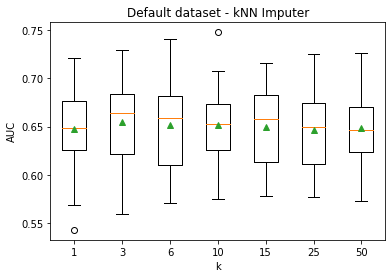

In [199]:
dfWorked, _ = train_test_split(dfApplicationWorked, test_size=0.95, random_state=1)
dfDefault = dfApplicationDefault.merge(dfWorked[['SK_ID_CURR']])
len(dfWorked)

for df in [dfWorked,dfDefault]:
    
    X = df.copy()
    y = df[['TARGET']]
    del X['TARGET']
    X = X.values
    y = y.values
    
    print('{}'.format(datetime.datetime.now()))

    # Comparer différentes stratégies d'imputation
    # evaluate each strategy on the dataset
    results = list()
    strategies = [str(i) for i in [1,3,6,10,15,25,50]]
    for s in strategies:
        # create the modeling pipeline
        pipeline = Pipeline(steps=[('i', KNNImputer(n_neighbors=int(s))), ('m', RandomForestClassifier())])
        # evaluate the model
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
        # store results
        results.append(scores)
        print('{}    >    %s %.3f (%.3f)'.format(datetime.datetime.now()) % (s, mean(scores), std(scores)))
    # plot model performance for comparison
    plt.boxplot(results, labels=strategies, showmeans=True)
    plt.ylabel('AUC')
    plt.xlabel('k')
    if len(df.columns) == len(dfApplicationWorked.columns):
        plt.title('Worked dataset - kNN Imputer')
    else:
        plt.title('Default dataset - kNN Imputer')
    plt.show()

In [200]:
len(dfWorked)

5273

10547
2021-01-02 19:13:35.583840
2021-01-02 19:14:49.846518    >    1 0.679 (0.030)
2021-01-02 19:16:04.052433    >    3 0.681 (0.030)
2021-01-02 19:17:19.774941    >    6 0.680 (0.033)
2021-01-02 19:18:34.330831    >    10 0.677 (0.037)
2021-01-02 19:19:49.405094    >    15 0.680 (0.035)
2021-01-02 19:21:04.032110    >    25 0.683 (0.033)
2021-01-02 19:22:18.752172    >    50 0.678 (0.034)


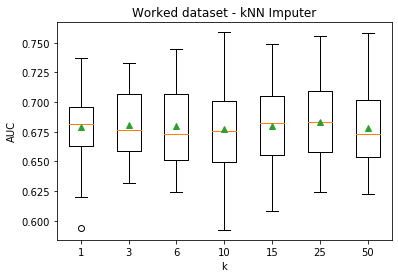

2021-01-02 19:22:18.916482


/home/pierre/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/pierre/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


2021-01-02 19:29:30.578611    >    1 0.665 (0.024)
2021-01-02 19:36:52.336378    >    3 0.660 (0.027)
2021-01-02 19:44:22.767011    >    6 0.660 (0.033)
2021-01-02 19:51:54.133847    >    10 0.666 (0.029)
2021-01-02 19:59:24.469750    >    15 0.662 (0.025)
2021-01-02 20:06:56.890931    >    25 0.662 (0.026)
2021-01-02 20:14:27.064909    >    50 0.671 (0.027)


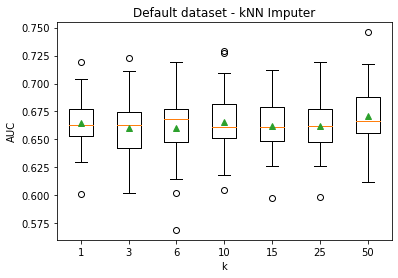

In [201]:
dfWorked, _ = train_test_split(dfApplicationWorked, test_size=0.9, random_state=1)
dfDefault = dfApplicationDefault.merge(dfWorked[['SK_ID_CURR']])
print(len(dfWorked))

for df in [dfWorked,dfDefault]:
    
    X = df.copy()
    y = df[['TARGET']]
    del X['TARGET']
    X = X.values
    y = y.values
    
    print('{}'.format(datetime.datetime.now()))

    # Comparer différentes stratégies d'imputation
    # evaluate each strategy on the dataset
    results = list()
    strategies = [str(i) for i in [1,3,6,10,15,25,50]]
    for s in strategies:
        # create the modeling pipeline
        pipeline = Pipeline(steps=[('i', KNNImputer(n_neighbors=int(s))), ('m', RandomForestClassifier())])
        # evaluate the model
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
        # store results
        results.append(scores)
        print('{}    >    %s %.3f (%.3f)'.format(datetime.datetime.now()) % (s, mean(scores), std(scores)))
    # plot model performance for comparison
    plt.boxplot(results, labels=strategies, showmeans=True)
    plt.ylabel('AUC')
    plt.xlabel('k')
    if len(df.columns) == len(dfApplicationWorked.columns):
        plt.title('Worked dataset - kNN Imputer')
    else:
        plt.title('Default dataset - kNN Imputer')
    plt.show()

In [255]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [254]:
import sklearn